# Дипломный проект. Бриф «Лаборатории исследований гражданского общества». Определение уязвимых групп населения

__Описание кейса:__ 

У 27 % россиян хватает денег только на еду, а ещё 9 % не могут позволить себе полноценное питание. Эти люди особенно внимательно следят за ценами, а темп роста цен на продукты обычно превышает средний темп инфляции. При этом Росстат считает, что расходы на продукты питания должны составлять примерно 36 % от среднемесячных расходов россиянина (ещё около 10 % приходится на услуги ЖКХ и жильё, 4 % — на лекарства).
До 2021 года «черта бедности» (жизнь на сумму ниже прожиточного минимума) в России определялась стоимостью минимальной продуктовой корзины. В том же году правительство «отвязало» уровень бедности от цен на базовые продукты: с 2021 года прожиточный минимум рассчитывается как
44.2 % от медианного дохода граждан РФ за прошлый год.

__Данные:__

В вашем распоряжении есть данные о доходах, заболеваемости, социально незащищённых слоях населения России и другие экономические и демографические данные

__Бизнес-задача__: 
- кластеризовать регионы России и определить, какие из них наиболее остро нуждаются в помощи малообеспеченным/неблагополучным слоям населения;
- описать группы населения, сталкивающиеся с бедностью;
- определить:
    - влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе;
    - связаны ли уровень бедности/социального неблагополучия с производством и потреблением в регионе;
    - какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

In [16684]:
#Устанавливаем необходимые библиотеки 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import pickle
import warnings 
warnings.filterwarnings("ignore")

## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Познакомьтесь с исходными данными поближе:
* Проведите статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Исследуйте данные на наличие пропусков и дубликатов.
* Переведите столбцы в корректные форматы (например, даты в формат datetime).

### 1.1

Начнем наше знакомство с таблицы число умерших на первом году жизни детей за год, по всем регионам, в сельской местности

In [16391]:
#Число умерших на первом году жизни детей за год, по всем регионам, в сельской местности
child_rural = pd.read_excel('child_mortality_rural_1990_2021.xls', skiprows=2) # skiprows=2 пропуская первые 2 строки
#Приведем таблицу к более читаемому виду
child_rural.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)#дадим название столбцу перечисленных регионов
child_rural.drop(['Unnamed: 1','Unnamed: 2'], axis=1, inplace=True)#удалим неинформативные столбцы
child_rural.head()

Регион     1990     1991     1992    1993   
0               Российская Федерация  11186.0  10943.0  10111.0  9840.0  \
1      Центральный федеральный округ   1615.0   1550.0   1361.0  1426.0   
2               Белгородская область    103.0     92.0     75.0    79.0   
3                   Брянская область    124.0    109.0     83.0   121.0   
4               Владимирская область     80.0     58.0     60.0    62.0   

     1994    1995    1996    1997    1998  ...    2012    2013    2014   
0  9010.0  8582.0  7983.0  7701.0  7214.0  ...  5463.0  5059.0  4681.0  \
1  1347.0  1321.0  1200.0     NaN     NaN  ...   625.0   608.0   487.0   
2    80.0    72.0    72.0    67.0    61.0  ...    43.0    48.0    41.0   
3    99.0   104.0    96.0    67.0    75.0  ...    46.0    47.0    39.0   
4    46.0    50.0    47.0    38.0    39.0  ...    30.0    31.0    23.0   

     2015    2016    2017    2018    2019    2020    2021  
0  4165.0  3568.0  3032.0  2521.0  2122.0  1916.0  1852.0  
1   490.0   426.0   347.0   291.0   211.0   228.0   212.0  
2    42.0    36.0    34.0    33.0    16.0    22.0    20.0  
3    44.0    36.0    31.0    12.0    11.0    12.0    13.0  
4    31.0    28.0    17.0    22.0    15.0    10.0    14.0  

[5 rows x 33 columns]

Посмотрим на статистические характеристики признаков. 

In [16392]:
child_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Регион  119 non-null    object 
 1   1990    111 non-null    float64
 2   1991    111 non-null    float64
 3   1992    111 non-null    float64
 4   1993    110 non-null    float64
 5   1994    99 non-null     float64
 6   1995    99 non-null     float64
 7   1996    99 non-null     float64
 8   1997    98 non-null     float64
 9   1998    98 non-null     float64
 10  1999    105 non-null    float64
 11  2000    106 non-null    float64
 12  2001    106 non-null    float64
 13  2002    106 non-null    float64
 14  2003    95 non-null     float64
 15  2004    95 non-null     float64
 16  2005    94 non-null     float64
 17  2006    94 non-null     float64
 18  2007    95 non-null     float64
 19  2008    95 non-null     float64
 20  2009    95 non-null     float64
 21  2010    96 non-null     float64
 22  20

In [16393]:
child_rural.describe()

1990          1991          1992         1993         1994   
count    111.000000    111.000000    111.000000   110.000000    99.000000  \
mean     437.693694    429.009009    395.810811   381.100000   297.979798   
std     1169.004703   1149.078156   1062.621018  1028.081066   966.625616   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%       66.500000     58.000000     54.000000    57.750000    47.000000   
50%      127.000000    125.000000    106.000000   107.000000    85.000000   
75%      280.500000    268.000000    273.500000   248.500000   175.500000   
max    11186.000000  10943.000000  10111.000000  9840.000000  9010.000000   

              1995         1996         1997         1998         1999  ...   
count    99.000000    99.000000    98.000000    98.000000   105.000000  ...  \
mean    284.818182   264.747475   236.989796   222.244898   270.638095  ...   
std     923.023253   858.232906   804.098003   753.632674   756.081143  ...   
min       0.000000     0.000000     4.000000     3.000000     1.000000  ...   
25%      46.500000    44.000000    44.250000    41.500000    42.000000  ...   
50%      83.000000    73.000000    74.000000    73.500000    73.000000  ...   
75%     154.000000   146.500000   146.500000   140.750000   181.000000  ...   
max    8582.000000  7983.000000  7701.000000  7214.000000  7074.000000  ...   

              2012         2013         2014         2015         2016   
count    91.000000    94.000000    94.000000    97.000000    96.000000  \
mean    180.659341   163.106383   149.329787   130.051546   112.416667   
std     602.358295   546.845233   507.958372   444.166996   382.494160   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%      29.500000    28.250000    23.500000    22.000000    17.000000   
50%      50.000000    47.500000    38.500000    35.000000    32.000000   
75%     101.500000    88.750000    87.250000    75.000000    67.000000   
max    5463.000000  5059.000000  4681.000000  4165.000000  3568.000000   

              2017         2018         2019         2020         2021  
count    96.000000    96.000000    96.000000    96.000000    95.000000  
mean     95.791667    79.583333    67.000000    60.343750    58.957895  
std     325.416427   269.804829   227.157353   204.774527   199.186105  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%      15.000000    10.750000     9.000000     8.000000     9.000000  
50%      23.000000    22.000000    17.000000    15.000000    14.000000  
75%      54.750000    46.250000    39.000000    34.250000    33.500000  
max    3032.000000  2521.000000  2122.000000  1916.000000  1852.000000  

[8 rows x 32 columns]

Итак, у нас есть данные о детской смертности на первом году жизни за год, по 119 регионам, в сельской местности, за период с 1990 по 2021 года. В данных есть пропуски. 

Забегая вперед, в своей работе я буду использовать много таблиц за разные периоды времени, хотелось бы их привести к какому-то единому срезу, поэтому часть данных придется удалить. Пока ориентируюсь на то, чтобы оставить данные после 2016 года, т к ранее информация скорее всего уже неактуальна и устарела, а последующие таблицы представлены за более поздний период времени.

Регионы тоже требуют преобразований. Например, особенностью Тюменской области является то, что в её состав входят два других субъекта Российской Федерации: Ханты-Мансийский автономный округ — Югра и Ямало-Ненецкий автономный округ (чаще всего в датасетах указывается отдельно Тюменская область и отдельно — без учёта автономных округов). То же самое касается Архангельской области — в её состав входит
самостоятельный субъект Ненецкий автономный округ. 

Но для начала удалим среди регионов стороки с регионами: РФ, федеральные округа и район, т к это агрегированные данные, и их использование нежалательно, по ним нельзя сделать никаких интересных выводов, и к тому же, на протяжении последних 20 лет составы федеральных округов менялись (некоторые регионы меняли принадлежность к округу), из-за чего в них мог произойти резкий рост/снижение численности населения, что не
отображало какое-то демографическое явление.

In [16394]:
#child_rural['Регион'].unique()
# Удаляем строки содержащие федеральный округ, Федерация и район 
for_del = child_rural[child_rural['Регион'].str.contains('федеральный округ|Федерация|район')].index
child_rural.drop(for_del, axis = 0, inplace=True)

In [16395]:
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [str(year) for year in range(1990, 2016)]  #Создаёт список строковых названий колонок с 1990 до 2015 гг.
child_rural = child_rural.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы

In [16396]:
child_rural.isna().sum().sum()

43

In [16397]:
# Заполняем пропущенные значения (NaN) последними ненулевыми значениями в столбце или строке
child_rural.fillna(method='pad', axis=0, inplace=True)

In [16398]:
child_rural.duplicated().sum()

0

Чтобы не добавлять правила для всех возможных ошибок в написаниях регионов, воспользуемся методом приближённого поиска (rapidfuzz). Это позволит сопоставить некорректные записи с наиболее похожими значениями из эталонного списка.

In [16399]:
pip install rapidfuzz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16400]:
# Создадим основной список регионов РФ с корректными наименованиями по состоянию на 2021 год
correct_region_list = [
    'Республика Адыгея', 'Республика Алтай', 'Республика Башкортостан', 
    'Республика Бурятия', 'Республика Дагестан', 'Республика Ингушетия', 
    'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика', 
    'Республика Калмыкия', 'Республика Карелия', 'Республика Коми', 
    'Республика Крым', 'Республика Марий Эл', 'Республика Мордовия', 
    'Республика Саха (Якутия)', 'Республика Северная Осетия-Алания', 
    'Республика Татарстан', 'Республика Тыва', 'Удмуртская Республика', 
    'Республика Хакасия', 'Чеченская Республика', 'Чувашская Республика - Чувашия', 
    'Алтайский край', 'Забайкальский край', 'Камчатский край', 
    'Краснодарский край', 'Красноярский край', 'Пермский край', 
    'Приморский край', 'Ставропольский край', 'Хабаровский край', 
    'Амурская область', 'Архангельская область', 'Астраханская область', 
    'Белгородская область', 'Брянская область', 'Владимирская область', 
    'Волгоградская область', 'Вологодская область', 'Воронежская область', 
    'Ивановская область', 'Иркутская область', 'Калининградская область', 
    'Калужская область', 'Кемеровская область - Кузбасс', 'Кировская область', 
    'Костромская область', 'Курганская область', 'Курская область', 
    'Ленинградская область', 'Липецкая область', 'Магаданская область', 
    'Московская область', 'Мурманская область', 'Нижегородская область', 
    'Новгородская область', 'Новосибирская область', 'Омская область', 
    'Оренбургская область', 'Орловская область', 'Пензенская область', 
    'Псковская область', 'Ростовская область', 'Рязанская область', 
    'Самарская область', 'Саратовская область', 'Сахалинская область', 
    'Свердловская область', 'Смоленская область', 'Тамбовская область', 
    'Тверская область', 'Томская область', 'Тульская область', 
    'Тюменская область', 'Ульяновская область', 'Челябинская область', 
    'Ярославская область', 'Ненецкий автономный округ', 
    'Ханты-Мансийский автономный округ', 'Чукотский автономный округ', 
    'Ямало-Ненецкий автономный округ', 'Еврейская автономная область', 
    'Москва', 'Санкт-Петербург', 'Севастополь'
    ]

#Устанавливаем необходимую библиотеку
from rapidfuzz import process

# Универсальная функция нормализации регионов
def normalize_region_name(region_name, correct_list, threshold=65):
    """
    Функция нормализует названия регионов с использованием приближённого поиска с учётом дополнительных случаев.

    Args:
        region_name (str): Название региона для нормализации.
        correct_list (list): Эталонный список правильных названий регионов.
        threshold (int): Порог совпадения (0-100). Чем выше, тем строже сопоставление.

    Returns:
        str: Нормализованное название региона.
    """
    
        # Убираем лишние пробелы по краям
    region_name = region_name.strip()
    #С помощью регулярных выражений учитываем дополнительные случаи с сокращениями (сюда пе мере необходимости буду 
    # добавлять определенные правила в зависимости от нюансов отдельных таблиц)
    region_name = re.sub(r'\bавт\. округ\b', 'автономный округ', region_name, flags=re.IGNORECASE)
    region_name = re.sub(r'\bавт\. область\b', 'автономная область', region_name, flags=re.IGNORECASE)
    
    # Обрабатываем случаи для Москвы 
    if re.search(r'\bМосква\b', region_name, re.IGNORECASE):
        return 'Москва'
    # Учитываем дополнительные особые случаи
    if re.search(r'Коми-Пермяцкий округ', region_name, re.IGNORECASE):
        return 'Пермский край'
    if re.search(r'Корякский округ', region_name, re.IGNORECASE):
        return 'Камчатский край'
    if re.search(r'Усть-Ордынский Бурятский округ', region_name, re.IGNORECASE):
        return 'Иркутская область'

    # Особые случаи для Тюменской области и её автономных округов
    if re.search(r'Ханты-Мансийский.*Югра', region_name, re.IGNORECASE):
        return 'Ханты-Мансийский автономный округ'
    if re.search(r'Ямало-Ненецкий', region_name, re.IGNORECASE):
        return 'Ямало-Ненецкий автономный округ'
    if re.search(r'Тюменская область', region_name, re.IGNORECASE):
        return 'Тюменская область'
# Особые случаи для Архангельской области и Ненецкого автономного округа
    if re.search(r'Ненецкий автономный округ', region_name, re.IGNORECASE):
        return 'Ненецкий автономный округ'
    if re.search(r'Архангельская область', region_name, re.IGNORECASE):
        return 'Архангельская область'

    # Выполняем приближённый поиск по эталонному списку
    match = process.extractOne(region_name, correct_list, score_cutoff=threshold)
    if match:
        return match[0]  # Возвращаем наименование из эталонного списка

    # Если совпадение не найдено, возвращаем оригинальное название
    return region_name


# Функция применения к таблице
def standardize_regions(df, column_name, correct_list):
    """
    Применяет нормализацию названий регионов для столбца DataFrame.

    Args:
        df: Исходная таблица.
        column_name (str): Имя столбца с регионами.
        correct_list (list): Эталонный список правильных названий регионов.

    Returns:
        Таблицу с нормализованными регионами.
    """
    df[column_name] = df[column_name].apply(lambda x: normalize_region_name(x, correct_list))
    return df


In [16401]:
# Стандартизация
child_rural = standardize_regions(child_rural, 'Регион', correct_region_list)

# Группируем по региону и суммируем данные
child_rural_grouped= child_rural.groupby('Регион').sum().reset_index()
child_rural_grouped['Регион'].unique()

array(['Алтайский край', 'Амурская область', 'Архангельская область',
       'Астраханская область', 'Белгородская область', 'Брянская область',
       'Владимирская область', 'Волгоградская область',
       'Вологодская область', 'Воронежская область',
       'Еврейская автономная область', 'Забайкальский край',
       'Ивановская область', 'Иркутская область',
       'Кабардино-Балкарская Республика', 'Калининградская область',
       'Калужская область', 'Камчатский край',
       'Карачаево-Черкесская Республика', 'Кемеровская область - Кузбасс',
       'Кировская область', 'Костромская область', 'Краснодарский край',
       'Красноярский край', 'Курганская область', 'Курская область',
       'Ленинградская область', 'Липецкая область', 'Магаданская область',
       'Москва', 'Московская область', 'Мурманская область',
       'Ненецкий автономный округ', 'Нижегородская область',
       'Новгородская область', 'Новосибирская область', 'Омская область',
       'Оренбургская область', 

Теперь кажется с этим можно работать 

In [16402]:
# Проверяем на пропуски
child_rural_grouped.isnull().sum().sum()

0

In [16403]:
#проверяем размерность 
child_rural_grouped.shape

(85, 7)

In [16404]:
child_rural_grouped.head(2)

Регион  2016  2017  2018  2019  2020  2021
0    Алтайский край  87.0  79.0  70.0  60.0  44.0  42.0
1  Амурская область  23.0  20.0  17.0  16.0  13.0  15.0

### 1.2

Идем дальше. Теперь познакомимся с данными из таблицы число умерших на первом году жизни детей за год, по всем регионам, в городской местности. Таблица схожа с предыдущей, поэтому повторяем все те же самые шаги.

In [16405]:
#Число умерших на первом году жизни детей за год, по всем регионам, в сельской местности
child_urban = pd.read_excel('child_mortality_urban_1990_2021.xls', skiprows=2) # skiprows=2 пропуская первые 2 строки
#child_urban.head()
#Приведем таблицу к более читаемому виду
child_urban.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
child_urban.drop(['Unnamed: 1','Unnamed: 2'], axis=1, inplace=True)#удалим неинформативные столбцы
child_urban.head()

Регион     1990     1991     1992     1993   
0               Российская Федерация  23902.0  21549.0  19097.0  18106.0  \
1      Центральный федеральный округ   5317.0   4734.0   4175.0   3899.0   
2               Белгородская область    209.0    198.0    165.0    165.0   
3                   Брянская область    198.0    195.0    200.0    176.0   
4               Владимирская область    221.0    209.0    179.0    148.0   

      1994     1995     1996     1997     1998  ...     2012     2013    2014   
0  17131.0  16258.0  14842.0  14034.0  13883.0  ...  10843.0  10418.0  9641.0  \
1   3871.0   3631.0   3254.0      NaN      NaN  ...   2789.0   2735.0  2402.0   
2    153.0    131.0    102.0    100.0     99.0  ...     84.0     68.0    62.0   
3    157.0    125.0    116.0    135.0    107.0  ...     81.0     77.0    87.0   
4    165.0    146.0    114.0    123.0    130.0  ...     97.0     86.0    87.0   

     2015    2016    2017    2018    2019    2020    2021  
0  8499.0  7860.0  6545.0  5723.0  5206.0  4573.0  4664.0  
1  2228.0  2146.0  1785.0  1593.0  1409.0  1153.0  1192.0  
2    68.0    72.0    43.0    40.0    23.0    25.0    34.0  
3    67.0    67.0    65.0    33.0    26.0    29.0    14.0  
4    76.0    72.0    59.0    45.0    43.0    51.0    52.0  

[5 rows x 33 columns]

In [16406]:
#Статистика 
child_urban.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Регион  119 non-null    object 
 1   1990    111 non-null    float64
 2   1991    111 non-null    float64
 3   1992    111 non-null    float64
 4   1993    110 non-null    float64
 5   1994    99 non-null     float64
 6   1995    99 non-null     float64
 7   1996    99 non-null     float64
 8   1997    99 non-null     float64
 9   1998    99 non-null     float64
 10  1999    106 non-null    float64
 11  2000    107 non-null    float64
 12  2001    107 non-null    float64
 13  2002    107 non-null    float64
 14  2003    96 non-null     float64
 15  2004    96 non-null     float64
 16  2005    95 non-null     float64
 17  2006    95 non-null     float64
 18  2007    96 non-null     float64
 19  2008    96 non-null     float64
 20  2009    96 non-null     float64
 21  2010    97 non-null     float64
 22  20

In [16407]:
child_urban.describe()

1990          1991          1992          1993          1994   
count    111.000000    111.000000    111.000000    110.000000     99.000000  \
mean     895.513514    810.954955    721.261261    685.218182    547.040404   
std     2447.679910   2206.232319   1954.744432   1864.276033   1815.224582   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      132.500000    120.500000    103.500000     99.000000     82.500000   
50%      236.000000    217.000000    200.000000    179.500000    154.000000   
75%      672.500000    635.000000    514.000000    555.750000    390.000000   
max    23902.000000  21549.000000  19097.000000  18106.000000  17131.000000   

               1995          1996          1997          1998          1999   
count     99.000000     99.000000     99.000000     99.000000    106.000000  \
mean     520.252525    475.242424    427.252525    422.181818    516.905660   
std     1720.633529   1571.220175   1449.868751   1432.870035   1430.858527   
min        0.000000      0.000000      1.000000      1.000000      1.000000   
25%       85.000000     77.500000     75.500000     79.500000     79.250000   
50%      141.000000    132.000000    135.000000    130.000000    146.500000   
75%      371.000000    348.500000    346.500000    335.500000    399.750000   
max    16258.000000  14842.000000  14034.000000  13883.000000  13657.000000   

       ...          2012          2013         2014         2015         2016   
count  ...     92.000000     94.000000    94.000000    97.000000    96.000000  \
mean   ...    355.402174    336.404255   308.659574   266.072165   248.291667   
std    ...   1184.204746   1126.265504  1040.248322   905.446520   843.916583   
min    ...      1.000000      3.000000     2.000000     3.000000     1.000000   
25%    ...     54.750000     54.250000    47.250000    43.000000    38.750000   
50%    ...     87.000000     87.000000    81.000000    71.000000    64.500000   
75%    ...    248.500000    218.500000   220.500000   167.000000   159.750000   
max    ...  10843.000000  10418.000000  9641.000000  8499.000000  7860.000000   

              2017         2018         2019         2020         2021  
count    96.000000    96.000000    96.000000    96.000000    95.000000  
mean    206.885417   180.614583   164.760417   144.562500   148.115789  
std     703.613857   615.761409   558.776290   488.450694   500.979251  
min       2.000000     0.000000     0.000000     1.000000     1.000000  
25%      29.000000    27.500000    24.750000    21.750000    20.500000  
50%      49.500000    42.000000    38.500000    33.500000    34.000000  
75%     143.750000   121.500000   108.000000   105.250000   103.000000  
max    6545.000000  5723.000000  5206.000000  4573.000000  4664.000000  

[8 rows x 32 columns]

In [16408]:
child_urban.isna().sum().sum()

632

In [16409]:
# Заполняем пропущенные значения (NaN) последними ненулевыми значениями в столбце или строке
child_urban.fillna(method='pad', axis=0, inplace=True)

In [16410]:
child_urban.duplicated().sum()

0

In [16411]:
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = child_urban[child_urban['Регион'].str.contains('федеральный округ|Федерация|район')].index
child_urban.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
child_urban = standardize_regions(child_urban, 'Регион', correct_region_list)
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [str(year) for year in range(1990, 2016)]  #Создаёт список строковых названий колонок с 1990 до 2015 гг.
child_urban = child_urban.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
#child_rural.head(3)

# Группируем по региону и суммируем данные
child_urban_grouped = child_urban.groupby('Регион').sum().reset_index()
# Проверяем на пропуски
child_urban_grouped.isnull().sum().sum()
#child_urban_grouped.shape

0

In [16412]:
child_urban_grouped.shape

(85, 7)

In [16413]:
child_urban_grouped.head(2)

Регион   2016   2017   2018  2019  2020  2021
0    Алтайский край  124.0  106.0  106.0  54.0  53.0  46.0
1  Амурская область   30.0   28.0   29.0  27.0  29.0  21.0

### 1.3

Далее на очереди число людей с инвалидностью, которые представлены с разбивкой по регионам, по месяцам, по возрастным группам, с 2017 по 2022 гг.

In [16414]:
disabled = pd.read_csv('disabled_total_by_age_2017_2022.csv')
disabled.head()
#disabled.shape

region       total     18_30     31_40      41_50   
0           Российская Федерация  11640873.0  550895.0  766054.0  1030652.0  \
1  Центральный федеральный округ   3420310.0  118579.0  172662.0   257484.0   
2           Белгородская область    223030.0    6318.0   10383.0    16596.0   
3               Брянская область    110418.0    4215.0    6568.0    10230.0   
4           Владимирская область    133352.0    4454.0    6811.0     9606.0   

       51_60        60_        date  
0  2135436.0  7157836.0  2017-01-01  
1   598102.0  2273483.0  2017-01-01  
2    37444.0   152289.0  2017-01-01  
3    21481.0    67924.0  2017-01-01  
4    23322.0    89159.0  2017-01-01

In [16415]:
disabled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  6080 non-null   object 
 1   total   6074 non-null   float64
 2   18_30   6073 non-null   float64
 3   31_40   6074 non-null   float64
 4   41_50   6074 non-null   float64
 5   51_60   6074 non-null   float64
 6   60_     6074 non-null   float64
 7   date    6080 non-null   object 
dtypes: float64(6), object(2)
memory usage: 380.1+ KB


In [16416]:
#Начнес с приобразования регионов
disabled.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = disabled[disabled['Регион'].str.contains('федеральный округ|г. Байконур|Федерация|район')].index
disabled.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
disabled = standardize_regions(disabled, 'Регион', correct_region_list)
# Осталось сгруппировать данные по региону и дате, предварительно приведя столбец с информацией о дате в формат datetime.

In [16417]:
disabled.isna().sum().sum()

36

In [16418]:
# Заполняем пропущенные значения (NaN) последними ненулевыми значениями в столбце или строке
disabled.fillna(method='pad', axis=0, inplace=True)
#проверяем на наличие дубликатов
disabled.duplicated().sum()

0

In [16419]:
# Осталось сгруппировать данные по региону и дате, предварительно приведя столбец с информацией о дате в формат datetime.
disabled['date'] = pd.to_datetime(disabled['date']).dt.year
disabled = disabled.groupby(['Регион', 'date']).sum().reset_index()
disabled.head()

Регион  date      total    18_30     31_40     41_50     51_60   
0  Алтайский край  2017  2016119.0  96278.0  151702.0  157077.0  330175.0  \
1  Алтайский край  2018  2120203.0  95338.0  162110.0  174663.0  331820.0   
2  Алтайский край  2019  2100077.0  89164.0  162016.0  182369.0  312191.0   
3  Алтайский край  2020  2060817.0  85613.0  161395.0  188844.0  292244.0   
4  Алтайский край  2021  1986766.0  86568.0  158877.0  196573.0  271536.0   

         60_  
0  1280887.0  
1  1356272.0  
2  1354337.0  
3  1332721.0  
4  1273212.0

Хочется видеть эти данные в несколько ином виде, чтобы в дальнейшем данную таблицу было легко интегрировать в общую, и удобно подавать в будущую модель кластеризации. Попробую разбить данный датасет на отдельные таблицы по возростным группам, поскольку еще не знаю какой конкретно временной срез буду использовать и насколько возрастные группы могут дать дополнительную ценность для анализа в контексте других признаков.

In [16420]:
# Список возрастных групп
age_groups = ['18_30', '31_40', '41_50', '51_60', '60_', 'total']

# Создаем отдельные DataFrame для каждой возрастной группы, сгруппированные по региону и году
for group in age_groups:
    # Группировка по региону и году с суммированием значений
    df_group = disabled.groupby(['Регион', 'date'])[group].sum().reset_index()
    
    # Преобразование таблицы: года становятся колонками, регионы — индексами
    globals()[f'disabled_{group}'] = df_group.pivot(index='Регион', columns='date', values=group)

# Вывод 
disabled_total.head()

date                        2017       2018       2019       2020       2021   
Регион                                                                         
Алтайский край         2016119.0  2120203.0  2100077.0  2060817.0  1986766.0  \
Амурская область        816315.0   797050.0   785693.0   766768.0   733732.0   
Архангельская область  1056888.0  1038542.0  1031766.0  1016584.0   978993.0   
Астраханская область    533426.0   525601.0   523200.0   520687.0   511039.0   
Белгородская область   2625755.0  2522995.0  2446166.0  2359129.0  2252362.0   

date                       2022  
Регион                           
Алтайский край         646296.0  
Амурская область       236444.0  
Архангельская область  316492.0  
Астраханская область   167664.0  
Белгородская область   723760.0

In [16421]:
# Проверка на пропущенные значения
print(disabled_total.isnull().sum())

date
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
dtype: int64


In [16422]:
#Смотрим статистику 
disabled_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2017    85 non-null     float64
 1   2018    85 non-null     float64
 2   2019    85 non-null     float64
 3   2020    85 non-null     float64
 4   2021    85 non-null     float64
 5   2022    85 non-null     float64
dtypes: float64(6)
memory usage: 4.6+ KB


In [16423]:
disabled_total.describe()

date           2017          2018          2019          2020          2021   
count  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01  8.500000e+01  \
mean   1.621192e+06  1.603360e+06  1.591298e+06  1.563711e+06  1.517598e+06   
std    1.755862e+06  1.735443e+06  1.712146e+06  1.670361e+06  1.609471e+06   
min    1.866900e+04  1.887200e+04  1.967100e+04  1.957400e+04  1.975100e+04   
25%    6.854810e+05  7.291940e+05  6.879420e+05  6.926540e+05  6.621670e+05   
50%    1.177038e+06  1.160925e+06  1.152863e+06  1.112742e+06  1.075458e+06   
75%    2.026875e+06  2.109237e+06  2.100077e+06  2.060817e+06  2.126683e+06   
max    1.268254e+07  1.248657e+07  1.226379e+07  1.190070e+07  1.140920e+07   

date           2022  
count  8.500000e+01  
mean   4.942204e+05  
std    5.221060e+05  
min    6.660000e+03  
25%    2.132050e+05  
50%    3.508410e+05  
75%    6.905790e+05  
max    3.689032e+06

In [16424]:
#Проверяем размерность 
disabled_total.shape

(85, 6)

In [16425]:
disabled_total.head(2)

date                   2017       2018       2019       2020       2021   
Регион                                                                    
Алтайский край    2016119.0  2120203.0  2100077.0  2060817.0  1986766.0  \
Амурская область   816315.0   797050.0   785693.0   766768.0   733732.0   

date                  2022  
Регион                      
Алтайский край    646296.0  
Амурская область  236444.0

Небольшое отступление. Помня основную задачу на данном этапе - формирование единого датасета, обратила внимание, что есть расхождения в количестве регионов. Проверим какие из них не входят в таблицу. Буду сравнивать disabled_total с таблицей child_rural_grouped. Проведя сравнение, это помогло мне исправить ранее допущенную ошибку, а также удалить из таблицы disabled г.Байконур, который не является субъектом РФ.

In [16426]:
# Получаем уникальные регионы из обеих таблиц, используя set для работы с множествами
#regions_disabled_total = set(disabled_total.index)
#regions_child_rural = set(child_rural_grouped['Регион'])

# Определяем регионы, которые есть в первой таблице, но отсутствуют во второй
#missing_regions = regions_disabled_total - regions_child_rural

# Выводим список отсутствующих регионов
#print("Регионы, которых нет во второй таблице:", missing_regions)

### 1.4

Переходим к следующей таблице заболеваемости населения (на 100 тыс. человек), по возрастным группам и группам заболеваний, с 2005 по 2016 гг.

Проведем уже стандартную предобработку данных.

In [16427]:
morbidity = pd.read_excel('morbidity_2005_2020_age_disease.xls', skiprows=2) # skiprows=2 пропуская первые 2 строки
#morbidity.head()
#Дадим названия столбцам
morbidity.rename({'Unnamed: 0': 'Регион', 'Unnamed: 1':'Болезнь', 'Unnamed: 2': 'Возраст'}, axis=1, inplace=True)
#Удаляем строки содержащие федеральный округ, федерация и район 
for_del = morbidity[morbidity['Регион'].str.contains('федеральный округ|Федерация|район')].index
morbidity.drop(for_del, axis = 0, inplace=True)
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [str(year) for year in range(2005, 2016)]  #Создаёт список строковых названий колонок с 1990 до 2015 гг.
morbidity = morbidity.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
# Приводим названия регионов к единому виду
morbidity = standardize_regions(morbidity, 'Регион', correct_region_list)
morbidity.head()

Регион                                    Болезнь   
146  Белгородская область   Беременность, роды и послеродовой период  \
147  Белгородская область   Беременность, роды и послеродовой период   
148  Белгородская область   Беременность, роды и послеродовой период   
149  Белгородская область   Беременность, роды и послеродовой период   
150  Белгородская область  Болезни глаза и его придаточного аппарата   

             Возраст    2016  
146         0-14 лет     0.0  
147        15-17 лет   875.6  
148  18 лет и старше  5567.6  
149            Всего  4868.6  
150         0-14 лет  6187.0

В данной таблице есть строка 'Всего' в признаке Возраст, которая по сути не является каким то суммарным значением численности заболеваемости населения, а если бы и являлась, то представляла собой агрегированные данные, поэтому я ее удаляю. 

In [16428]:
# Удаление строк, где в столбце "Возраст" значение равно "Всего"
morbidity = morbidity[morbidity['Возраст'] != 'Всего']

# Проверяем результат
print(morbidity['Возраст'].unique())

['0-14 лет' '15-17 лет' '18 лет и старше']


Теперь пройдемся по списку указанных болезней, посмотрим какие данные нам предоставлены 

In [16429]:
morbidity['Болезнь'].unique()

array(['Беременность, роды и послеродовой период',
       'Болезни глаза и его придаточного аппарата',
       'Болезни костно-мышечной системы и соединительной ткани',
       'Болезни мочеполовой системы', 'Болезни нервной системы',
       'Болезни органов дыхания', 'Болезни органов пищеварения',
       'Болезни системы кровообращения',
       'Болезни уха и сосцевидного отростка',
       'Болезни эндокринной системы, расстройства питания и нарушения обмена веществ',
       'Врожденные аномалии (пороки развития), деформации и хромосомные нарушения',
       'Все заболевания', 'Злокачественные новообразования',
       'Некоторые инфекционные и паразитарные болезни', 'Новообразования',
       'Отдельные состояния, возникающие в перинатальном периоде',
       'Прочие болезни',
       'Психические расстройства и расстройства поведения',
       'Травмы, отравления и другие последствия воздействия внешних причин'],
      dtype=object)

Перечислено много болезней, но учитывая основную задачу выделения наиболее уязвимых слоев населения, думаю в данном признаке нам не нужны все значения. Есть большой соблазн оставить только значение 'Все заболевания', но в тоже время такие признаки, как подростковая беременность или онкологические заболевания, беспорно влияет  на формирование социально уязвимых групп людей.

In [16430]:
# Оставим только категорию все заболевания
disease_filter = ['Все заболевания']

# Фильтрация таблицы
morbidity_2016 = morbidity[morbidity['Болезнь'].isin(disease_filter)]
#удаляем лишнее
morbidity_2016 = morbidity_2016.drop(['Болезнь'],axis=1)
morbidity_2016.rename({'2016': 'Численнось заболевшиx',}, axis=1, inplace=True)

In [16431]:
morbidity_2016.head()

Регион          Возраст  Численнось заболевшиx
190  Белгородская область         0-14 лет               151728.5
191  Белгородская область        15-17 лет               170251.4
192  Белгородская область  18 лет и старше                57083.8
263      Брянская область         0-14 лет               183759.8
264      Брянская область        15-17 лет               150459.3

In [16432]:
# Фильтруем данные для каждой возрастной группы
morbidity_0_14_2016 = morbidity_2016[morbidity_2016['Возраст'] == '0-14 лет']
morbidity_15_17_2016= morbidity_2016[morbidity_2016['Возраст'] == '15-17 лет']
morbidity_18_2016 = morbidity_2016[morbidity_2016['Возраст'] == '18 лет и старше']
#Очищаем 
morbidity_0_14_2016 = morbidity_0_14_2016.drop('Возраст', axis=1)
morbidity_15_17_2016 = morbidity_15_17_2016.drop('Возраст', axis=1)
morbidity_18_2016 = morbidity_18_2016.drop('Возраст', axis=1)
#Группируем 
morbidity_0_14_2016 = morbidity_0_14_2016 .groupby('Регион').sum().reset_index()
morbidity_15_17_2016 = morbidity_15_17_2016.groupby('Регион').sum().reset_index()
morbidity_18_2016 = morbidity_18_2016.groupby('Регион').sum().reset_index()

In [16433]:
morbidity_0_14_2016.head()

Регион  Численнось заболевшиx
0         Алтайский край               188897.3
1       Амурская область               200219.9
2  Архангельская область               262434.5
3   Астраханская область               138868.7
4   Белгородская область               151728.5

In [16434]:
#Проверяем размерность 
morbidity_0_14_2016.shape

(85, 2)

### 1.5

Переходим к следущей таблице - — процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.

In [16435]:
poverty = pd.read_csv('poverty_percent_by_regions_1992_2020.csv')
poverty.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = poverty[poverty['Регион'].str.contains('федеральный округ|Федерация|район')].index
poverty.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
poverty = standardize_regions(poverty, 'Регион', correct_region_list)
poverty.head()

Регион  year  poverty_percent
45  Белгородская область  1995             19.9
46  Белгородская область  1996             17.6
47  Белгородская область  1997             18.9
48  Белгородская область  1998             20.1
49  Белгородская область  1999             24.2

In [16436]:
# Преобразование таблицы
poverty = poverty.pivot_table(values='poverty_percent', index='Регион', columns='year', aggfunc='first')
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [year for year in range(1995, 2016)]  #Создаёт список строковых названий колонок с 1995 до 2015 гг.
poverty = poverty.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
poverty.head()

year                   2016  2017  2018  2019  2020
Регион                                             
Алтайский край         17.8  17.5  17.4  17.6  17.5
Амурская область       17.0  16.7  15.6  15.7  15.2
Архангельская область  15.2  14.3  13.5  13.6  12.8
Астраханская область   16.1  15.5  15.1  15.5  15.6
Белгородская область    8.1   7.8   7.5   7.8   7.2

In [16437]:
poverty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016    85 non-null     float64
 1   2017    85 non-null     float64
 2   2018    85 non-null     float64
 3   2019    85 non-null     float64
 4   2020    85 non-null     float64
dtypes: float64(5)
memory usage: 4.0+ KB


In [16438]:
#проверяем размерность
poverty.shape

(85, 5)

In [16439]:
poverty.head(2)

year              2016  2017  2018  2019  2020
Регион                                        
Алтайский край    17.8  17.5  17.4  17.6  17.5
Амурская область  17.0  16.7  15.6  15.7  15.2

## 1.6

Переходим к расходам на социальную политику от общих расходов бюджета региона (% в год) за период с 2015 по 2020 гг.

In [16440]:
expense = pd.read_excel('welfare_expense_share_2015_2020.xlsx')
#Приступаем к уже стандарнтной процедуре
expense.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = expense[expense['Регион'].str.contains('федеральный округ|Федерация|район')].index
expense.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
expense = standardize_regions(expense, 'Регион', correct_region_list)
# Удаляем столбец за 2015 год
expense = expense.drop(columns=[2015])

In [16441]:
expense.isna().sum().sum()

0

In [16442]:
expense.duplicated().sum()

0

In [16443]:
# Группируем по региону и суммируем данные
expense_grouped = expense.groupby('Регион').sum().reset_index()
expense_grouped.head()

Регион  2016  2017  2018  2019  2020
0         Алтайский край  20.4  30.9  29.8  28.3  29.7
1       Амурская область  28.9  26.3  24.1  22.7  21.7
2  Архангельская область  16.3  24.8  24.2  22.4  21.4
3   Астраханская область  20.5  27.7  26.4  25.8  31.4
4   Белгородская область  11.8  16.4  15.6  13.8  16.1

In [16444]:
expense_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Регион  85 non-null     object 
 1   2016    85 non-null     float64
 2   2017    85 non-null     float64
 3   2018    85 non-null     float64
 4   2019    85 non-null     float64
 5   2020    85 non-null     float64
dtypes: float64(5), object(1)
memory usage: 4.1+ KB


Пропусков нет, проверяем размерность 

In [16445]:
expense_grouped.shape

(85, 6)

## 1.7

На очереди среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам, с 2015 по 2020 гг.

In [16446]:
income = pd.read_excel('cash_real_income_wages_2015_2020.xlsx')
income.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = income[income['Регион'].str.contains('федеральный округ|Федерация|район')].index
income.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
income = standardize_regions(income, 'Регион', correct_region_list)
# Удаляем столбец за 2015 год
income = income.drop(columns=[2015])

In [16447]:
#проверяем пропуски
income[income.isna().any(axis=1)]

Регион  2016  2017  2018  2019  2020
24  в том числе:   NaN   NaN   NaN   NaN   NaN
70  в том числе:   NaN   NaN   NaN   NaN   NaN

In [16448]:
#Удалим эту строку
indexes_to_drop = income[income["Регион"] == "в том числе:"].index
income = income.drop(index=indexes_to_drop)

In [16449]:
income.duplicated().sum()

0

In [16450]:
# Группируем по региону и суммируем данные
income_grouped = income.groupby('Регион').sum().reset_index()
income_grouped.shape

(85, 6)

In [16451]:
income_grouped.head(2)

Регион     2016     2017     2018     2019     2020
0    Алтайский край  21256.0  22139.0  22829.0  23937.0  23864.0
1  Амурская область  27976.0  29213.0  30937.0  33304.0  35499.0

## 1.8

Теперь познакомимся с данными из таблицы распределения малоимущего населения по социально-демографическим группам (дети, трудящиеся и пенсионеры), по регионам. Данные представлены отдельными файлами за каждый год за период 2017–2020 гг.

In [16452]:
poverty_2017 = pd.read_excel('poverty_socdem_2017.xls', skiprows=2)
poverty_2018 = pd.read_excel('poverty_socdem_2018.xls', skiprows=2)
poverty_2019 = pd.read_excel('poverty_socdem_2019.xls', skiprows=2)
poverty_2020 = pd.read_excel('poverty_socdem_2020.xls', skiprows=2)

In [16453]:
# Чтобы не обрабатывать каждую таблицу напишем функцию
def transform_poverty(dataframes):
    '''
      Функция принимает список DataFrame

    Args:
        Переименовывает столбец 'Unnamed: 0' в 'Регион',
        Удаляет строки, содержащие "федеральный округ", "Федерация", или "район",
        Приводит названия регионов к единому виду с помощью функции standardize_regions, 
        Группирует данные по региону и суммирует значения.

    Returns:
       Возвращает список обработанных таблиц
    '''
    transform_df = []
    for df in dataframes:
        # Переименовываем столбец 'Unnamed: 0' в 'Регион'
        df.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)

        # Удаляем строки, содержащие 'федеральный округ', 'Федерация', или 'район'
        for_del = df[df['Регион'].str.contains('федеральный округ|Федерация|район')].index
        df.drop(for_del, axis=0, inplace=True)

        # Приводим названия регионов к единому виду
        df = standardize_regions(df, 'Регион', correct_region_list)

        # Группируем по региону и суммируем данные
        df_grouped = df.groupby('Регион').sum().reset_index()

        # Добавляем обработанный DataFrame в список
        transform_df.append(df_grouped)

    return transform_df

# Применяем функцию к списку таблиц
transform_df= [poverty_2017, poverty_2018, poverty_2019, poverty_2020]
processed_dataframes = transform_poverty(transform_df)

# Распаковываем обработанные таблицы
poverty_2017_grouped, poverty_2018_grouped, poverty_2019_grouped, poverty_2020_grouped = processed_dataframes


In [16454]:
poverty_2017_grouped.head()

Регион  Все население  Дети в возрасте до 16 лет   
0         Алтайский край            100                       38.0  \
1       Амурская область            100                       39.9   
2  Архангельская область            200                       75.5   
3   Астраханская область            100                       40.2   
4   Белгородская область            100                       43.4   

   Население старше трудоспособного возраста   
0                                        6.4  \
1                                        6.0   
2                                       13.9   
3                                        4.2   
4                                       11.8   

   Население трудоспособного возраста  
0                                55.6  
1                                54.1  
2                               110.6  
3                                55.5  
4                                44.8

В каждой таблице у нас есть 3 категории граждан: дети до 16 лет, трудящиеся и пенсионеры. Есть мысль объединить все таблицу в одну, а затем выделить в отдельные датафреймы по каждой социальной группе по годам и регионам.

In [16455]:
# Объединяем все четыре таблицы в одну
all_poverty = pd.concat([poverty_2017_grouped, poverty_2018_grouped, poverty_2019_grouped, poverty_2020_grouped], 
                        keys=['2017', '2018', '2019', '2020'], 
                        names=['Year'])

# Сбросим индекс для удобства работы
all_poverty.reset_index(level=0, inplace=True)

# Проверим объединённый DataFrame
print(all_poverty.head())

# Создаем отдельные таблицы для каждой категории граждан
children = all_poverty[['Year', 'Регион', 'Дети в возрасте до 16 лет']]
working = all_poverty[['Year', 'Регион', 'Население трудоспособного возраста']]
elderly = all_poverty[['Year', 'Регион', 'Население старше трудоспособного возраста']]


# С помощью pivot_table обьединяем таблицу, чтобы года стали столбцами, регионы индексами'
children = children.pivot(index='Регион', columns='Year', values='Дети в возрасте до 16 лет')
working = working.pivot(index='Регион', columns='Year', values='Население трудоспособного возраста')
elderly = elderly.pivot(index='Регион', columns='Year', values='Население старше трудоспособного возраста')

# Печать первых строк каждой новой таблицы для проверки

print("Дети:")
print(children.head())

print("Трудоспособные:")
print(working.head())

print("Пенсионеры:")
print(elderly.head())

   Year                 Регион  Все население  Дети в возрасте до 16 лет   
0  2017         Алтайский край            100                       38.0  \
1  2017       Амурская область            100                       39.9   
2  2017  Архангельская область            200                       75.5   
3  2017   Астраханская область            100                       40.2   
4  2017   Белгородская область            100                       43.4   

   Население старше трудоспособного возраста   
0                                        6.4  \
1                                        6.0   
2                                       13.9   
3                                        4.2   
4                                       11.8   

   Население трудоспособного возраста  
0                                55.6  
1                                54.1  
2                               110.6  
3                                55.5  
4                                44.8  
Дети:
Year    

In [16456]:
children.shape

(85, 4)

## 1.9

На очереди следующий признак: характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого помещения, обследование 2020 года.

In [16457]:
housing = pd.read_excel('housing_2020.xlsx')
#housing.head()
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = housing[housing['Регион'].str.contains('федеральный округ|Федерация|район')].index
housing.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
housing = standardize_regions(housing, 'Регион', correct_region_list)

In [16458]:
#проверяем пропуски
housing.isna().sum().sum()

0

In [16459]:
housing.duplicated().sum()

0

In [16460]:
# Группируем по региону и суммируем данные
housing_grouped = housing.groupby('Регион').sum().reset_index()
housing_grouped.head()

Регион   
0         Алтайский край  \
1       Амурская область   
2  Архангельская область   
3   Астраханская область   
4   Белгородская область   

   Число домохозяйств, проживающих во всех типах жилых помещений   
0                                              100.0              \
1                                              100.0               
2                                              100.0               
3                                              100.0               
4                                              100.0               

   в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности   
0                                               83.2                                    \
1                                               77.3                                     
2                                               83.3                                     
3                                               77.5                                     
4                                               86.3                                     

   в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность   
0                                               13.4                                              \
1                                               16.8                                               
2                                               14.5                                               
3                                               19.4                                               
4                                               11.7                                               

   в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность   
0                                                3.3                                         \
1                                                5.9                                          
2                                                2.2                                          
3                                                3.1                                          
4                                                2.0                                          

   затруднились ответить   
0                    0.1  \
1                    0.0   
2                    0.0   
3                    0.0   
4                    0.0   

   Размер общей площади в расчете на члена домохозяйства   
0                                               25.9      \
1                                               23.2       
2                                               24.6       
3                                               24.9       
4                                               25.1       

   Размер жилой площади в расчете на члена домохозяйства   
0                                               18.0      \
1                                               17.3       
2                                               16.9       
3                                               19.2       
4                                               17.8       

   Число жилых комнат в расчете на одно домохозяйство  
0                                                2.4   
1                                                2.3   
2                                                2.4   
3                                                2.3   
4                                                2.6

In [16461]:
housing_grouped.shape

(85, 9)

В таблице много признаков, часть из них это обработанная информация об оценки домохозяйства, созданная видимо, на основе опроса людей. Эту информацию мы рассматривать не будем, нас больше интересует реальные факты, а именно размер площади, на которой проживает население, поэтому из всей таблицы возьмем только признак: размер общей площади в расчете на члена домохозяйства.

In [16462]:
housing_grouped = housing_grouped[['Регион','Размер общей площади в расчете на члена домохозяйства']]
housing_grouped.head()

Регион   
0         Алтайский край  \
1       Амурская область   
2  Архангельская область   
3   Астраханская область   
4   Белгородская область   

   Размер общей площади в расчете на члена домохозяйства  
0                                               25.9      
1                                               23.2      
2                                               24.6      
3                                               24.9      
4                                               25.1

In [16463]:
#На всякий случай проверим, не потерялся ли какой нибудт регион
housing_grouped['Регион'].nunique()

85

## 1.10

Следущая таблица: численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.

In [16464]:
population = pd.read_excel('population.xlsx', skiprows=3)# skiprows=3 пропуская первые 3 строки
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Российская Федерация  366 non-null    object 
 1   643                   366 non-null    int64  
 2   Unnamed: 2            97 non-null     float64
 3   Unnamed: 3            97 non-null     float64
 4   Unnamed: 4            97 non-null     float64
 5   Unnamed: 5            97 non-null     float64
 6   Unnamed: 6            90 non-null     float64
 7   Unnamed: 7            94 non-null     float64
 8   Unnamed: 8            94 non-null     float64
 9   Unnamed: 9            94 non-null     float64
 10  Unnamed: 10           94 non-null     float64
 11  Unnamed: 11           94 non-null     float64
 12  Unnamed: 12           94 non-null     float64
 13  Unnamed: 13           94 non-null     float64
 14  Unnamed: 14           94 non-null     float64
 15  Unnamed: 15           9

В данных очень много пропусков, особенно за период с 1999 по 2015 гг, а также за 2022. Эти данные буду удалять, потому что их заполнение бессмыслено, так как приведет к искажению данных.

In [16465]:
#Начнем приводить таблицу к читаемому виду
population.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Далее переименуем столбцы
year_columns = population.columns[2:]  # С третьего столбца до конца
new_column_names = [str(year) for year in range(1999, 2023)]  # Список годов с 1999 по 2022
# Переименование столбцов
population.columns = ['Регион', 'Unnamed: 1'] + new_column_names
# Теперь сделаем таблицу менее громоздкой, удалим данные до 2015 года включительно
columns_to_stay = ['Регион', 'Unnamed: 1'] + new_column_names[new_column_names.index('2015'):]
population = population[columns_to_stay]
population.head()

Регион   Unnamed: 1   
0  Раздел 1. Муниципальные образования субъектов ...            0  \
1                      Центральный федеральный округ           30   
2  Раздел 1. Муниципальные образования субъектов ...            0   
3                               Белгородская область  14000000000   
4  Раздел 1. Муниципальные образования субъектов ...            0   

          2015         2016         2017         2018         2019   
0  146267288.0  146544710.0  146804372.0  146880432.0  146780720.0  \
1          NaN          NaN          NaN          NaN          NaN   
2   38951479.0   39104319.0   39209582.0   39311413.0   39378059.0   
3          NaN          NaN          NaN          NaN          NaN   
4    1547936.0    1550137.0    1552865.0    1549876.0    1547418.0   

          2020         2021         2022  
0  146748590.0  146171015.0  145557576.0  
1          NaN          NaN          NaN  
2   39433556.0   39250960.0   39104400.0  
3          NaN          NaN          NaN  
4    1549151.0    1541259.0    1531917.0

In [16466]:
#Удаляем лишнее
#Не очень понимаю, какая информация отображена в колонке Unnamed: 1, возможно это коды регионов, удалим этот столбец
population = population.drop('Unnamed: 1', axis=1)
population.drop(['2015', '2022'], axis = 1, inplace=True)#Удаляем данные за 2015 и 2022 год
population = population.drop(index=[0, 1, 2])# Удаляем первые три строки

В таблице данные о численности населения смещены, поэтому пройдемся по таблице, заменяя значение Nan значениями из следующей строки.

In [16467]:
# Сбрасываем индекс, чтобы не возникло ошибки
population.reset_index(drop=True, inplace=True)
# Итерация по строкам и замена значений NaN значениями из следующей строки
for col in population.columns[1:]:  # Начинаем с 1-го столбца (исключая 'Регион')
    for i in range(len(population) - 1):  # Проходим по строкам, исключая последнюю
        if pd.isnull(population.loc[i, col]):
            # Если значение NaN, берем значение из следующей строки
            population.loc[i, col] = population.loc[i + 1, col]
            

In [16468]:
#Также удалим регионы, с которыми не будем работать
for_del = population[population['Регион'].str.contains(
    'федеральный округ|все население|Раздел|сельсовет|поссовет|пункты|рп|Федерация|район')].index
population.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к стандартизированному виду
population = standardize_regions(population, 'Регион', correct_region_list)

In [16469]:
#проверяем пропуски
print(population.isna().sum().sum())
# Заполняем пропущенные значения (NaN) последними ненулевыми значениями в столбце или строке
population.fillna(method='pad', axis=0, inplace=True)

36


In [16470]:
print(population.duplicated().sum())
# Удаляем дубликаты из DataFrame
population = population.drop_duplicates()

5


In [16471]:
# Группируем по региону и суммируем данные
population_grouped = population.groupby('Регион').sum().reset_index()
population_grouped.head()

Регион       2016       2017       2018       2019   
0         Алтайский край  2376774.0  2365680.0  2350080.0  2332813.0  \
1       Амурская область   805689.0   801752.0   798424.0   793194.0   
2  Архангельская область  2304318.0  2287563.0  2266059.0  2244409.0   
3   Астраханская область  1018626.0  1018866.0  1017514.0  1014065.0   
4   Белгородская область  1550137.0  1552865.0  1549876.0  1547418.0   

        2020       2021  
0  2317153.0  2296353.0  
1   790044.0   781846.0  
2  2228959.0  2209713.0  
3  1005782.0   997778.0  
4  1549151.0  1541259.0

In [16472]:
population_grouped.shape

(85, 7)

In [16473]:
population_grouped.head(2)

Регион       2016       2017       2018       2019       2020   
0    Алтайский край  2376774.0  2365680.0  2350080.0  2332813.0  2317153.0  \
1  Амурская область   805689.0   801752.0   798424.0   793194.0   790044.0   

        2021  
0  2296353.0  
1   781846.0

## 1.11

Теперь познакомимся с данными о валовом региональный продукт на душу населения в рублях за период с 1996 по 2020 гг. 

In [16474]:
grd = pd.read_excel('gross_regional_product_1996_2020.xls', skiprows=2) # skiprows=2 пропуская первые 2 строки
grd.head()

Unnamed: 0     1996     1997     1998     1999   
0               Российская Федерация  12225.0  13938.4  15371.1  26200.6  \
1      Центральный федеральный округ      NaN      NaN  16564.4  31118.7   
2               Белгородская область   9575.6  10792.2  12242.8  21398.0   
3                   Брянская область   7275.3   7175.7   7659.1  11752.4   
4               Владимирская область   7620.7   8431.3   9350.2  15457.1   

      2000     2001     2002     2003      2004  ...      2011      2012   
0  39532.3  49474.8  60611.4  74840.5   97691.9  ...  317515.3  348641.5  \
1  48205.0  58851.5  75739.2  94244.6  121487.7  ...  417288.1  451517.2   
2  27969.5  33126.7  41327.4  50271.4   75629.4  ...  331010.0  354570.6   
3  17413.5  21511.9  27020.0  31953.4   37719.1  ...  137187.1  164726.6   
4  21073.3  27170.0  32923.6  40809.4   49353.4  ...  181842.6  200456.4   

       2013      2014      2015      2016      2017      2018      2019   
0  377006.0  405147.7  449097.9  505337.7  543065.9  614333.2  646144.1  \
1  494482.7  536607.9  580706.6  663881.8  711031.6  792780.9  835858.8   
2  368874.8  400820.8  447619.7  501467.8  539720.5  588641.5  617426.5   
3  175865.0  196096.7  221080.0  258752.7  280630.1  304547.1  332442.8   
4  216320.8  232757.6  262945.5  309713.7  325043.1  349856.4  394560.3   

       2020  
0  640519.0  
1  854978.5  
2  646569.0  
3  347204.5  
4  410443.6  

[5 rows x 26 columns]

In [16475]:
grd.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [str(year) for year in range(1996, 2016)]  #Создаёт список строковых названий колонок с 1996 до 2015 гг.
grd = grd.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = grd[grd['Регион'].str.contains('федеральный округ|Федерация|район')].index
grd.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к единому виду
grd = standardize_regions(grd, 'Регион', correct_region_list)

In [16476]:
#проверяем пропуски
print(grd.isna().sum().sum())
grd.duplicated().sum()

0


0

In [16477]:
#Группируем
grd_grouped = grd.groupby('Регион').sum().reset_index()
grd_grouped.head()

Регион       2016       2017       2018       2019   
0         Алтайский край   224525.8   231268.4   247599.3   271319.7  \
1       Амурская область   370192.4   373935.1   419905.2   521060.1   
2  Архангельская область  1010248.6  1096230.5  1246287.0  1290540.9   
3   Астраханская область   361704.8   434701.5   570206.4   596388.2   
4   Белгородская область   501467.8   539720.5   588641.5   617426.5   

        2020  
0   291156.9  
1   571362.1  
2  1211848.6  
3   526950.9  
4   646569.0

In [16478]:
grd_grouped.shape

(85, 6)

## 1.12

Теперь переходим к таблице объёмов отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).

In [16479]:
regional_prod_2016 = pd.read_csv('regional_production_2005_2016.csv')
regional_prod_2020 = pd.read_csv('regional_production_2017_2020.csv')

In [16480]:
# Делаем приобразования для первой таблицы, оставляя только данные за 2016 год.
regional_prod_2016.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем столбцы с данными до 2015 года включительно
columns_to_drop = [str(year) for year in range(2005, 2016)]  #Создаёт список строковых названий колонок с 2005 до 2015 гг.
regional_prod_2016 = regional_prod_2016.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = regional_prod_2016[regional_prod_2016['Регион'].str.contains('федеральный округ|Федерация|район')].index
regional_prod_2016.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к стандартизированному виду
regional_prod_2016 = standardize_regions(regional_prod_2016, 'Регион', correct_region_list)

In [16481]:
regional_prod_2020.rename({'region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = regional_prod_2020[regional_prod_2020['Регион'].str.contains('федеральный округ|Федерация|район')].index
regional_prod_2020.drop(for_del, axis = 0, inplace=True)
# Приводим названия регионов к стандартизированному виду
regional_prod_2020 = standardize_regions(regional_prod_2020, 'Регион', correct_region_list)

In [16482]:
#Посмотрим какими товарами и услугами представлены виды деятельности
regional_prod_2016.production_field.unique()

array(['РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ',
       'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
       'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ'],
      dtype=object)

In [16483]:
regional_prod_2020.production_field.unique()

array(['ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ', 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
       'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА',
       'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ',
       'Промышленное производство (промышленность)'], dtype=object)

In [16484]:
# Приведем названия деятельностей к единому виду для двух таблиц
#Для этого названия из перевой таблицы приведем к виду из второй, а также немного упрастим названия деятельностей из второй 
regional_prod_2016['production_field'] = regional_prod_2016['production_field'].replace({'РАЗДЕЛ С ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ':'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ',
             'РАЗДЕЛ D ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА':'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА',
             'РАЗДЕЛ E ПРОИЗВОДСТВО И РАСПРЕДЕЛЕНИЕ ЭЛЕКТРОЭНЕРГИИ, ГАЗА И ВОДЫ':'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'
             })
regional_prod_2020['production_field'] = regional_prod_2020['production_field'].replace({
    'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ':
    'ВОДОСНАБЖЕНИЕ И УТИЛИЗАЦИЯ ОТХОДОВ',
    'Промышленное производство (промышленность)': 'ПРОМЫШЛЕННОСТЬ'
})

In [16485]:
#проверяем пропуски
print(regional_prod_2016.isna().sum().sum())
regional_prod_2020.isna().sum().sum()


23


0

In [16486]:
# Объединяем таблицы по столбцам: Регион и production_field
regional_prod = pd.merge(regional_prod_2016, regional_prod_2020, on=['Регион', 'production_field'], how='outer')
regional_prod.head()

Регион                                   production_field   
0  Белгородская область                         ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  \
1  Белгородская область                        ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА   
2  Белгородская область  ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...   
3      Брянская область                         ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ   
4      Брянская область                        ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА   

           2016         2017          2018          2019          2020  
0  8.892991e+07  116588313.5  1.488634e+08  1.783899e+08  1.898038e+08  
1  6.038814e+08  629092604.8  7.108288e+08  7.226997e+08  7.463807e+08  
2  2.822501e+07   27030715.9  2.680549e+07  2.654258e+07  2.678738e+07  
3  2.806723e+05     277427.7  2.615495e+05  3.380273e+05  3.106659e+05  
4  1.755580e+08  191018941.6  2.185441e+08  2.536616e+08  2.556862e+08

In [16487]:
regional_prod.isna().sum().sum()

203

In [16488]:
# Заполняем NaN значениями из следующего столбца (2017, 2018, и так далее)
# В моей версии Pandas метод fillna() не поддерживает заполнение NaN значений по горизонтали,
# поэтому пришлось транспонировать таблицу, заполняя NaN, затем возвращаем его в исходное состояние
regional_prod = regional_prod.T.fillna(method='bfill', axis=0).T

In [16489]:
# Проверяем, где еще остались NaN, ожидаемо там где по горизонтали нет следующих значений
rows_with_nan = regional_prod[regional_prod.isna().any(axis=1)]
print(rows_with_nan)

                  Регион            production_field       2016 2017 2018   
111  Республика Калмыкия  ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ  1569731.7  NaN  NaN  \
129          Севастополь  ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ   874018.0  NaN  NaN   

    2019 2020  
111  NaN  NaN  
129  NaN  NaN  


In [16490]:
# Значит пойдем в обратном порядке, заполним NaN значениями из предыдущих столбцов (по строкам)
regional_prod = regional_prod.T.fillna(method='ffill', axis=0).T

In [16491]:
regional_prod.isna().sum().sum()

0

In [16492]:
print(regional_prod.duplicated().sum())
# Удалить дубликаты из DataFrame
regional_prod = regional_prod.drop_duplicates()

15


In [16493]:
# Создаем отдельные таблицы для каждого типа деятельности
extraction = regional_prod.loc[regional_prod['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ']
processing = regional_prod.loc[regional_prod['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА']
energy_supply = regional_prod.loc[regional_prod['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА']
water_management = regional_prod.loc[regional_prod['production_field'] == 'ВОДОСНАБЖЕНИЕ И УТИЛИЗАЦИЯ ОТХОДОВ']
industrial_production = regional_prod.loc[regional_prod['production_field'] == 'ПРОМЫШЛЕННОСТЬ']

In [16494]:
# Удаляем колонку production_field и группируем данные по региону и суммируем данные
extraction = extraction.drop(columns=['production_field'])
extraction_grouped = extraction.groupby('Регион').sum().reset_index()
processing = processing.drop(columns=['production_field'])
processing_grouped = processing.groupby('Регион').sum().reset_index()
energy_supply = energy_supply.drop(columns=['production_field'])
energy_supply_grouped = energy_supply.groupby('Регион').sum().reset_index()
water_management = water_management.drop(columns=['production_field'])
water_managementn_grouped = water_management.groupby('Регион').sum().reset_index()
industrial_production = industrial_production.drop(columns=['production_field'])
industrial_production_grouped = industrial_production.groupby('Регион').sum().reset_index()


In [16495]:
#Проверяем
print(energy_supply_grouped.head())
energy_supply_grouped.shape

                  Регион          2016         2017         2018         2019   
0         Алтайский край   45046977.27   45806615.7  47439687.08   43900541.6  \
1       Амурская область    33658987.3   36087137.1   37046365.6   45166385.3   
2  Архангельская область  138909834.64  139030731.8  133418704.4  145433208.2   
3   Астраханская область    28401900.1   27700172.2   27806375.5   29213093.3   
4   Белгородская область   28225012.75   27030715.9   26805485.3   26542583.5   

           2020  
0    44741016.3  
1    43000318.7  
2  155520638.48  
3    29929257.8  
4    26787381.9  


(85, 6)

## 1.13

Оборот розничной торговли на душу населения, в рублях, за период с 2000 по 2021 гг.

In [16496]:
retail = pd.read_excel('retail_turnover_per_capita_2000_2021.xls', skiprows=2)
retail.head()

Unnamed: 0 Unnamed: 1                        2000   
0                                NaN        NaN  значение показателя за год  \
1               Российская Федерация      рубль                       16046   
2      Центральный федеральный округ      рубль                       26062   
3               Белгородская область      рубль                       11820   
4                   Брянская область      рубль                        8267   

                         2001                        2002   
0  значение показателя за год  значение показателя за год  \
1                       21031                       25913   
2                       33630                       40010   
3                       13837                       16366   
4                       10951                       14312   

                         2003                        2004   
0  значение показателя за год  значение показателя за год  \
1                       31557                       39166   
2                       46760                       57011   
3                       19222                       24168   
4                       17988                       22849   

                         2005                        2006   
0  значение показателя за год  значение показателя за год  \
1                       49063                       60901   
2                       68302                       81774   
3                       30174                       41387   
4                       28892                       36931   

                         2007  ...                        2012   
0  значение показателя за год  ...  значение показателя за год  \
1                       76111  ...                      149401   
2                       97965  ...                      188757   
3                       55460  ...                      129904   
4                       48448  ...                      121136   

                         2013                        2014   
0  значение показателя за год  значение показателя за год  \
1                      165051                      180410   
2                      207394                      231873   
3                      144992                      164079   
4                      138669                      158501   

                         2015                        2016   
0  значение показателя за год  значение показателя за год  \
1                      188017                      192541   
2                      237737                      243426   
3                      178097                      192504   
4                      177048                      179767   

                         2017                        2018   
0  значение показателя за год  значение показателя за год  \
1                      202568                      215074   
2                      258278                      277011   
3                      203298                      217059   
4                      192775                      209987   

                         2019                        2020   
0  значение показателя за год  значение показателя за год  \
1                      229104                      231283   
2                      296368                      301192   
3                      230704                      237076   
4                      225818                      225643   

                         2021  
0  значение показателя за год  
1                      270606  
2                      354141  
3                      259151  
4                      257679  

[5 rows x 24 columns]

In [16497]:
retail.drop([0], axis=0, inplace=True)
retail.drop('Unnamed: 1', axis=1, inplace=True)
retail.rename({'Unnamed: 0': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
columns_to_drop = [str(year) for year in range(2000, 2016)]  #Создаёт список строковых названий колонок с 2000 до 2015 гг.
retail = retail.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
# Удаляем строки содержащие федеральный округ, федерация и район 
for_del = retail[retail['Регион'].str.contains('федеральный округ|Федерация|район')].index
retail.drop(for_del, axis = 0, inplace=True)
retail.head(2)

Регион    2016    2017    2018    2019    2020   
3          Белгородская область  192504  203298  217059  230704  237076  \
4              Брянская область  179767  192775  209987  225818  225643   

     2021  
3  259151  
4  257679

In [16498]:
retail.isna().sum().sum()

48

In [16499]:
retail = retail.T.fillna(method='bfill', axis=0).T # заполняем пропуски

In [16500]:
# Приводим названия регионов к стандартизированному виду
retail = standardize_regions(retail, 'Регион', correct_region_list)
retail_grouped = retail.groupby('Регион').sum().reset_index()

In [16501]:
#проверяем размерность
retail_grouped.shape

(85, 7)

## 1.14

Далее сведения о заболеваемости алкоголизмом и наркоманией, на 100 тыс. населения (2005–2018).
Речь идёт о впервые установленном диагнозе, в данном случае — о постановке на учёт в диспансере. То есть если в прошлом году человек
был признан алкоголиком, в этом году он уже не учитывается в статистике, если стоит на учёте или вылечился и был снят с учёта. Также
если человек не попал на учёт, хотя соответствует критериям постановки соответствующего диагноза, он не будет учтён в данной статистике.
Таким образом, эти цифры занижены. Данные в файле представлены на четырех листах.

#### Наркомания

In [16502]:

drug_16= pd.read_excel('drug_alco.xlsx', sheet_name='drugs') #считываем страницу по норкомании за 2005-2016 гг
drug_18 = pd.read_excel('drug_alco.xlsx', sheet_name='drug1718')#считываем страницу по норкомании за 2017-2018 гг


In [16503]:
print(drug_16.isna().sum().sum())
drug_18.isna().sum().sum()

51


0

In [16504]:
#заполняем NaN значениями из предыдущих столбцов (по строкам)
drug_16 = drug_16.T.fillna(method='ffill', axis=0).T

In [16505]:
# Чтобы не обрабатывать каждую таблицу отдельно применим функцию transform_poverty к списку таблиц
def transform_addiction(dataframes):
    transform_df = []
    for df in dataframes:
        # Переименовываем столбец 'region' в 'Регион'
        df.rename({'region': 'Регион'}, axis=1, inplace=True)

        # Удаляем строки, содержащие 'федеральный округ', 'Федерация', или 'район'
        for_del = df[df['Регион'].str.contains('федеральный округ|Федерация|район')].index
        df.drop(for_del, axis=0, inplace=True)

        # Приводим названия регионов к единому виду
        df = standardize_regions(df, 'Регион', correct_region_list)

        # Группируем по региону и суммируем данные
        df_grouped = df.groupby('Регион').sum().reset_index()

        # Добавляем обработанный DataFrame в список
        transform_df.append(df_grouped)
    return transform_df

transform_df= [drug_16, drug_18]
processed_dataframes = transform_addiction(transform_df)
# Распаковываем обработанные таблицы
drug_16_grouped, drug_18_grouped = processed_dataframes

In [16506]:
#Объединяем таблицы по столбцу Регион 
drug = pd.merge(drug_16_grouped, drug_18_grouped, on='Регион', how='outer')
print(drug.shape)
drug.head()

(86, 15)


Регион  2005  2006  2007  2008  2009  2010  2011  2012   
0         Алтайский край  29.8  35.2  35.2  37.7  27.3  24.5  26.4  33.4  \
1       Амурская область  21.3  27.2  27.2  28.4  26.2  37.1  33.9  24.2   
2  Архангельская область   1.5   1.4   1.4   2.6   3.4   4.6   6.4   4.0   
3   Астраханская область  10.7  12.9  12.9   6.8   8.1   9.8   7.5   5.1   
4   Белгородская область   4.5   9.5   9.5   4.2   3.9   4.8   4.0   2.3   

   2013  2014  2015  2016  2017  2018  
0  22.9  21.6  20.7  17.4  17.4  17.4  
1  22.5  22.2  19.1  18.9  18.7  24.4  
2   4.0   4.0   4.0   4.0   5.4   9.2  
3   2.3   2.3   2.3   2.3   0.7   0.2  
4   2.4   1.9   2.0   1.6   2.3   3.2

In [16507]:
# Проверим расхождение в регионах
regions_drug = set(drug['Регион'])
regions_child_urban_grouped = set(child_urban_grouped['Регион'])

# Определяем регионы, которые есть в первой таблице, но отсутствуют во второй
missing_regions = regions_drug - regions_child_urban_grouped 

# Выводим список отсутствующих регионов
print("Регионы, которых нет во второй таблице:", missing_regions)

Регионы, которых нет во второй таблице: {'Главное медицинское управление Управления делами Президента Российской Федерации'}


In [16508]:
#Удалим ее, так это пустая строка исходного датасета, содержавшая значения NaN
indexes_to_drop = drug[drug["Регион"] == 'Главное медицинское управление Управления делами Президента Российской Федерации'].index
drug = drug.drop(index=indexes_to_drop)
#также удалим года до 2016 года
drug.columns = drug.columns.astype(str)
drug = drug.drop(columns=['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'])
drug.head()

Регион  2016  2017  2018
0         Алтайский край  17.4  17.4  17.4
1       Амурская область  18.9  18.7  24.4
2  Архангельская область   4.0   5.4   9.2
3   Астраханская область   2.3   0.7   0.2
4   Белгородская область   1.6   2.3   3.2

In [16509]:
drug.isna().sum().sum()

2

In [16510]:
#заполняем NaN значениями из предыдущих столбцов (по строкам)
drug = drug.T.fillna(method='ffill', axis=0).T

print(drug.duplicated().sum())

0


In [16511]:
drug.shape

(85, 4)

In [16512]:
drug.head(2)

Регион  2016  2017  2018
0    Алтайский край  17.4  17.4  17.4
1  Амурская область  18.9  18.7  24.4

#### Алкоголизм

In [16513]:
alco_16= pd.read_excel('drug_alco.xlsx', sheet_name='alco')
alco_18 = pd.read_excel('drug_alco.xlsx', sheet_name='alco1718')

In [16514]:
print(alco_16.isna().sum().sum())
alco_18.isna().sum().sum()

51


0

In [16515]:
print(alco_16.duplicated().sum())
alco_18.duplicated().sum()

0


0

In [16516]:
#заполняем NaN значениями предыдущих ненулевых значений в том же столбце или строке
alco_16 = alco_16.T.fillna(method='ffill', axis=0).T

In [16517]:
transform_df= [alco_16, alco_18]
processed_dataframes = transform_addiction(transform_df)
# Распаковываем обработанные таблицы
alco_16_grouped, alco_18_grouped = processed_dataframes
#Объединяем таблицы по столбцу Регион 
alco = pd.merge(alco_16_grouped, alco_18_grouped, on='Регион', how='outer')
print(alco.shape)
alco.head()

(86, 15)


Регион   2005   2006   2007   2008   2009   2010   2011   
0         Алтайский край  227.6  202.4  173.9  199.8  177.9  164.0  157.6  \
1       Амурская область  174.3  159.0  120.9  113.3  115.5  140.5  124.7   
2  Архангельская область  120.1  115.2  102.5   89.8   96.5   99.5   84.4   
3   Астраханская область  137.1  166.0  130.3  116.1  134.5  113.4   91.7   
4   Белгородская область   99.6   93.2   84.0   92.3   94.3   86.4   72.6   

    2012   2013   2014   2015   2016  2017   2018  
0  138.9  105.0  111.9  115.7  100.1  85.9   88.1  
1  104.8  100.0   96.7   97.2   92.3  91.4  113.3  
2   73.2   77.6   77.6   77.6   77.6  55.3   64.7  
3   84.7   61.8   61.8   61.8   61.8  26.2   22.2  
4   74.8   66.9   56.8   50.7   46.1  45.2   41.3

In [16518]:
#Удалим ненужную строку
indexes_to_drop = alco[alco["Регион"] == 'Главное медицинское управление Управления делами Президента Российской Федерации'].index
alco = alco.drop(index=indexes_to_drop)
#также удалим года до 2016 года
alco.columns = alco.columns.astype(str)
alco = alco.drop(columns=['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'])
alco.head()

Регион   2016  2017   2018
0         Алтайский край  100.1  85.9   88.1
1       Амурская область   92.3  91.4  113.3
2  Архангельская область   77.6  55.3   64.7
3   Астраханская область   61.8  26.2   22.2
4   Белгородская область   46.1  45.2   41.3

In [16519]:
alco.isna().sum().sum()

2

In [16520]:
alco.duplicated().sum()

0

In [16521]:
#заполняем NaN значениями из предыдущих столбцов (по строкам)
alco = alco.T.fillna(method='ffill', axis=0).T

In [16522]:
alco.shape

(85, 4)

## 1.15

Следущая таблица - это рождённые в этом месяце, по регионам, без учёта мертворождённых в период с 2006 по 2022 года. 

In [16523]:
newborn = pd.read_csv('newborn_2006_2022_monthly.csv', sep=';')
newborn.rename({'Region': 'Регион'}, axis=1, inplace=True)#дадим название столбцу с регионами
newborn.drop('Unnamed: 198', axis=1, inplace=True)#удалим последний неиформативный столбец
# Удаляем строки, содержащие 'федеральный округ', 'Федерация', или 'район'
for_del = newborn[newborn['Регион'].str.contains('федеральный округ|Федерация|район')].index
newborn.drop(for_del, axis=0, inplace=True)
# Приводим названия регионов к стандартизированному виду
newborn = standardize_regions(newborn, 'Регион', correct_region_list)
newborn.head()

Регион январь 2006 г. февраль 2006 г. март 2006 г.   
2  Белгородская область           1040            1094         1190  \
3      Брянская область            904             989         1039   
4  Владимирская область           1040            1059         1236   
5   Воронежская область           1301            1479         1689   
6    Ивановская область            714             799          829   

  апрель 2006 г. май 2006 г. июнь 2006 г. июль 2006 г. август 2006 г.   
2           1044        1228         1249         1224           1389  \
3            936        1072          961         1058           1121   
4           1063        1226         1144         1221           1333   
5           1513        1729         1555         1620           1897   
6            806         840          847          859            865   

  сентябрь 2006 г.  ... август 2021 г. сентябрь 2021 г. октябрь 2021 г.   
2             1157  ...           1154             1084            1053  \
3              989  ...            835              784             751   
4             1177  ...            864              783             834   
5             1554  ...           1708             1643            1278   
6              812  ...            630              620             598   

  ноябрь 2021 г. декабрь 2021 г. январь 2022 г. февраль 2022 г. март 2022 г.   
2            990            1028            861             941          956  \
3            783             729            707             670          740   
4            769             821            691             700          708   
5           1758            1584           1342            1326         1576   
6            609             614            562             506          628   

  апрель 2022 г. май 2022 г.  
2            801         869  
3            589         660  
4            660         711  
5           1309        1319  
6            536         562  

[5 rows x 198 columns]

In [16524]:
print(newborn.duplicated().sum())
newborn.isna().sum().sum()

0


1564

In [16525]:
# Заполним NaN только для числовых столбцов (кроме "Регион")
numeric_cols = newborn.columns[1:]  # Пропускаем первый столбец с регионами
newborn[numeric_cols] = newborn[numeric_cols].apply(pd.to_numeric, errors='coerce')#Используйте pd.to_numeric() с errors='coerce' для 
#преобразования данных в числовой формат, чтобы некорректные значения становились NaN

# Заполняем NaN значениями из предыдущих столбцов (по строкам) только для числовых данных
newborn[numeric_cols] = newborn[numeric_cols].T.fillna(method='ffill', axis=0).T 

# Суммируем данные по годам
newborn_year = pd.DataFrame()
newborn_year["Регион"] = newborn["Регион"]  # Оставляем "Регион" как есть

# Извлекаем уникальные года из названий столбцов
month_columns = newborn.columns[1:]  # Пропускаем первый столбец с регионами
years = month_columns.str.extract(r'(\d{4})')[0].unique()  # Уникальные года: .str.extract() используется 
#для извлечения части строки с использованием регулярного выражения
# (r'(\d{4})' — регулярное выражение, которое ищет последовательность из 4 цифр

# Для каждого года суммируем данные
for year in years:
    year_columns = [col for col in month_columns if year in col]
    if year_columns:  # Проверка на пустой список
        newborn_year[year] = newborn[year_columns].sum(axis=1)

#результат
print(newborn_year.head())

                 Регион     2006     2007     2008     2009     2010     2011   
2  Белгородская область  14269.0  15666.0  16810.0  16911.0  16669.0  16894.0  \
3      Брянская область  12042.0  13324.0  14319.0  14406.0  13773.0  13806.0   
4  Владимирская область  13915.0  14679.0  15699.0  15520.0  15540.0  15644.0   
5   Воронежская область  19208.0  20228.0  22735.0  23192.0  23397.0  23423.0   
6    Ивановская область   9818.0  10617.0  11138.0  11238.0  11131.0  11035.0   

      2012     2013     2014     2015     2016     2017     2018     2019   
2  17913.0  17883.0  17822.0  17864.0  17261.0  15113.0  14318.0  13381.0  \
3  14376.0  13855.0  13788.0  14067.0  13379.0  11541.0  11124.0  10028.0   
4  16445.0  15777.0  15817.0  16284.0  15662.0  13395.0  12658.0  11158.0   
5  25209.0  25783.0  25777.0  25750.0  24938.0  22423.0  21293.0  19643.0   
6  11581.0  11769.0  11647.0  11761.0  11184.0   9877.0   9134.0   7951.0   

      2020     2021    2022  
2  12300.0  12223.0 

In [16526]:
columns_to_drop = [str(year) for year in range(2006, 2016)]  #Создаёт список строковых названий колонок с 2000 до 2015 гг.
newborn_year = newborn_year.drop(columns=columns_to_drop)#Удаляет указанные столбцы из таблицы
newborn_year.drop('2022', axis=1, inplace=True)#а также удаляем последнюю колонку за 2022 год, 
#тк не буду использовать этот год в сводной таблице, и данные в ней были за неполный год
# Группируем по региону и суммируем данные
newborn_year_grouped = newborn_year.groupby('Регион').sum().reset_index()

In [16527]:
newborn_year_grouped.head()

Регион     2016     2017     2018     2019     2020     2021
0         Алтайский край  28624.0  25554.0  23491.0  21117.0  19976.0  18992.0
1       Амурская область  10377.0   9430.0   8889.0   7919.0   7853.0   7343.0
2  Архангельская область  27434.0  24154.0  21851.0  19915.0  18406.0  17527.0
3   Астраханская область  14270.0  12321.0  11800.0  11005.0  10964.0  10709.0
4   Белгородская область  17261.0  15113.0  14318.0  13381.0  12300.0  12223.0

In [16528]:
newborn_year_grouped.isna().sum().sum()

0

In [16529]:
newborn_year_grouped.shape

(85, 7)

## 1.16

Отношение числа занятых в экономике региона к численности населения региона в трудоспособном возрасте, в % за 2012–2020 гг.

In [16530]:
workers = pd.read_csv('workers.csv', sep=';').T

workers.head()

0   
11242000300190200001 Отношение числа занятых в ...  ЕДИНИЦА ИЗМЕРЕНИЯ  \
Unnamed: 1                                                    Процент   
Unnamed: 2                                                        NaN   
Unnamed: 3                                                        NaN   
Unnamed: 4                                                        NaN   

                                                            1   
11242000300190200001 Отношение числа занятых в ...  ТИП СБОРА  \
Unnamed: 1                                          За период   
Unnamed: 2                                                NaN   
Unnamed: 3                                                NaN   
Unnamed: 4                                                NaN   

                                                                                                    2   
11242000300190200001 Отношение числа занятых в ...                                             ПЕРИОД  \
Unnamed: 1                                          2014 г., 2012 г., 2015 г., 2016 г., 2018 г., 2...   
Unnamed: 2                                                                                        NaN   
Unnamed: 3                                                                                        NaN   
Unnamed: 4                                                                                        NaN   

                                                                                                    3  
11242000300190200001 Отношение числа занятых в ...                                              ОКАТО  
Unnamed: 1                                          643 Российская Федерация, 030 Центральный феде...  
Unnamed: 2                                                                                        NaN  
Unnamed: 3                                                                                        NaN  
Unnamed: 4                                                                                        NaN

Кажется это лишнее

## 1.17

Ну и в заключении, рассмотрим статистику преступлений по субъектам РФ. Данные о состоянии преступности собраны с Портала правовой статистики Генеральной прокуратуры (crimestat.ru).

In [16531]:
crime = pd.read_csv('data_crime_107_v20231202_wide.csv', sep=';')
crime.head()

section_name                       indicator_name   
0  Зарегистрированные преступления  Всего зарегистрировано преступлений  \
1  Зарегистрированные преступления  Всего зарегистрировано преступлений   
2  Зарегистрированные преступления  Всего зарегистрировано преступлений   
3  Зарегистрированные преступления  Всего зарегистрировано преступлений   
4  Зарегистрированные преступления  Всего зарегистрировано преступлений   

  indicator_code indicator_unit            object_name object_level   
0     Q112000001         единиц         Алтайский край       регион  \
1     Q112000001         единиц       Амурская область       регион   
2     Q112000001         единиц  Архангельская область       регион   
3     Q112000001         единиц   Астраханская область       регион   
4     Q112000001         единиц   Белгородская область       регион   

   object_oktmo  object_okato  year2011  year2012  ...  year2014  year2015   
0       1000000       1000000   44940.0   42102.0  ...   44096.0   48582.0  \
1      10000000      10000000   18091.0   17904.0  ...   17254.0   19475.0   
2      11000000      11000000   24015.0   22365.0  ...   19068.0   22311.0   
3      12000000      12000000   22687.0   20742.0  ...   15799.0   14774.0   
4             0             0   15895.0   14888.0  ...   14296.0   15792.0   

   year2016  year2017  year2018  year2019  year2020  year2021  year2022   
0   44576.0   40055.0   38413.0   37058.0   39029.0   39070.0   39177.0  \
1   18656.0   18505.0   17536.0   19508.0   18422.0   18231.0   16253.0   
2   19994.0   19193.0   18962.0   19150.0   19074.0   16996.0   16786.0   
3   13893.0   13432.0   13427.0   13110.0   14059.0   13801.0   13062.0   
4   13715.0   12744.0   13163.0   14205.0   14341.0   14067.0   14588.0   

                                             comment  
0  Отражает количество преступлений, которые были...  
1  Отражает количество преступлений, которые были...  
2  Отражает количество преступлений, которые были...  
3  Отражает количество преступлений, которые были...  
4  Отражает количество преступлений, которые были...  

[5 rows x 21 columns]

In [16532]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10735 entries, 0 to 10734
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   section_name    10735 non-null  object 
 1   indicator_name  10735 non-null  object 
 2   indicator_code  10735 non-null  object 
 3   indicator_unit  10735 non-null  object 
 4   object_name     10735 non-null  object 
 5   object_level    10735 non-null  object 
 6   object_oktmo    10735 non-null  int64  
 7   object_okato    10735 non-null  int64  
 8   year2011        10735 non-null  float64
 9   year2012        10735 non-null  float64
 10  year2013        10735 non-null  float64
 11  year2014        10735 non-null  float64
 12  year2015        10735 non-null  float64
 13  year2016        10735 non-null  float64
 14  year2017        10735 non-null  float64
 15  year2018        10735 non-null  float64
 16  year2019        10735 non-null  float64
 17  year2020        10735 non-null 

In [16533]:
crime.indicator_name.unique()

array(['Всего зарегистрировано преступлений',
       'Выявлено лиц, совершивших преступления',
       'Зарегистрировано преступлений особой тяжести',
       'Выявлено лиц, совершивших преступления особой тяжести',
       'Зарегистрировано тяжких преступлений',
       'Выявлено лиц, совершивших тяжкие преступления',
       'Зарегистрировано преступлений средней тяжести',
       'Выявлено лиц, совершивших преступления средней тяжести',
       'Зарегистрировано преступлений небольшой тяжести',
       'Выявлено лиц, совершивших преступления небольшой тяжести',
       'Зарегистрировано преступлений экономической направленности',
       'Выявлено лиц, совершивших преступления экономической направленности',
       'Зарегистрировано преступлений террористического характера',
       'Выявлено лиц, совершивших преступления террористического характера',
       'Зарегистрировано преступлений экстремистской направленности',
       'Выявлено лиц, совершивших преступления экстремистской направленност

In [16534]:
# Оставим только данные виды преступлений
selected_indicators = [
    'Всего зарегистрировано преступлений',
    'Зарегистрировано преступлений особой тяжести',
    'Зарегистрировано преступлений экономической направленности',
    'Зарегистрировано преступлений, связанных с незаконным оборотом наркотиков'
]

# Фильтрация таблицы по указанным признакам
crime = crime[crime['indicator_name'].isin(selected_indicators)]


In [16535]:
crime = crime.drop(['section_name','object_level', 'object_oktmo', 'object_okato', 'indicator_code', 'indicator_unit', 'comment'], axis=1)

In [16536]:
crime.isna().sum().sum()

0

In [16537]:
crime.duplicated().sum()

0

In [16538]:
# Переименование столбцов
crime.rename(columns={'object_name': 'Регион', 'indicator_name': 'Вид преступления'}, inplace=True)

In [16539]:
# Удаление из названий только последние 4 цифр года и исключение ненужных колонок
crime.columns = [col if col in ['Регион', 'Вид преступления'] else col[-4:] for col in crime.columns]
#если название столбца не находится в списке['Регион', 'Вид преступления'], то остаются последние 4 символа из его названия 

# Исключаем первый столбец и столбец 'Вид преступления'
year_columns = crime.columns.difference(['Регион', 'Вид преступления'])#возвращает разницу между указанными индексами

# Фильтрация по годам
years = [col for col in year_columns if col.isdigit() and int(col) >= 2015]#если строка состоит только из цифр

# Оставляем только необходимые колонки
crime = crime[crime.columns.intersection(['Регион', 'Вид преступления'] + years)]
crime = crime.drop('2022', axis=1)#на последок удалим данные за 2022 год
# Удаляем строки, содержащие 'федеральный округ', 'Федерация', или 'район'
for_del = crime[crime['Регион'].str.contains('федеральный округ|Федерация|район')].index
crime.drop(for_del, axis=0, inplace=True)
# Приводим названия регионов к стандартизированному виду
crime = standardize_regions(crime, 'Регион', correct_region_list)
crime_grouped = crime.groupby(['Регион', 'Вид преступления']).sum().reset_index()
crime_grouped.head()

Регион                                   Вид преступления   
0    Алтайский край                Всего зарегистрировано преступлений  \
1    Алтайский край       Зарегистрировано преступлений особой тяжести   
2    Алтайский край  Зарегистрировано преступлений экономической на...   
3    Алтайский край  Зарегистрировано преступлений, связанных с нез...   
4  Амурская область                Всего зарегистрировано преступлений   

      2015     2016     2017     2018     2019     2020     2021  
0  48582.0  44576.0  40055.0  38413.0  37058.0  39029.0  39070.0  
1   2136.0   1637.0   1540.0   1508.0   1400.0   1533.0   1640.0  
2   1297.0   1052.0    973.0   1031.0    979.0    985.0   1250.0  
3   4396.0   3430.0   3383.0   3438.0   3190.0   3173.0   3092.0  
4  19475.0  18656.0  18505.0  17536.0  19508.0  18422.0  18231.0

In [16540]:
#Создадим отдельные таблицу по видам преступлений, регионам и годам

# Группировка по виду преступлений
grouped = crime_grouped.groupby('Вид преступления')

# Создание отдельных таблиц
total_crime = grouped.get_group('Всего зарегистрировано преступлений')
total_crime = total_crime.drop(['2015','Вид преступления' ], axis=1)

serious_crime = grouped.get_group('Зарегистрировано преступлений особой тяжести')
serious_crime = serious_crime.drop(['2015','Вид преступления' ], axis=1)

economic_crime = grouped.get_group('Зарегистрировано преступлений экономической направленности')
economic_crime = economic_crime.drop(['2015','Вид преступления' ], axis=1)

drug_crime = grouped.get_group('Зарегистрировано преступлений, связанных с незаконным оборотом наркотиков')
drug_crime = drug_crime.drop(['2015','Вид преступления' ], axis=1)


In [16541]:
total_crime.shape

(85, 7)

In [16542]:
total_crime.head(2)

Регион     2016     2017     2018     2019     2020     2021
0    Алтайский край  44576.0  40055.0  38413.0  37058.0  39029.0  39070.0
4  Амурская область  18656.0  18505.0  17536.0  19508.0  18422.0  18231.0

## 1.18

Наконец, переходим к заключительной части этого этапа: созданию сводной таблицы, признаками которой будут данные из ранее обработанных таблиц. Давайте вспомним, какие именно таблицы будум использовать:

- child_rural_grouped. Число умерших на первом году жизни детей за год, по всем регионам, в сельской местности за период с 2016 по 2021 гг.
- child_urban_grouped. Число умерших на первом году жизни детей за год, по всем регионам, в городской местности за период с 2016 по 2021 гг.
- disabled_total. Число людей с инвалидностью всего по регионам, за период с 2017 по 2022 гг.
- disabled_18_30. Число людей с инвалидностью в возростной группе от 18 до 30 лет, по регионам, за период с 2017 по 2022 гг.
- disabled_31_40. Число людей с инвалидностью в возростной группе от 31 до 40 лет, по регионам, за период с 2017 по 2022 гг.
- disabled_41_50. Число людей с инвалидностью в возростной группе от 41 до 50 лет, по регионам, за период с 2017 по 2022 гг.
- disabled_51_60. Число людей с инвалидностью в возростной группе от 51 до 60 лет, по регионам, за период с 2017 по 2022 гг.
- disabled_60_. Число людей с инвалидностью в возростной группе старше 60 лет, по регионам, за период с 2017 по 2022 гг.
- morbidity_0_14_2016. Таблица заболеваемость в возрастной категории до 14 лет, на 100 тыс.человек населения за 2016 год. 
- morbidity_15_17_2016. Таблица заболеваемость в возрастной группе от 15 до 17 лет, на 100 тыс.человек населения за 2016 год. 
- morbidity_18_2016. Таблица заболеваемость в возрастной группе старше 18 лет , на 100 тыс.человек населения за 2016 год. 
- poverty. Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), за период с 2016 по 2020 гг
- expense_grouped. Расходы на социальную политику от общих расходов бюджета региона, в % в год, за период с 2016 по 2020 гг.
- income_grouped. Среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам, за период с 2016 по 2020 гг.
- children. Процент детей до 16 лет среди малообеспеченного населения , по регионам, за период 2017–2020 гг.
- working. Процент трудящихся среди малообеспеченного населения, по регионам, за период 2017–2020 гг.
- elderly. Процент пенсионеров среди малообеспеченного населения, по регионам, за период 2017–2020 гг.
- housing_grouped. Оценка домохозяйствами состояния занимаемого ими жилого помещения(Размер общей площади в расчете на члена домохозяйства), данные обследования приведены за 2020 года.
- population_grouped. Численность населения по регионам за период с 2016 по 2021 гг.
- grd_grouped. Валовой региональный продукт на душу населения, в рублях, за период с 2016 по 2020 гг.
- extraction_grouped. Показатель добычи полезных ископаемых, выполненной собственными силами (в тысячах рублей), за период 2016–2020 гг.
- processing_grouped. Показатель обрабатывающего производства (в тысячах рублей), за период 2016–2020 гг.
- energy_supply_grouped. Показатель обеспечения электрической энергией, газом и паром, выполненного собственными силами (в тысячах рублей), за период 2016–2020 гг.
- water_managementn_grouped. Показатель водоснабжения и утилизации отходов, (в тысячах рублей), за период 2016–2020 гг.
- industrial_production_grouped. Показатель промышленности, выполненной собственными силами (в тысячах рублей), за период 2016–2020 гг.
- retail_grouped - оборот розничной торговли на душу населения, в рублях, за период 2016–2020 гг.
- drug. Сведения о заболеваемости алкоголизмом , на 100 тыс. населения, за период 2016–2018 гг.
- alco. Сведения о заболеваемости наркоманией, на 100 тыс. населения, за период 2016–2018 гг.
- newborn_year_grouped. Рождённые за год, по регионам, без учёта мертворождённых, за период 2016–2021 гг.
- total_crime. Общее количество зарегистрированных преступлений, за период 2016–2021 гг.
- serious_crime. Количество зарегистрированных преступлений особой тяжести, за период 2016–2021 гг.
- economic_crime. Количество зарегистрированных преступлений экономической направленности, за период 2016–2021 гг.
- drug_crime. Количество зарегистрированных преступлений, связанных с незаконным оборотом наркотиков, за период 2016–2021 гг.

In [16543]:
# Проверка и исправление данных
for col in drug.columns[1:]:
    drug[col] = pd.to_numeric(drug[col], errors='coerce')



In [16544]:
# Проверка и исправление данных
for col in drug.columns[1:]:
    alco[col] = pd.to_numeric(alco[col], errors='coerce')


In [16545]:

# Функции для приведения к длинному формату и создания идентификатора
def prepare_df(df, id_vars, value_name):
    ''' 
    Функция преобразует таблицы, где данные по годам находятся в отдельных столбцах в формат, где каждый год — это отдельная строка.
    Аргументы:
    
        - df: DataFrame
        - id_vars: столбцы, которые остаются без изменений. Здесь Регион — это идентификатор (уникальный столбец, который мы хотим оставить без изменений, id_vars), 
    а 2016, 2017, 2018 — это данные по годам, которые нужно преобразовать в строки.
        - Формирует уникальный идентификатор Регион_Год для каждой строки.
        - value_name: имя столбца для значений
        
    Возвращает: DataFrame в длинном формате
    
    '''
    # Преобразуем таблицу в длинный формат
    df_long = pd.melt(df, id_vars=id_vars, var_name="Год", value_name=value_name)#преобразуем таблицу из широкого формата, 
    # где каждое значение по годам или категориям представлено в отдельной колонке,
    # в длинный формат (где данные по годам в одну колонку).

    # Приводим столбец 'Год' к строке для проверки
    df_long["Год"] = df_long["Год"].astype(str)
    # Убираем строки, где 'Год' не является числом
    df_long = df_long[df_long["Год"].str.isdigit()]#Если после преобразования в строку есть строки, 
    #которые не представляют собой число, они будут удалены.
    
    # Преобразуем 'Год' в int после фильтрации
    df_long["Год"] = df_long["Год"].astype(int)
    
    df_long[value_name] = df_long[value_name].replace(',', '', regex=True).fillna(0).astype(float)# Преобразование значений в int после удаления запятых и заполнения пропусков
    df_long["Регион_Год"] = df_long["Регион"] + "_" + df_long["Год"].astype(str)# Создание нового идентификатора "Регион_Год"
    return df_long



# Применяем функцию для каждой таблицы
child_rural_grouped_long = prepare_df(child_rural_grouped, ["Регион"], "Смертность_детей_сельская_местность")
child_urban_grouped_long = prepare_df(child_urban_grouped, ["Регион"], "Смертность_детей_город")
expense_grouped_long = prepare_df(expense_grouped, ["Регион"], "Соцрасходы")
population_grouped_long = prepare_df(population_grouped, ["Регион"], "Численность_населения")
grd_grouped_long = prepare_df(grd_grouped, ["Регион"], "ВРП")
extraction_grouped_long = prepare_df(extraction_grouped, ["Регион"], 'Полезные_ископаемые')
processing_grouped_long = prepare_df(processing_grouped, ["Регион"], 'Обрабатывающее_производство')
energy_supply_grouped_long = prepare_df(energy_supply_grouped, ["Регион"], 'Электроэнергия')
water_managementn_grouped_long = prepare_df(water_managementn_grouped, ["Регион"], 'Водоснабжение')
industrial_production_grouped_long = prepare_df(industrial_production_grouped, ["Регион"], 'Промышленность')
retail_grouped_long = prepare_df(expense_grouped, ["Регион"], 'Розничная_торговля')
drug_long = prepare_df(drug, ["Регион"], 'Наркомания')
alco_long = prepare_df(alco, ["Регион"], 'Алкоголизм')
newborn_year_grouped_long = prepare_df(newborn_year_grouped, ["Регион"], 'Новорожденные')
total_crime_long = prepare_df(total_crime, ["Регион"], 'Общая_преступность')
serious_crime_long = prepare_df(serious_crime, ["Регион"], 'Тяжелые_преступления')
economic_crime_long = prepare_df(economic_crime, ["Регион"], 'Экономические_преступления')
drug_crime_long = prepare_df(drug_crime, ["Регион"], 'Нарко_преступления')

# Подготавливаем таблицы, где регионы в индексах
disabled_total = disabled_total.reset_index().rename(columns={"index": "Регион"})
disabled_total_long = prepare_df(disabled_total, ["Регион"], "Общее_число_инвалидов")
disabled_18_30 = disabled_18_30.reset_index().rename(columns={"index": "Регион"})
disabled_18_30_long = prepare_df(disabled_18_30, ["Регион"], "Число_инвалидов_18_30")
disabled_31_40 = disabled_31_40.reset_index().rename(columns={"index": "Регион"})
disabled_31_40_long = prepare_df(disabled_31_40, ["Регион"], "Число_инвалидов_31_40")
disabled_41_50 = disabled_41_50.reset_index().rename(columns={"index": "Регион"})
disabled_41_50_long = prepare_df(disabled_41_50, ["Регион"], "Число_инвалидов_41_50")
disabled_51_60 = disabled_51_60.reset_index().rename(columns={"index": "Регион"})
disabled_51_60_long = prepare_df(disabled_51_60, ["Регион"], "Число_инвалидов_51_60")
disabled_60_ = disabled_60_.reset_index().rename(columns={"index": "Регион"})
disabled_60_long = prepare_df(disabled_60_, ["Регион"], "Число_инвалидов_60")

poverty = poverty.reset_index().rename(columns={"index": "Регион"})
poverty_long = prepare_df(poverty, ["Регион"], 'Бедные')

children = children.reset_index().rename(columns={"index": "Регион"})
children_long = prepare_df(children, ["Регион"], 'Малообеспеченные дети')
working = working.reset_index().rename(columns={"index": "Регион"})
working_long = prepare_df(working, ["Регион"], 'Малообеспеченные трудящиеся')
elderly = elderly.reset_index().rename(columns={"index": "Регион"})
elderly_long = prepare_df(elderly, ["Регион"], 'Малообеспеченные пенсионеры')

#Таблицы morbidity использовать не будем, т к в них слишком мало данных для нашего временного среза(только за 2016 год)
#morbidity_0_14_2016["Год"] = 2016  # Добавляем год вручную
#morbidity_0_14_long = prepare_df(morbidity_0_14_2016, ["Регион"], "Заболевшие_0_14")
# Преобразуем morbidity_15_17_2016
#morbidity_15_17_2016["Год"] = 2016  # Добавляем год вручную
#morbidity_15_17_long = prepare_df(morbidity_15_17_2016, ["Регион"], "Заболевшие_15_17")
# Преобразуем morbidity_18_2016
#morbidity_18_2016["Год"] = 2016  # Добавляем год вручную
#morbidity_18_long = prepare_df(morbidity_18_2016, ["Регион"], "Заболевшие_18")

# Аналогично с таблицей housing_grouped 
#housing_grouped["Год"] = 2020 #Добавляем год вручную
#housing_grouped_long = prepare_df(housing_grouped, ["Регион"], "Жилплощадь")

#Отдельно пропишем преобразования для таблицы income_grouped, т к через функцию с ней возникали проблемы
columns_to_convert = income_grouped.columns[1:]  # исключая первый столбец 'Регион'
income_grouped[columns_to_convert] = income_grouped[columns_to_convert].astype(str)
# Прямое создание длинного формата
income_grouped_long = pd.melt(income_grouped, id_vars=['Регион'], var_name='Год', value_name='Доходы')
# Преобразование значений в float
income_grouped_long['Доходы'] = income_grouped_long['Доходы'].replace(',', '', regex=True).fillna(0).astype(float)
# Добавление идентификатора "Регион_Год"
income_grouped_long["Регион_Год"] = income_grouped_long["Регион"] + "_" + income_grouped_long["Год"].astype(str)

# В качестве базового DataFrame для объединения возьмем population_grouped_long
merged_df = population_grouped_long.copy()

# Объединение данных с помощью pd.merge
merged_df = pd.merge(merged_df, child_rural_grouped_long, on="Регион_Год", how="left")
merged_df = pd.merge(merged_df, child_urban_grouped_long, on="Регион_Год", how="left")
merged_df = pd.merge(merged_df, expense_grouped_long, on="Регион_Год", how="left", suffixes=('', '_expense'))
merged_df = pd.merge(merged_df, income_grouped_long, on="Регион_Год", how="left", suffixes=('', '_income'))
merged_df = pd.merge(merged_df, grd_grouped_long, on="Регион_Год", how="left", suffixes=('', '_grd'))
merged_df = pd.merge(merged_df, extraction_grouped_long, on="Регион_Год", how="left", suffixes=('', '_extraction'))
merged_df = pd.merge(merged_df, processing_grouped_long, on="Регион_Год", how="left", suffixes=('', '_processing'))
merged_df = pd.merge(merged_df, energy_supply_grouped_long, on="Регион_Год", how="left", suffixes=('', '_energy'))
merged_df = pd.merge(merged_df, water_managementn_grouped_long, on="Регион_Год", how="left", suffixes=('', '_water'))
merged_df = pd.merge(merged_df, industrial_production_grouped_long, on="Регион_Год", how="left", suffixes=('', '_industrial'))
merged_df = pd.merge(merged_df, retail_grouped_long, on="Регион_Год", how="left", suffixes=('', '_retail'))
merged_df = pd.merge(merged_df, drug_long, on="Регион_Год", how="left", suffixes=('', '_drug'))
merged_df = pd.merge(merged_df, alco_long, on="Регион_Год", how="left", suffixes=('', '_alco'))
merged_df = pd.merge(merged_df, newborn_year_grouped_long, on="Регион_Год", how="left", suffixes=('', '_newborn'))
merged_df = pd.merge(merged_df, total_crime_long, on="Регион_Год", how="left", suffixes=('', '_total_crime'))
merged_df = pd.merge(merged_df, serious_crime_long, on="Регион_Год", how="left", suffixes=('', '_serious_crime'))
merged_df = pd.merge(merged_df, economic_crime_long, on="Регион_Год", how="left", suffixes=('', '_economic_crime'))
merged_df = pd.merge(merged_df, drug_crime_long, on="Регион_Год", how="left", suffixes=('', '_drug_crime'))
merged_df = pd.merge(merged_df, disabled_total_long, on="Регион_Год", how="left", suffixes=('', '_disabled_total'))
merged_df = pd.merge(merged_df, disabled_18_30_long, on="Регион_Год", how="left", suffixes=('', '_disabled_18_30'))
merged_df = pd.merge(merged_df, disabled_31_40_long, on="Регион_Год", how="left", suffixes=('', '_disabled_31_40'))
merged_df = pd.merge(merged_df, disabled_41_50_long, on="Регион_Год", how="left", suffixes=('', '_disabled_41_50'))
merged_df = pd.merge(merged_df, disabled_51_60_long, on="Регион_Год", how="left", suffixes=('', '_disabled_51_60'))
merged_df = pd.merge(merged_df, disabled_60_long, on="Регион_Год", how="left", suffixes=('', '_disabled_60'))
merged_df = pd.merge(merged_df, poverty_long, on="Регион_Год", how="left", suffixes=('', '_poverty'))
merged_df = pd.merge(merged_df, children_long, on="Регион_Год", how="left", suffixes=('', '_children'))
merged_df = pd.merge(merged_df, working_long, on="Регион_Год", how="left", suffixes=('', '_working'))
merged_df = pd.merge(merged_df, elderly_long, on="Регион_Год", how="left", suffixes=('', '_elderly_long'))

In [16546]:
# Переименование дублирующихся столбцов вручную
merged_df.rename(columns=lambda x: x + '_left' if x not in ['Регион_Год', 'Значение'] else x, inplace=True)

# Удаление дубликатов и обработка пропусков
merged_df.drop_duplicates(subset=["Регион_Год"], inplace=True)
merged_df.fillna(method='bfill', inplace=True)  

In [16547]:
merged_df.shape

(510, 88)

In [16548]:
df = merged_df.copy()

In [16549]:
df.to_csv('df.csv')

## 1.19 Очистка и заполнение пропусков

In [16550]:
df.isnull().sum().sum()

4845

In [16551]:
df.shape

(510, 88)

In [16552]:
print(df.columns[:50])  # первые 50 столбцов
print(df.columns[50:])  # оставшиеся столбцы


Index(['Регион_x_left', 'Год_x_left', 'Численность_населения_left',
       'Регион_Год', 'Регион_y_left', 'Год_y_left',
       'Смертность_детей_сельская_местность_left', 'Регион_left', 'Год_left',
       'Смертность_детей_город_left', 'Регион_expense_left',
       'Год_expense_left', 'Соцрасходы_left', 'Регион_income_left',
       'Год_income_left', 'Доходы_left', 'Регион_grd_left', 'Год_grd_left',
       'ВРП_left', 'Регион_extraction_left', 'Год_extraction_left',
       'Полезные_ископаемые_left', 'Регион_processing_left',
       'Год_processing_left', 'Обрабатывающее_производство_left',
       'Регион_energy_left', 'Год_energy_left', 'Электроэнергия_left',
       'Регион_water_left', 'Год_water_left', 'Водоснабжение_left',
       'Регион_industrial_left', 'Год_industrial_left', 'Промышленность_left',
       'Регион_retail_left', 'Год_retail_left', 'Розничная_торговля_left',
       'Регион_drug_left', 'Год_drug_left', 'Наркомания_left',
       'Регион_alco_left', 'Год_alco_left', 'А

In [16553]:
# Удаляем колонки с количеством NaN больше 256
df = df.loc[:, df.isnull().sum() <= 256]

# Проверяем результат
print(df.shape)  # Размеры таблицы после удаления

(510, 88)


In [16554]:
# У нас очень много дублирующих колонок, относящиеся к Региону и Году, проверим их на уникальность, а затем удалим
# Вывод всех колонок, содержащих слова "Регион" или "Год"
region_columns = [col for col in df.columns if 'Регион' in col]
year_columns = [col for col in df.columns if 'Год' in col]

print("Колонки с 'Регион':", region_columns)
print("Колонки с 'Год':", year_columns)


Колонки с 'Регион': ['Регион_x_left', 'Регион_Год', 'Регион_y_left', 'Регион_left', 'Регион_expense_left', 'Регион_income_left', 'Регион_grd_left', 'Регион_extraction_left', 'Регион_processing_left', 'Регион_energy_left', 'Регион_water_left', 'Регион_industrial_left', 'Регион_retail_left', 'Регион_drug_left', 'Регион_alco_left', 'Регион_newborn_left', 'Регион_total_crime_left', 'Регион_serious_crime_left', 'Регион_economic_crime_left', 'Регион_drug_crime_left', 'Регион_disabled_total_left', 'Регион_disabled_18_30_left', 'Регион_disabled_31_40_left', 'Регион_disabled_41_50_left', 'Регион_disabled_51_60_left', 'Регион_disabled_60_left', 'Регион_poverty_left', 'Регион_children_left', 'Регион_working_left', 'Регион_elderly_long_left']
Колонки с 'Год': ['Год_x_left', 'Регион_Год', 'Год_y_left', 'Год_left', 'Год_expense_left', 'Год_income_left', 'Год_grd_left', 'Год_extraction_left', 'Год_processing_left', 'Год_energy_left', 'Год_water_left', 'Год_industrial_left', 'Год_retail_left', 'Год_dr

In [16555]:
# Проверка дублирующихся колонок с помощью цикла
duplicate_columns = []
for i, col1 in enumerate(region_columns):#Берем первый столбец col1 с индекс i.
    for col2 in region_columns[i+1:]:#Берется второй столбец col2, начиная с i+1, чтобы избежать сравнения одного и того же столбца 
        if df[col1].equals(df[col2]):#Сравниваем их
            duplicate_columns.append((col1, col2))
print("Дублирующиеся колонки с 'Регион':", duplicate_columns)

Дублирующиеся колонки с 'Регион': [('Регион_x_left', 'Регион_y_left'), ('Регион_x_left', 'Регион_left'), ('Регион_x_left', 'Регион_newborn_left'), ('Регион_x_left', 'Регион_total_crime_left'), ('Регион_x_left', 'Регион_serious_crime_left'), ('Регион_x_left', 'Регион_economic_crime_left'), ('Регион_x_left', 'Регион_drug_crime_left'), ('Регион_y_left', 'Регион_left'), ('Регион_y_left', 'Регион_newborn_left'), ('Регион_y_left', 'Регион_total_crime_left'), ('Регион_y_left', 'Регион_serious_crime_left'), ('Регион_y_left', 'Регион_economic_crime_left'), ('Регион_y_left', 'Регион_drug_crime_left'), ('Регион_left', 'Регион_newborn_left'), ('Регион_left', 'Регион_total_crime_left'), ('Регион_left', 'Регион_serious_crime_left'), ('Регион_left', 'Регион_economic_crime_left'), ('Регион_left', 'Регион_drug_crime_left'), ('Регион_expense_left', 'Регион_income_left'), ('Регион_expense_left', 'Регион_grd_left'), ('Регион_expense_left', 'Регион_extraction_left'), ('Регион_expense_left', 'Регион_process

In [16556]:
# Создадим список столбцов для удаления
columns_to_drop = []
for col1, col2 in duplicate_columns:
    if col1 not in columns_to_drop:
        columns_to_drop.append(col1)
    if col2 not in columns_to_drop:
        columns_to_drop.append(col2)

# Удаление дублирующихся столбцов
df = df.drop(columns=columns_to_drop)

In [16557]:
# Теперь сделаем тоже самое для признака Год
duplicate_columns = []
for i, col1 in enumerate(year_columns):#Берем первый столбец col1 с индекс i.
    for col2 in year_columns[i+1:]:#Берется второй столбец col2, начиная с i+1, чтобы избежать сравнения одного и того же столбца 
        if df[col1].equals(df[col2]):#Сравниваем их
            duplicate_columns.append((col1, col2))
print("Дублирующиеся колонки с 'Год':", duplicate_columns)

Дублирующиеся колонки с 'Год': [('Год_x_left', 'Год_y_left'), ('Год_x_left', 'Год_left'), ('Год_x_left', 'Год_newborn_left'), ('Год_x_left', 'Год_total_crime_left'), ('Год_x_left', 'Год_serious_crime_left'), ('Год_x_left', 'Год_economic_crime_left'), ('Год_x_left', 'Год_drug_crime_left'), ('Год_y_left', 'Год_left'), ('Год_y_left', 'Год_newborn_left'), ('Год_y_left', 'Год_total_crime_left'), ('Год_y_left', 'Год_serious_crime_left'), ('Год_y_left', 'Год_economic_crime_left'), ('Год_y_left', 'Год_drug_crime_left'), ('Год_left', 'Год_newborn_left'), ('Год_left', 'Год_total_crime_left'), ('Год_left', 'Год_serious_crime_left'), ('Год_left', 'Год_economic_crime_left'), ('Год_left', 'Год_drug_crime_left'), ('Год_expense_left', 'Год_income_left'), ('Год_expense_left', 'Год_grd_left'), ('Год_expense_left', 'Год_extraction_left'), ('Год_expense_left', 'Год_processing_left'), ('Год_expense_left', 'Год_energy_left'), ('Год_expense_left', 'Год_water_left'), ('Год_expense_left', 'Год_industrial_left'

In [16558]:
# Создадим список столбцов для удаления
columns_to_drop = []
for col1, col2 in duplicate_columns:
    if col1 not in columns_to_drop:
        columns_to_drop.append(col1)
    if col2 not in columns_to_drop:
        columns_to_drop.append(col2)

# Удаление дублирующихся столбцов
df = df.drop(columns=columns_to_drop)

In [16559]:
#Так уже лучше
df.head()

Численность_населения_left                  Регион_Год   
0                   2376774.0         Алтайский край_2016  \
1                    805689.0       Амурская область_2016   
2                   2304318.0  Архангельская область_2016   
3                   1018626.0   Астраханская область_2016   
4                   1550137.0   Белгородская область_2016   

   Смертность_детей_сельская_местность_left  Смертность_детей_город_left   
0                                      87.0                        124.0  \
1                                      23.0                         30.0   
2                                      35.0                        125.0   
3                                      21.0                         61.0   
4                                      36.0                         72.0   

   Соцрасходы_left  Доходы_left   ВРП_left  Полезные_ископаемые_left   
0             20.4      21256.0   224525.8                 4852175.4  \
1             28.9      27976.0   370192.4                64379100.3   
2             16.3      61231.0  1010248.6               564681118.4   
3             20.5      22841.0   361704.8               137479662.7   
4             11.8      29799.0   501467.8                88929906.1   

   Обрабатывающее_производство_left  Электроэнергия_left  ...   
0                      2.658828e+08         4.504698e+07  ...  \
1                      2.789874e+07         3.365899e+07  ...   
2                      6.273662e+08         1.389098e+08  ...   
3                      6.191667e+07         2.840190e+07  ...   
4                      6.038814e+08         2.822501e+07  ...   

  Общее_число_инвалидов_left  Число_инвалидов_18_30_left   
0                  2016119.0                     96278.0  \
1                  2016119.0                     96278.0   
2                  2016119.0                     96278.0   
3                  2016119.0                     96278.0   
4                  2016119.0                     96278.0   

   Число_инвалидов_31_40_left  Число_инвалидов_41_50_left   
0                    151702.0                    157077.0  \
1                    151702.0                    157077.0   
2                    151702.0                    157077.0   
3                    151702.0                    157077.0   
4                    151702.0                    157077.0   

   Число_инвалидов_51_60_left  Число_инвалидов_60_left  Бедные_left   
0                    330175.0                1280887.0         17.8  \
1                    330175.0                1280887.0         17.0   
2                    330175.0                1280887.0         15.2   
3                    330175.0                1280887.0         16.1   
4                    330175.0                1280887.0          8.1   

   Малообеспеченные дети_left  Малообеспеченные трудящиеся_left   
0                        38.0                              55.6  \
1                        38.0                              55.6   
2                        38.0                              55.6   
3                        38.0                              55.6   
4                        38.0                              55.6   

   Малообеспеченные пенсионеры_left  
0                               6.4  
1                               6.4  
2                               6.4  
3                               6.4  
4                               6.4  

[5 rows x 31 columns]

In [16560]:
df.shape

(510, 31)

In [16561]:
df.isnull().sum()

Численность_населения_left                    0
Регион_Год                                    0
Смертность_детей_сельская_местность_left      0
Смертность_детей_город_left                   0
Соцрасходы_left                              85
Доходы_left                                  85
ВРП_left                                     85
Полезные_ископаемые_left                     85
Обрабатывающее_производство_left             85
Электроэнергия_left                          85
Регион_water_left                            85
Водоснабжение_left                           85
Промышленность_left                          85
Розничная_торговля_left                      85
Наркомания_left                             255
Алкоголизм_left                             255
Новорожденные_left                            0
Общая_преступность_left                       0
Тяжелые_преступления_left                     0
Экономические_преступления_left               0
Нарко_преступления_left                 

Большинство оставшихся пропусков - это данные по рeгионам за 2021 год, который отсутствовал в некоторых исходных таблицах,  а также пропуски в признаках Наркомания и Алголизм с 19 по 21гг.

In [16562]:
#Поработаем с пропусками
df['Доходы_left'].fillna(df['Доходы_left'].median(), axis=0, inplace=True)  # Замена пропусков медианой
df['ВРП_left'].fillna(df['ВРП_left'].median(),axis=0, inplace=True)  # Замена пропусков медианой
df['Полезные_ископаемые_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Обрабатывающее_производство_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df = df.drop('Регион_water_left', axis = 1)#удаляем ненужную колонку
df['Электроэнергия_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Водоснабжение_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Промышленность_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Розничная_торговля_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Бедные_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Малообеспеченные дети_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Малообеспеченные трудящиеся_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Малообеспеченные пенсионеры_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки
df['Наркомания_left'].fillna(df['Наркомания_left'].median(), axis=0, inplace=True)  # Замена пропусков медианой
df['Алкоголизм_left'].fillna(df['Алкоголизм_left'].median(), inplace=True)  # Замена пропусков медианой
df['Соцрасходы_left'].fillna(method='ffill', axis=0, inplace=True)  # Замена пропусков значением из следущей строки

In [16563]:
df.isna().sum().sum()

0

## 1.20 Создание новых признаков 

Теперь приступим к формированию новых признаков, не забываем также, что значения признаков представлены в разных единицах (абсолютных и относительных). Буду приведить их к относительным значениям, т к удобно для регионов с разным масштабом (например, Москва против какого то небольшого региона). Это делает данные сопоставимыми между регионами и помогает избежать искажений, вызванных различиями в размерах. 

Определим базу для нормализации:
- Для демографических показателей буду использовать численность населения региона.
- Для экономических данных ВРП региона.

In [16564]:
df.columns

Index(['Численность_населения_left', 'Регион_Год',
       'Смертность_детей_сельская_местность_left',
       'Смертность_детей_город_left', 'Соцрасходы_left', 'Доходы_left',
       'ВРП_left', 'Полезные_ископаемые_left',
       'Обрабатывающее_производство_left', 'Электроэнергия_left',
       'Водоснабжение_left', 'Промышленность_left', 'Розничная_торговля_left',
       'Наркомания_left', 'Алкоголизм_left', 'Новорожденные_left',
       'Общая_преступность_left', 'Тяжелые_преступления_left',
       'Экономические_преступления_left', 'Нарко_преступления_left',
       'Общее_число_инвалидов_left', 'Число_инвалидов_18_30_left',
       'Число_инвалидов_31_40_left', 'Число_инвалидов_41_50_left',
       'Число_инвалидов_51_60_left', 'Число_инвалидов_60_left', 'Бедные_left',
       'Малообеспеченные дети_left', 'Малообеспеченные трудящиеся_left',
       'Малообеспеченные пенсионеры_left'],
      dtype='object')

In [16565]:
# Создание нового относительного признака общей смертности детей
df['детская_смертность'] = (df["Смертность_детей_сельская_местность_left"] + df["Смертность_детей_город_left"])
# Приведение к относительному значению на 100 тыс. чел.
df['детская_смертность'] = (df['детская_смертность'] / df["Численность_населения_left"]) * 100000
# Создание относительного признака инвалидности в разных возростных группах (в процентах)
df['Инвалидность_18_30'] = (df['Число_инвалидов_18_30_left'] / df['Численность_населения_left']) * 100
df['Инвалидность_31_40'] = (df['Число_инвалидов_31_40_left'] / df['Численность_населения_left']) * 100
df['Инвалидность_41_50'] = (df['Число_инвалидов_41_50_left'] / df['Численность_населения_left']) * 100
df['Инвалидность_51_60'] = (df['Число_инвалидов_51_60_left'] / df['Численность_населения_left']) * 100
df['Инвалидность_60_'] = (df['Число_инвалидов_60_left'] / df['Численность_населения_left']) * 100
df['Общая_инвалидность'] = (df['Общее_число_инвалидов_left'] / df['Численность_населения_left']) * 100
# Приведение к относительному значению рождаемости на 100 тыс. чел.
df['Рождаемость'] = (df['Новорожденные_left'] / df["Численность_населения_left"]) * 100000
# Преступность относительно численности населения (в процентах)
df['Нарко_преступления'] = (df['Нарко_преступления_left'] / df['Численность_населения_left']) * 100
df['Экономические_преступления'] = (df['Экономические_преступления_left'] / df['Численность_населения_left']) * 100
df['Тяжелые_преступления'] = (df['Тяжелые_преступления_left'] / df['Численность_населения_left']) * 100
df['Всего_преступлений'] = (df['Общая_преступность_left'] / df['Численность_населения_left']) * 100
#Вычисленим доли каждого сектора экономики от общего ВРП региона, чтобы получить представление о структуре экономики региона.
# Здесь сектора экономики умножаются на 1000 для приведения к рублям на душу населения, чтобы избежать расхождений.
df['Полезные_ископаемые_доля'] = (df['Полезные_ископаемые_left'] * 1000) / df['ВРП_left'] 
df['Обрабатывающее_производство_доля'] = (df['Обрабатывающее_производство_left'] * 1000) / df['ВРП_left']
df['Электроэнергия_доля'] = (df['Электроэнергия_left'] * 1000) / df['ВРП_left']
df['Промышленность_доля'] = (df['Промышленность_left'] * 1000)/ df['ВРП_left']
df['Водоснабжение_доля'] = (df['Водоснабжение_left']* 1000) / df['ВРП_left']
# Создаем новый признак "Розничная_торговля" на 100 тыс чел
df['Розничная_торговля'] = (df['Розничная_торговля_left'] / df['Численность_населения_left']) * 100000
# Рассчитываем средние значения
df['ВРП_left'] = df['ВРП_left']/1000
mean_values = df[['ВРП_left', 'Полезные_ископаемые_left', 'Обрабатывающее_производство_left', 
                  'Электроэнергия_left','Промышленность_left','Водоснабжение_left']].mean()
# Вычисляем относительные значения, чтобы выделить регионы, которые значительно отличаются от среднего уровня.
df['ВРП_vs_mean'] = df['ВРП_left'] / mean_values['ВРП_left']
# Доходы как доля от среднего дохода по всем регионам
mean_income = df['Доходы_left'].mean()
df['Доходы_vs_mean'] = df['Доходы_left'] / mean_income
#Индекс наркомании и алкоголизма на 100 тыс чел.
df['Индекс_наркомании'] = df['Наркомания_left'] / (df['Численность_населения_left'] / 100000)
df['Индекс_алкоголизма'] = df['Алкоголизм_left'] / (df['Численность_населения_left'] / 100000)
#Индекс_благосостояния
df['Индекс_благосостояния'] = (df['Доходы_left'] * (1 - df['Бедные_left'] / 100)) / df['Численность_населения_left']

Все преобразования сделаны, мы получили сводную таблицу на основе исходных, теперь можно приступать к следущему этапу работы- разведательному анализу. 

## 2. EDA

Дальнейший анализ я планирую провести на датасете со средними значениями с 2016-2021 гг. Затем, когда будет выбран оптимальная модель кластеризации, посмотрим, как изменялись кластеры по годам.

In [16566]:
# Создаём копию исходного DataFrame для безопасности
df_avg = df.copy()
# Создаём отдельный столбец "Регион" из "Регион_Год", убирая год
df_avg['Регион'] = df_avg['Регион_Год'].apply(lambda x: x.split('_')[0])
# Группируем данные по "Регион" и считаем средние значения за 2016-2021 годы
df_avg = df_avg.groupby('Регион').mean(numeric_only=True).reset_index()
# Проверяем результат
df_avg.head()


Регион  Численность_населения_left   
0         Алтайский край                2.339809e+06  \
1       Амурская область                7.951582e+05   
2  Архангельская область                2.256837e+06   
3   Астраханская область                1.012105e+06   
4   Белгородская область                1.548451e+06   

   Смертность_детей_сельская_местность_left  Смертность_детей_город_left   
0                                 63.666667                    81.500000  \
1                                 17.333333                    27.333333   
2                                 29.000000                    81.166667   
3                                 16.500000                    51.666667   
4                                 26.833333                    39.500000   

   Соцрасходы_left   Доходы_left     ВРП_left  Полезные_ископаемые_left   
0        27.100000  23475.500000   278.626717              5.686051e+06  \
1        24.533333  30626.166667   443.724183              6.489029e+07   
2        22.100000  59693.166667  1043.507633              5.890871e+08   
3        25.883333  24398.833333   482.640333              2.167801e+08   
4        16.200000  30490.000000   549.952583              1.206302e+08   

   Обрабатывающее_производство_left  Электроэнергия_left  ...   
0                      3.395087e+08         4.552108e+07  ...  \
1                      9.867027e+07         4.019180e+07  ...   
2                      8.373668e+08         1.264175e+08  ...   
3                      1.252425e+08         3.154041e+07  ...   
4                      6.389489e+08         3.026380e+07  ...   

   Обрабатывающее_производство_доля  Электроэнергия_доля  Промышленность_доля   
0                      1.236274e+06        169928.421007         1.496283e+06  \
1                      2.366330e+05         91899.871927         4.840663e+05   
2                      8.303675e+05        121034.687059         8.890236e+05   
3                      2.856128e+05         68432.290768         8.310961e+05   
4                      1.156504e+06         58354.643289         1.457264e+06   

   Водоснабжение_доля  Розничная_торговля  ВРП_vs_mean  Доходы_vs_mean   
0        35418.313685            1.158460     0.452415        0.763745  \
1        10524.438305            3.083332     0.720489        0.996383   
2        12929.113780            0.980173     1.694375        1.942040   
3        14058.473409            2.557863     0.783678        0.793784   
4        19947.373215            1.046614     0.892975        0.991953   

   Индекс_наркомании  Индекс_алкоголизма  Индекс_благосостояния  
0           0.555878            3.374466               0.008429  
1           1.840836           10.411213               0.032715  
2           0.331217            2.939401               0.022839  
3           0.484837            5.124016               0.020620  
4           0.357683            3.585406               0.018114  

[5 rows x 53 columns]

In [16567]:
#Проверяем размерность нашей таблицы
print("Размерности нового датасета:", df_avg.shape)

Размерности нового датасета: (85, 53)


In [16568]:
# Посмотри на статистику нашей таблицы
df_avg.describe()

Численность_населения_left  Смертность_детей_сельская_местность_left   
count                8.500000e+01                                 85.000000  \
mean                 1.841538e+06                                 33.476471   
std                  1.872067e+06                                 40.573674   
min                  4.401683e+04                                  0.000000   
25%                  7.432392e+05                                 11.833333   
50%                  1.225449e+06                                 18.000000   
75%                  2.447927e+06                                 35.500000   
max                  1.252761e+07                                240.666667   

       Смертность_детей_город_left  Соцрасходы_left   Доходы_left   
count                    85.000000        85.000000     85.000000  \
mean                     76.900000        21.627255  30737.352941   
std                      94.315556         3.688666  12097.381865   
min                       1.500000         9.316667  18000.166667   
25%                      28.000000        20.533333  24017.000000   
50%                      40.166667        22.233333  26921.000000   
75%                      87.500000        24.100000  30626.166667   
max                     636.000000        27.650000  71271.166667   

          ВРП_left  Полезные_ископаемые_left   
count    85.000000              8.500000e+01  \
mean    615.865670              2.958351e+08   
std     762.695555              1.123385e+09   
min     179.732917              2.858502e+05   
25%     321.577900              1.638000e+06   
50%     423.492383              1.775798e+07   
75%     525.168100              1.206302e+08   
max    5408.138167              9.644798e+09   

       Обрабатывающее_производство_left  Электроэнергия_left   
count                      8.500000e+01         8.500000e+01  \
mean                       6.555206e+08         8.608299e+07   
std                        1.341151e+09         1.680975e+08   
min                        7.059856e+07         8.964676e+06   
25%                        1.444189e+08         2.379230e+07   
50%                        2.684349e+08         4.126412e+07   
75%                        6.389489e+08         8.738301e+07   
max                        1.087898e+10         1.355494e+09   

       Водоснабжение_left  ...  Обрабатывающее_производство_доля   
count        8.500000e+01  ...                      8.500000e+01  \
mean         1.424677e+07  ...                      1.097249e+06   
std          1.869328e+07  ...                      1.269646e+06   
min          2.166210e+06  ...                      1.744391e+05   
25%          4.764626e+06  ...                      3.488092e+05   
50%          8.866387e+06  ...                      6.999563e+05   
75%          1.388752e+07  ...                      1.317219e+06   
max          1.313935e+08  ...                      7.696943e+06   

       Электроэнергия_доля  Промышленность_доля  Водоснабжение_доля   
count            85.000000         8.500000e+01           85.000000  \
mean         145645.536868         1.311352e+06        27651.666083   
std          147329.364545         1.071411e+06        23886.474081   
min           19501.770024         2.129327e+05         4722.606370   
25%           58568.418483         5.941973e+05        12907.958183   
50%          100332.272344         8.755349e+05        20732.280668   
75%          196093.452386         1.668703e+06        34057.803696   
max          962153.321584         5.346476e+06       124240.037576   

       Розничная_торговля  ВРП_vs_mean  Доходы_vs_mean  Индекс_наркомании   
count           85.000000    85.000000       85.000000          85.000000  \
mean             2.974034     1.000000        1.000000           1.418934   
std              4.826437     1.238412        0.393573           2.956905   
min              0.143175     0.291838        0.585612           0.072559   
25%              0.942275

На основе статистики мы видим, что средняя численность населения регионов 1.84 млн человек, но стандартное отклонение (1.87 млн) указывает на сильные различия между регионами. Минимальное значение: 44 тыс. человек — это регионы с крайне малым населением, максимальное значение: 12.5 млн человек, вероятно, это Москва или Санкт-Петербург.

Средние значения смертности детей в сельской местности и городе около 33 и 76 случаев соответственно. Максимальные значения: 240 и 636, что говорит о значительных различиях в смертности между регионами.

Что касается соцрасходов (Соцрасходы_left), то значения повторяют численность населения, что ожидаемо, поскольку социальные расходы скорее всего коррелируются с размером населения. Есть нулевые значения, т е некоторые регионы не получают датации. 

Среднее значение среднедушевого дохода (Доходы_left) чуть больше 30 тыс. рублей, с минимумом в 18 тыс. и максимумом практически 71,2 тыс. рублей. Это указывает на заметное неравенство доходов между регионами.Стандартное отклонение 12 тыс. рублей подчёркивает неравномерное распределение доходов по регионам.

Валовой региональный продукт (ВРП_left): Средний показатель 615.8 тыс. рублей с экстремально высоким разбросом: минимум: 179 тыс. рублей — регионы с низкой экономической активностью и максимум: 5.4 млн рублей, характерно для развитых регионов (например, Москва). Высокое стандартное отклонение 762.6 тыс. подтверждает экономическую неоднородность регионов.

Доли секторов экономики имеют высокую дисперсию. Полезные ископаемые: средняя доля около 0.30 (295835/1000000), с максимумом 9.64(9644798/1000000). Это указывает на регионы с крайне высокой концентрацией добывающей промышленности. Обрабатывающее производство: Средняя доля 0.66, максимум 10.88 — регионы с наиболее развитым промышленным сектором. Электроэнергия: Средняя доля 0.09, максимум 1.36 — высокие значения характерны для регионов с развитой энергетической инфраструктурой.

В среднем регионы имеют около 1.31 тыс.преступлений, максимальное значение достигается в каком то регионе -  5.34 тыс. случаев, что указывает на регионы с критически высоким уровнем преступности. Минимум: 0.21 тыс. — регионы с низким уровнем преступности.

Индекс_алкоголизма: среднее: 12.79 на 100 тыс. человек, минимум: 0.06 — регионы без зарегистрированных случаев алкоголизма, максимум: 310.9 — регионы с экстремально высоким уровнем алкоголизма. Проблема алкоголизма особенно остро стоит в ряде регионов.

ВРП_vs_mean: среднее: 1.0 — означает, что в среднем ВРП по регионам близок к среднему значению по стране, минимум: 0.29 — есть регионы, где ВРП составляет лишь 30% от среднего, в то время как максимум: 8.78 — регионы, где ВРП в 8.7 раз превышает среднее значение. Существует значительная диспропорция в ВРП между регионами. Некоторым регионам нужно больше внимания к развитию экономики.

Доходы_vs_mean: среднее: 1.0 — в среднем доходы населения совпадают со средним по стране, минимум: 0.58 — регионы с доходами в 58% от среднего, максимум: 2.31 — регионы с доходами, превышающими средние почти в 2.3 раза. Уровень доходов в регионах варьируется в пределах от половины до двухкратного превышения среднего.

Индекс_благосостояния: среднее: 0.06 — средний показатель благосостояния, минимум:  0.0041— регионы с минимальным благосостоянием, максимум:  1.41 — регионы с высоким уровнем благосостояния. Разница в благосостоянии значительна, что указывает на неоднородное распределение ресурсов и доходов по регионам.

__Итог__:
На основе статистики можно сделать вывод о значительных различиях между регионами по всем представленным признакам. Особенно выделяются высокие показатели по ВРП, долям секторов экономики и уровню преступности, что отражает как экономическое, так и социальное неравенство.

На этапе разведывательного анализа мне не хочется удалять признаки с абсолютными значениями, т к их проще интерпритировать при визуализации. Для дальнейшей кластеризации будем использовать относительные признаки, а пока выделим их в отдельную таблицу. 

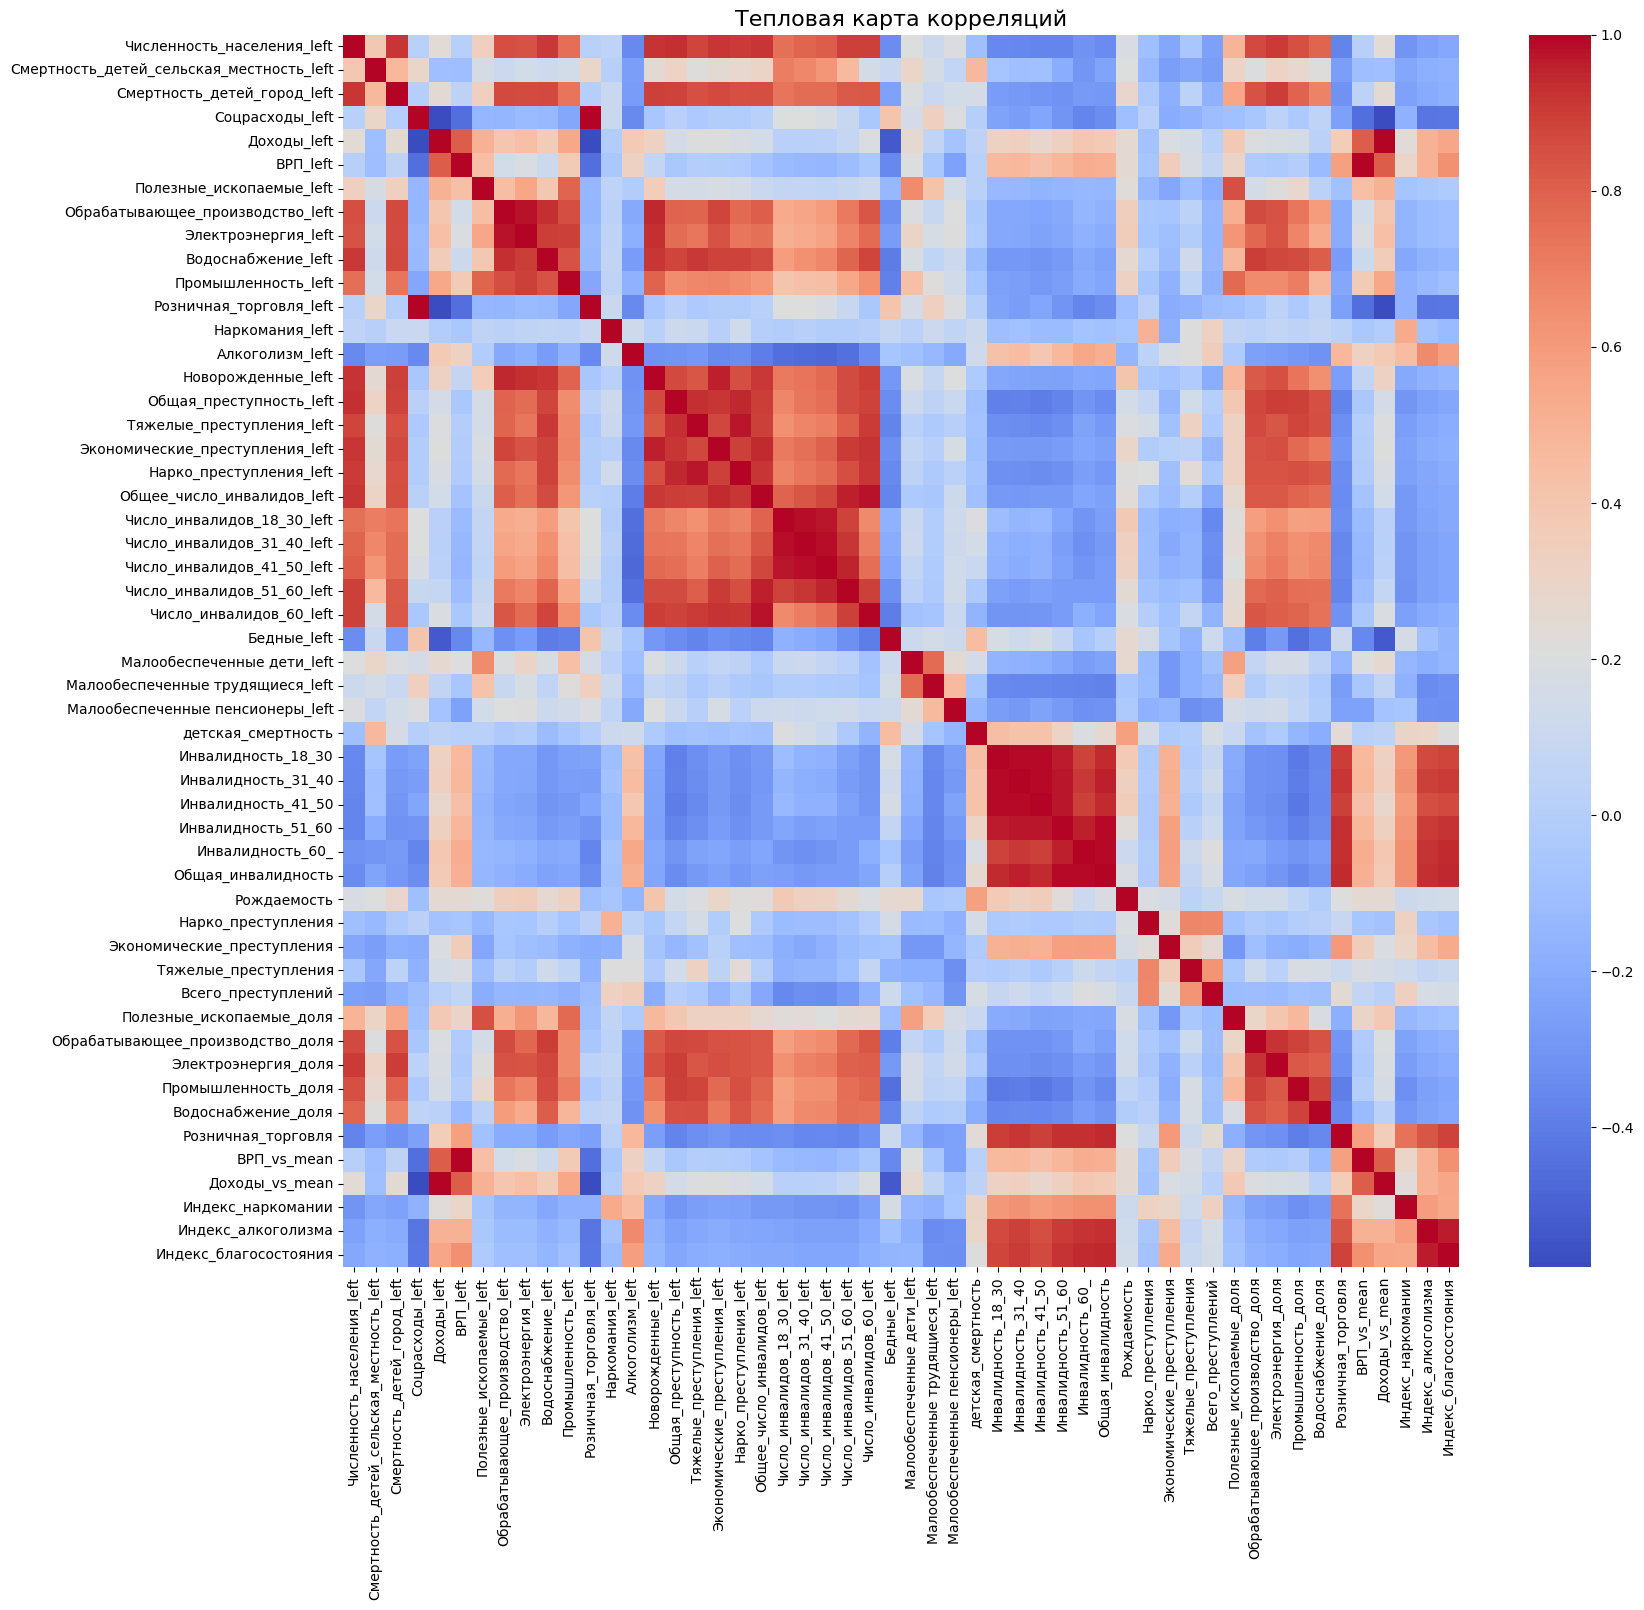

In [16706]:
# Выбираем только числовые столбцы
numeric_df = df_avg.select_dtypes(include=[np.number])
# Вычисляем корреляционную матрицу для числовых признаков. 
# чем ближе корреляция к ±1, тем сильнее связь
plt.figure(figsize=(18, 16))
#Строим тепловую карту, отображающую уровни корреляции между признаками.
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm", cbar=True)
plt.title("Тепловая карта корреляций", fontsize=16)
plt.show()

На основе тепловой карты мы можем сделать некоторые выводы: 

_Положительная корреляция_:
Численность населения_left имеет высокую положительную корреляцию с Соцрасходами_left, Бедными_left и Общей преступностью_left. Это может указывать на то, что в регионах с большей численностью населения также наблюдаются более высокие социальные расходы и более высокая преступность. Рождаемость_left сильно коррелирует с Малообеспеченными детьми_left. Это может отражать зависимость рождаемости от уровня благосостояния семей.

_Отрицательная корреляция_:
Соцрасходы_left имеют отрицательную корреляцию с Индексом алкоголизма и Числом инвалидов_18-30_left. Это свидетельствует о том, что регионы с высокими социальными расходами имеют меньшие значения алкоголизма и инвалидности среди молодого населения. ВРП_left имеет отрицательную корреляцию с Малообеспеченными трудящимися_left. Это может означать, что рост ВРП не всегда сопровождается увеличением числа малообеспеченных трудящихся.

Также отмечу _слабую корреляцию_, например, между Полезными ископаемыми_left и Розничной торговлей_left или Электроэнергией_left и Бедными_left. Эти взаимосвязи могут быть менее значимыми для анализа.

Далее удалю часть признаков с очень сильной и слабой корреляцией, постепенно уходя от абсолютных признаков.

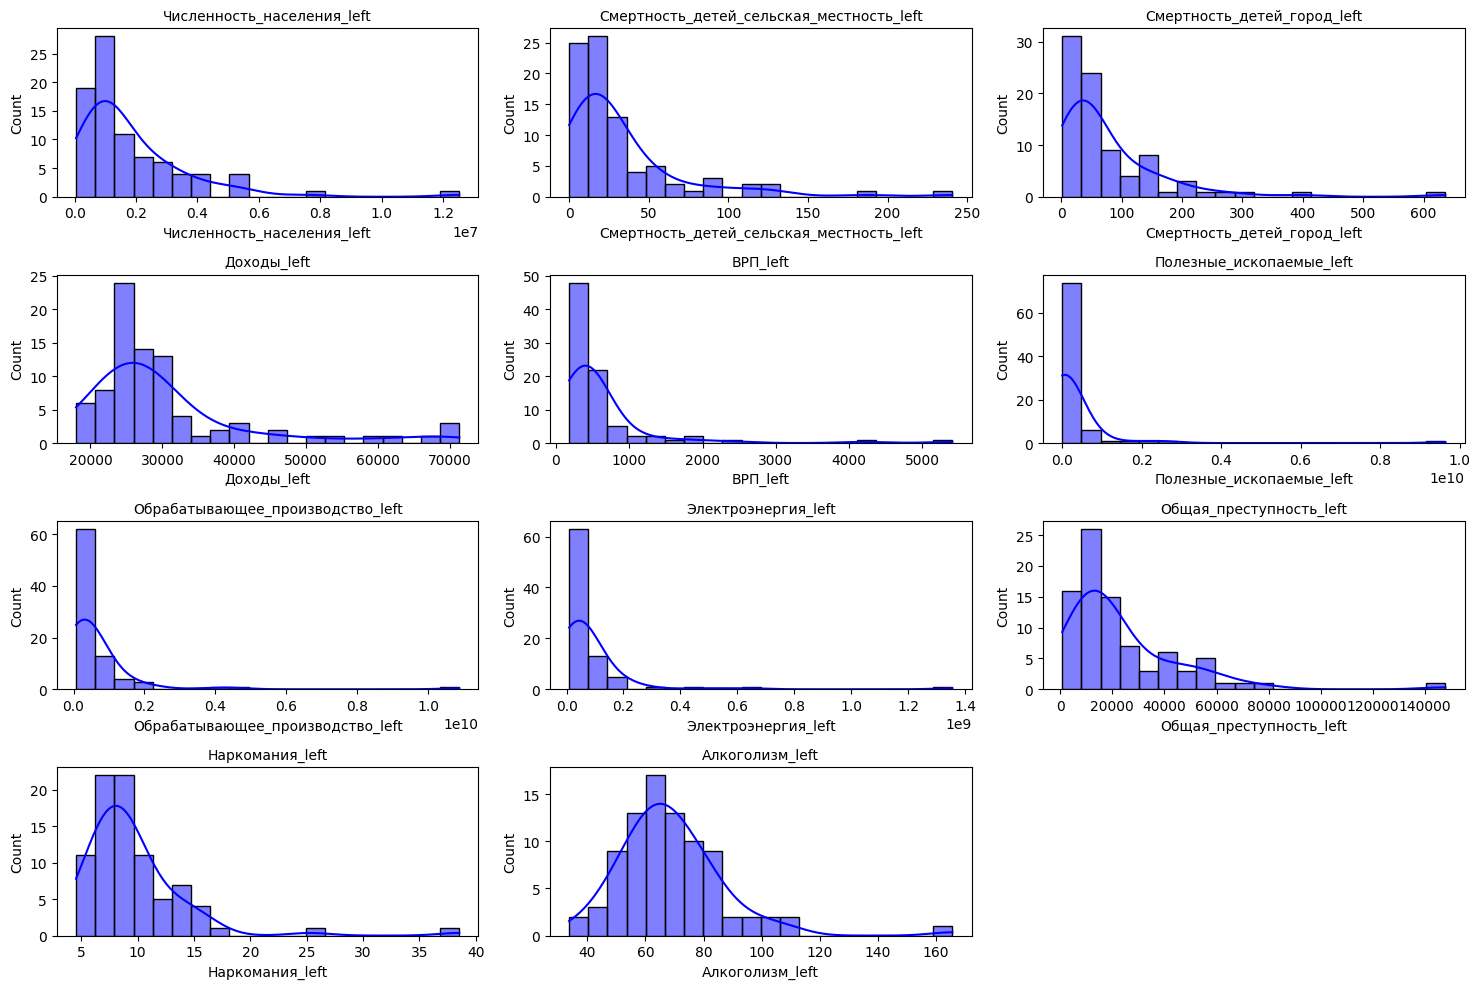

In [16570]:
# Анализ распределений основных абсолютных показателей
absolute_columns = [
    'Численность_населения_left', 'Смертность_детей_сельская_местность_left',
    'Смертность_детей_город_left', 'Доходы_left', 'ВРП_left', 'Полезные_ископаемые_left',
    'Обрабатывающее_производство_left', 'Электроэнергия_left', 'Общая_преступность_left',
    'Наркомания_left', 'Алкоголизм_left'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(absolute_columns):
    plt.subplot(4, 3, i + 1)#Сетка состоит из 4 строк и 3 столбцов, всего 12 мест под графики, 
    # i + 1: Номер позиции для текущего графика в этой сетке
    sns.histplot(numeric_df[col].dropna(), kde=True, bins=20, color='blue')#Строим гистограмму для данных в столбце col. 
    #df[col].dropna(): Убирает пропуски перед визуализацией
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

На основе графиков можно сделать следующие выводы о распределениях признаков: все абсолютные показатели в основном имеют правостороннее распределение, что указывает на наличие как средних значений в большинстве регионов, так и высоких отклонений в некоторых из них. Это может свидетельствовать о существенных различиях в уровне развития регионов и доступности ресурсов, а также о значительном влиянии отдельных территорий на общий тренд, т е отдельные территории могут вносить дисбаланс или значительное отклонение, влияя на общий вид распределения.
Уровень детской смертности в большинстве случаев низкий, но встречаются регионы с высокими показателями смертности, что может быть связано с различиями в уровне медицинского обслуживания и доступности услуг.
Большинство значений доходов населения сосредоточено вокруг низких и средних показателей, но есть отдельные регионы с очень высокими доходами, что объясняется высокой концентрацией ресурсов или наличием крупных предприятий.
Значительное число регионов имеет низкий ВРП, в то время как в некоторых регионах наблюдаются очень высокие значения.
Графики преступности, наркомании и алкоголизма показывают значительное количество высоких значений в определенных регионах. Это свидетельствует о нестабильной ситуации в некоторых территориях, где криминальная обстановка и социальные проблемы могут значительно превышать средние значения.

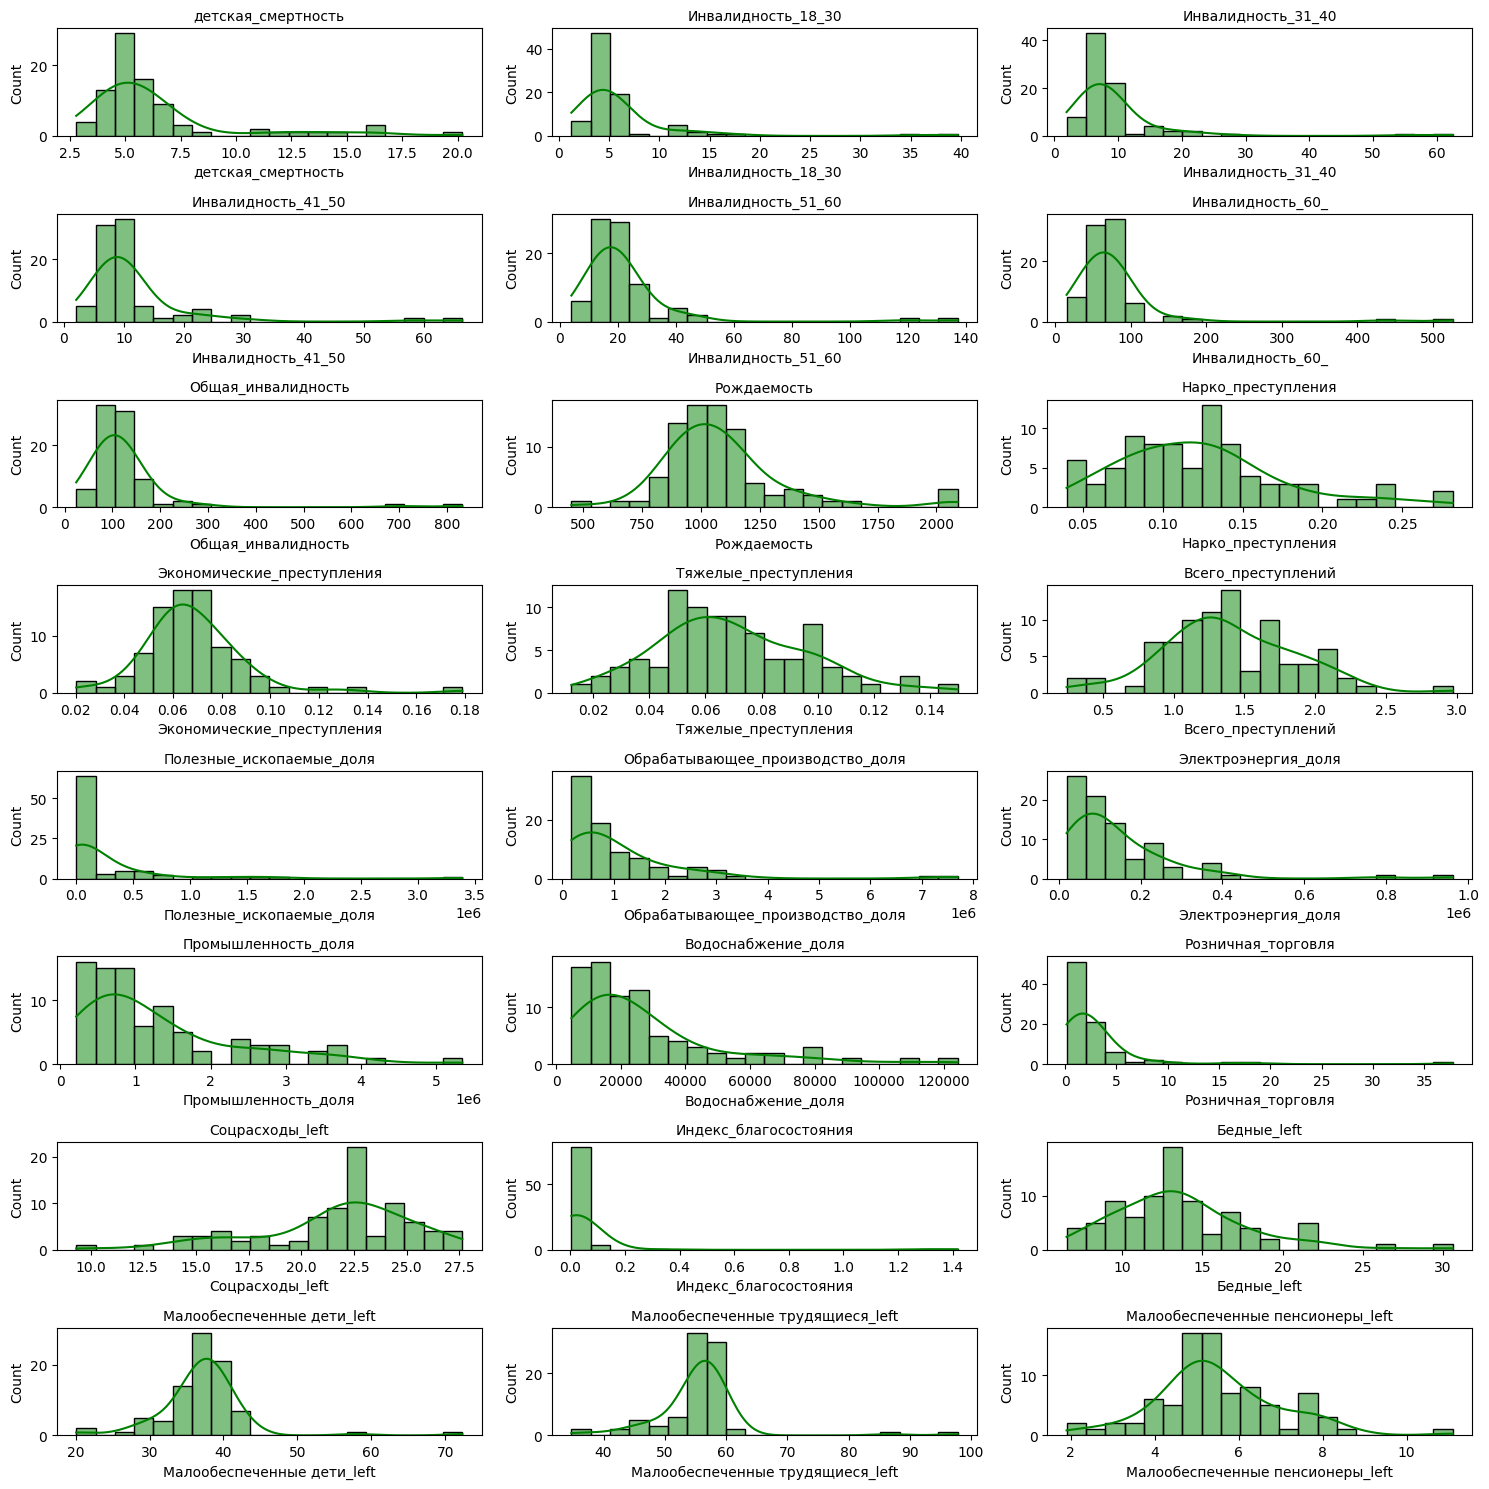

In [16571]:
# Анализ распределений относительных показателей
relative_columns = [
    'детская_смертность', 'Инвалидность_18_30', 'Инвалидность_31_40', 'Инвалидность_41_50',
    'Инвалидность_51_60', 'Инвалидность_60_', 'Общая_инвалидность', 'Рождаемость',
    'Нарко_преступления', 'Экономические_преступления', 'Тяжелые_преступления',
    'Всего_преступлений', 'Полезные_ископаемые_доля', 'Обрабатывающее_производство_доля',
    'Электроэнергия_доля', 'Промышленность_доля', 'Водоснабжение_доля', 
    'Розничная_торговля', 'Соцрасходы_left', 'Индекс_благосостояния', 'Бедные_left',
    'Малообеспеченные дети_left', 'Малообеспеченные трудящиеся_left', 'Малообеспеченные пенсионеры_left'
]

plt.figure(figsize=(15, 15))
for i, col in enumerate(relative_columns):
    plt.subplot(8, 3, i + 1)# 7 рядов и 3 колонки графиков
    sns.histplot(numeric_df[col].dropna(), kde=True, bins=20, color='green')
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()



Многие показатели относительных признаков также имеют правостороннее смещение, что говорит о наличии регионов с аномально высокими значениями (выбросами). Социальные показатели (бедность, инвалидность) и демографические (смертность, рождаемость) различаются по регионам неравномерно.
Доли секторов экономики (например, полезные ископаемые и промышленность) также указывают на сильные различия в развитии отдельных отраслей в регионах.

Требуется дополнительный анализ выбросов и корреляций между показателями для более глубокого понимания.

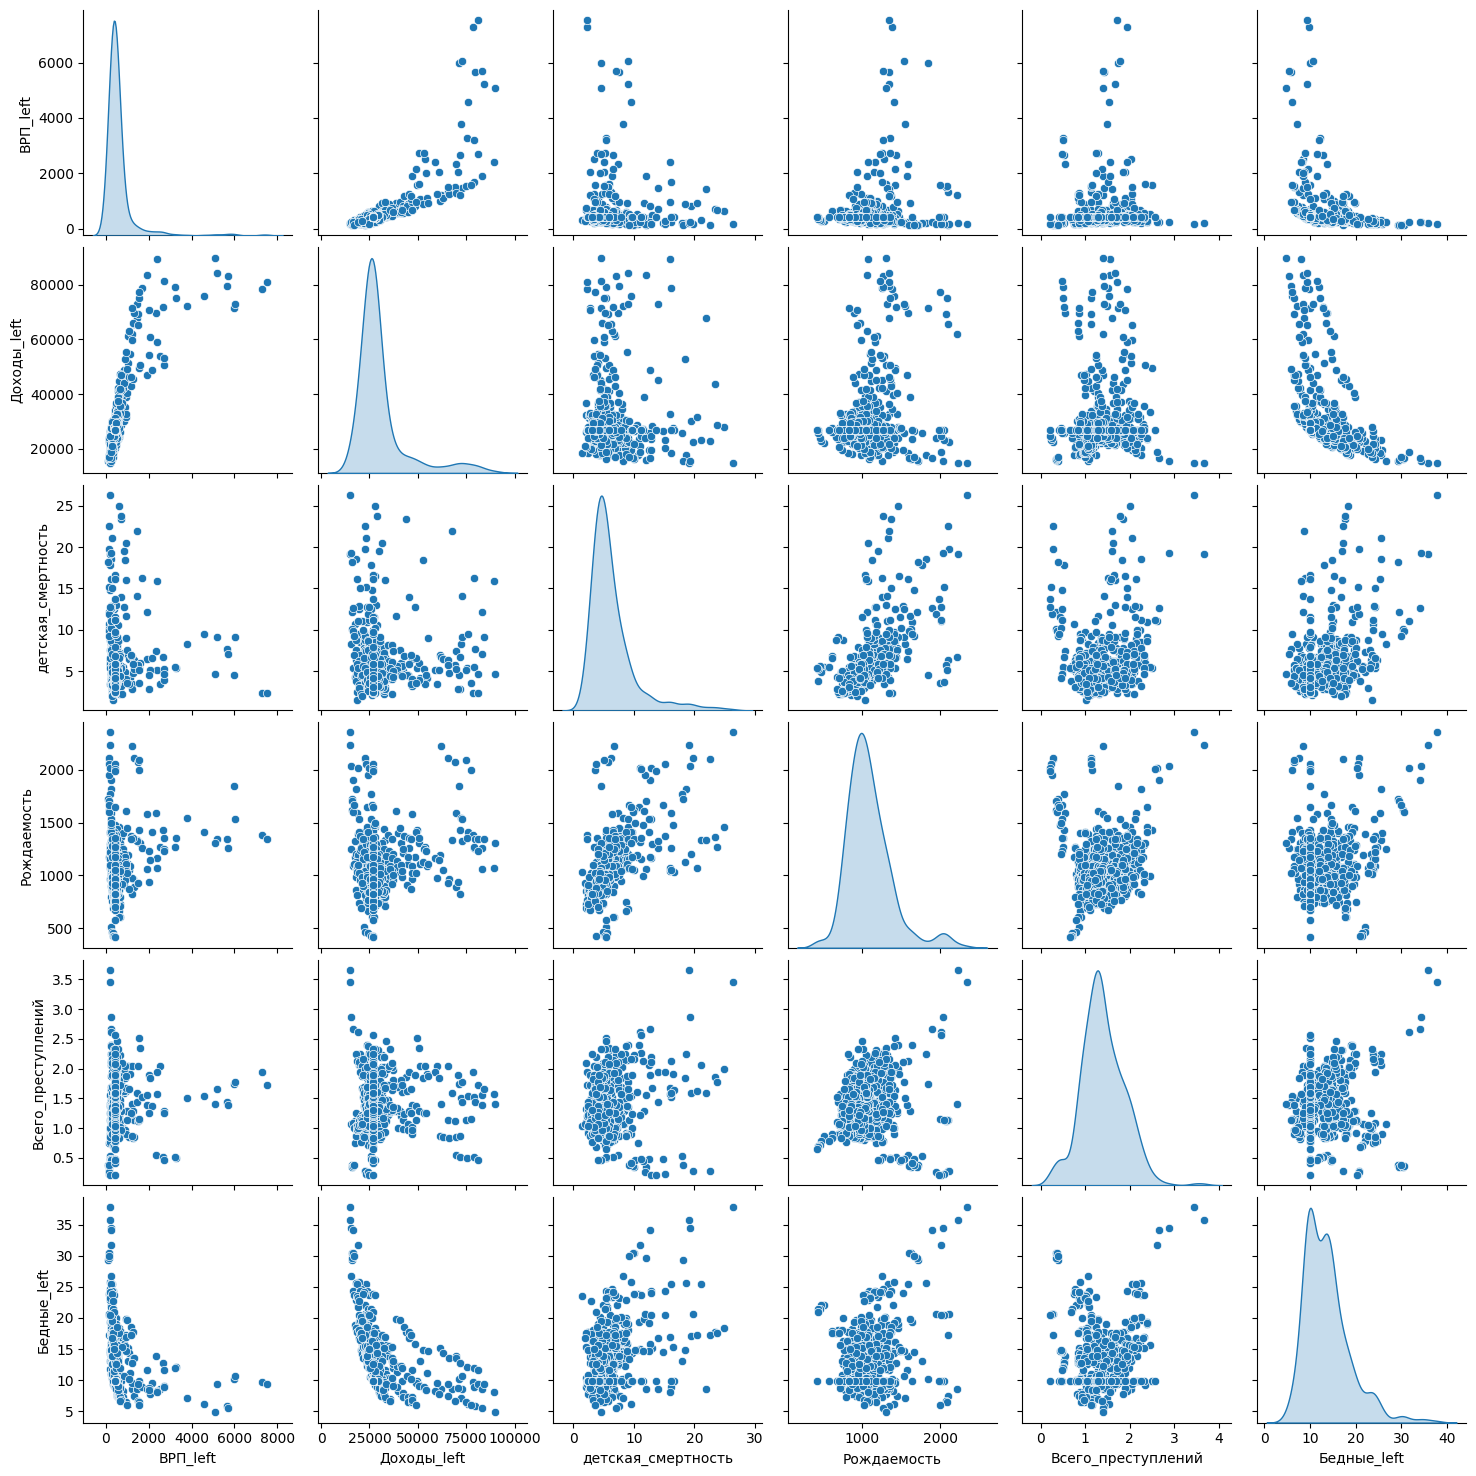

In [16572]:
# Парные графики для некоторых признаков
selected_columns = ['ВРП_left', 'Доходы_left', 'детская_смертность', 'Рождаемость', 'Всего_преступлений', 'Бедные_left']
sns.pairplot(df[selected_columns], diag_kind='kde', markers='o')
plt.show()

Парные графики очень наглядные и показывают взаимосвязи между экономическими, социальными и демографическими показателями.

_Корреляция между ВРП и доходами:_
ВРП_left и Доходы_left демонстрируют положительную корреляцию, т е чем выше ВРП региона, тем выше доходы населения. На графике четко видна линейная зависимость, что подтверждает экономическую логику.

_Влияние ВРП и доходов на бедность:_
Наблюдается обратная корреляция между ВРП_left и Бедные_left, а также между Доходы_left и Бедные_left. Это означает, что в регионах с высоким ВРП и доходами доля бедного населения ниже. Сгруппированные точки на графике показывают: чем ниже доходы и ВРП, тем выше бедность.

_Детская смертность:_
Детская_смертность имеет обратную связь с ВРП и доходами (чем выше ВРП и доходы, тем ниже смертность). На графиках виден разрыв: в регионах с низким ВРП и доходами показатель детской смертности сильно возрастает.

_Рождаемость и бедность:_
Между Рождаемость и Бедные_left есть слабая положительная зависимость. В бедных регионах рождаемость часто выше. Это может свидетельствовать о недостаточном уровне социальной защиты и образовании.

_Всего преступлений и экономические показатели:_
Всего_преступлений слабо коррелирует с ВРП и доходами, однако наблюдается незначительная положительная связь между уровнем преступности и бедностью. Регионы с более высокой долей бедного населения чаще сталкиваются с преступностью. Заметна разбросанность данных, что говорит о том, что преступность зависит и от других факторов, не включенных в эти графики.


__Распределения показателей:__
ВРП_left и Доходы_left имеют правостороннее смещение с большим числом выбросов (некоторые регионы значительно богаче остальных).
Детская смертность и Бедные_left также имеют асимметричное распределение, с регионами, где показатели заметно хуже среднего уровня.

__Ключевые наблюдения:__
Экономические показатели (ВРП и доходы) играют ключевую роль в снижении бедности и детской смертности.
В бедных регионах часто наблюдаются более высокие рождаемость и преступность, что указывает на взаимосвязь социальных и экономических проблем.
Заметные выбросы в данных свидетельствуют о существенном неравенстве между регионами.
Для улучшения ситуации в бедных регионах требуется комплексный подход: повышение доходов, поддержка семьи и снижение преступности.

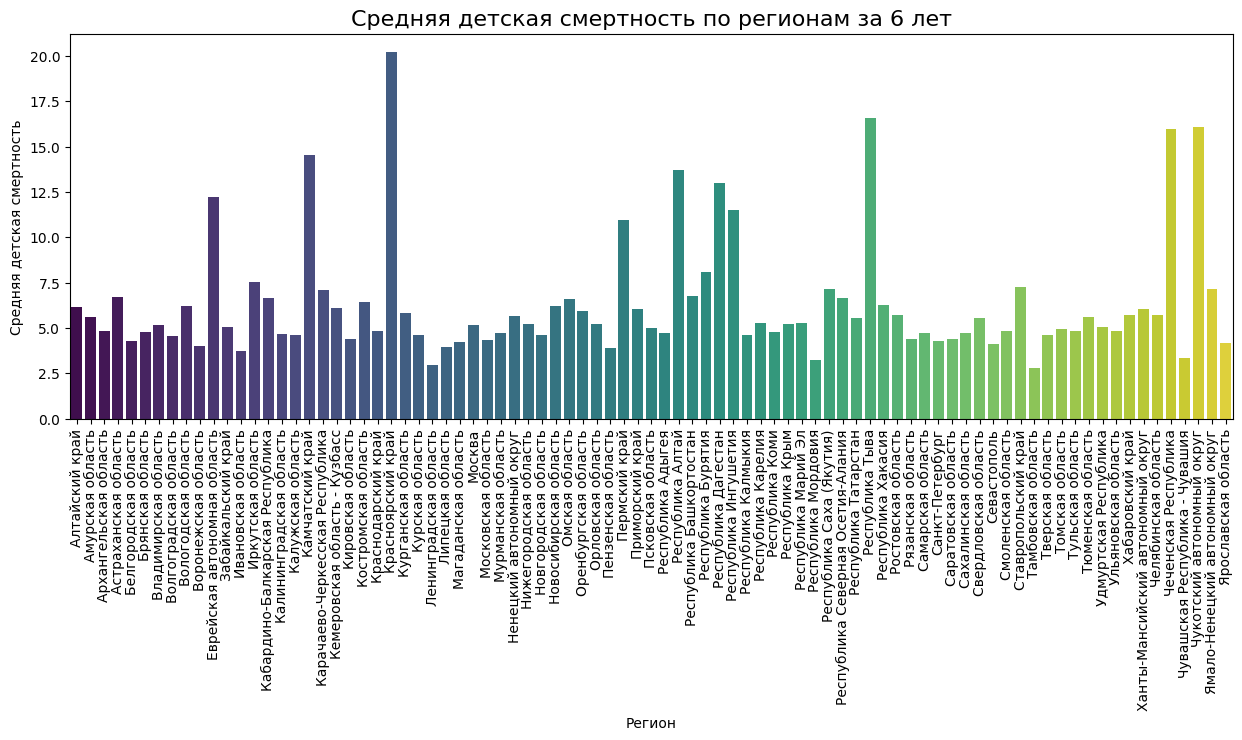

In [16573]:
# Анализ по регионам на примере детской смертности(среднее значение за 6 лет)
# Строим график
plt.figure(figsize=(15, 5))
sns.barplot(data=df_avg, x='Регион', y='детская_смертность', palette="viridis")
plt.xticks(rotation=90)
plt.title('Средняя детская смертность по регионам за 6 лет', fontsize=16)
plt.xlabel('Регион')
plt.ylabel('Средняя детская смертность')
plt.show()


Видим, что явно выделяются субьекты Сибирского и Дальневосточного федеральных округов, такие как: Красноярский край, республика Тыва и Чукотский АО, Камчатский край, а также Чеченская Республика. Скорее все причины такого явления: низкий социального-экономический уровень регионов, включая низкий уровень медицины, нехватка профессиональных медицинских кадров.

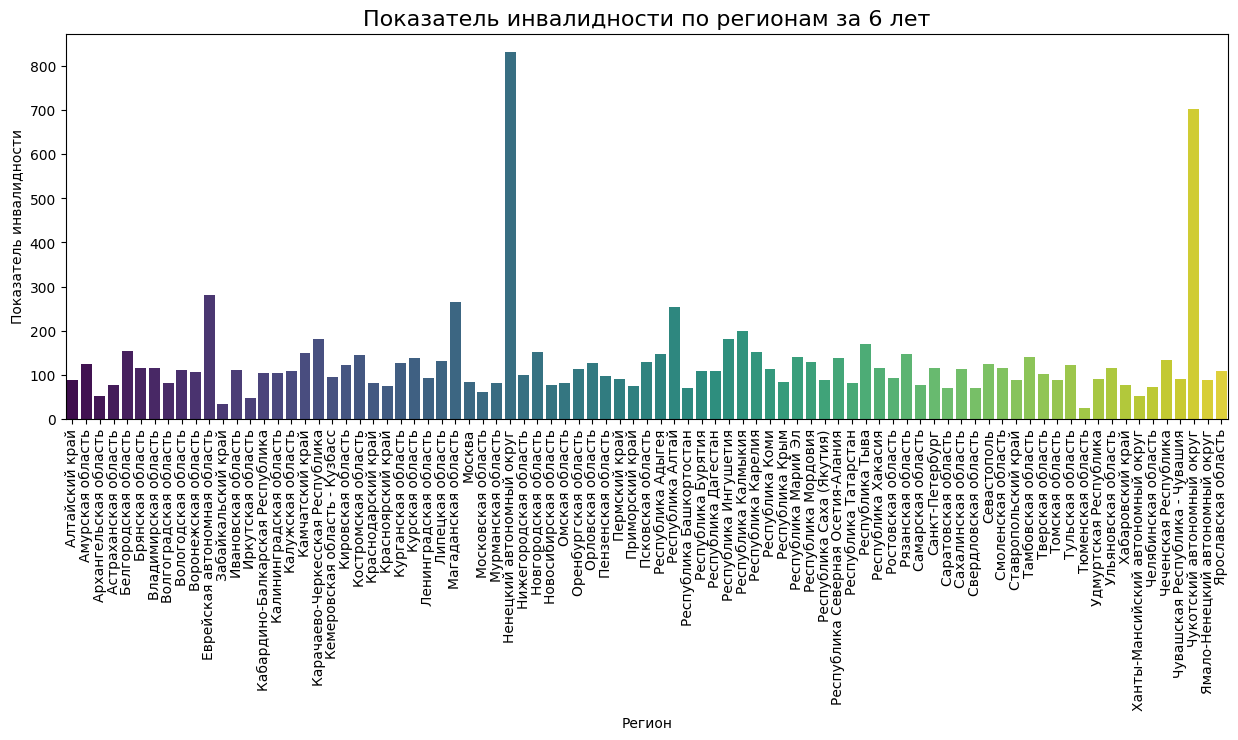

In [16574]:
# Анализ по регионам на примере общей инвалидности (среднее значение за 6 лет, на 100 тыс чел)
# Строим график
plt.figure(figsize=(15, 5))
sns.barplot(data=df_avg, x='Регион', y='Общая_инвалидность', palette="viridis")
plt.xticks(rotation=90)
plt.title('Показатель инвалидности по регионам за 6 лет', fontsize=16)
plt.xlabel('Регион')
plt.ylabel('Показатель инвалидности')
plt.show()

Здесь главными "лидерами" являются регионы опять таки Северного и Дальневосточного федеральных округов: Ненецкий АО и Чукотский АО. Причины очевидно все те же: низкий социальный уровень: плохое качество медицинский услуг, ограниченное количество медицинских центов, нехватка мед. персонала.

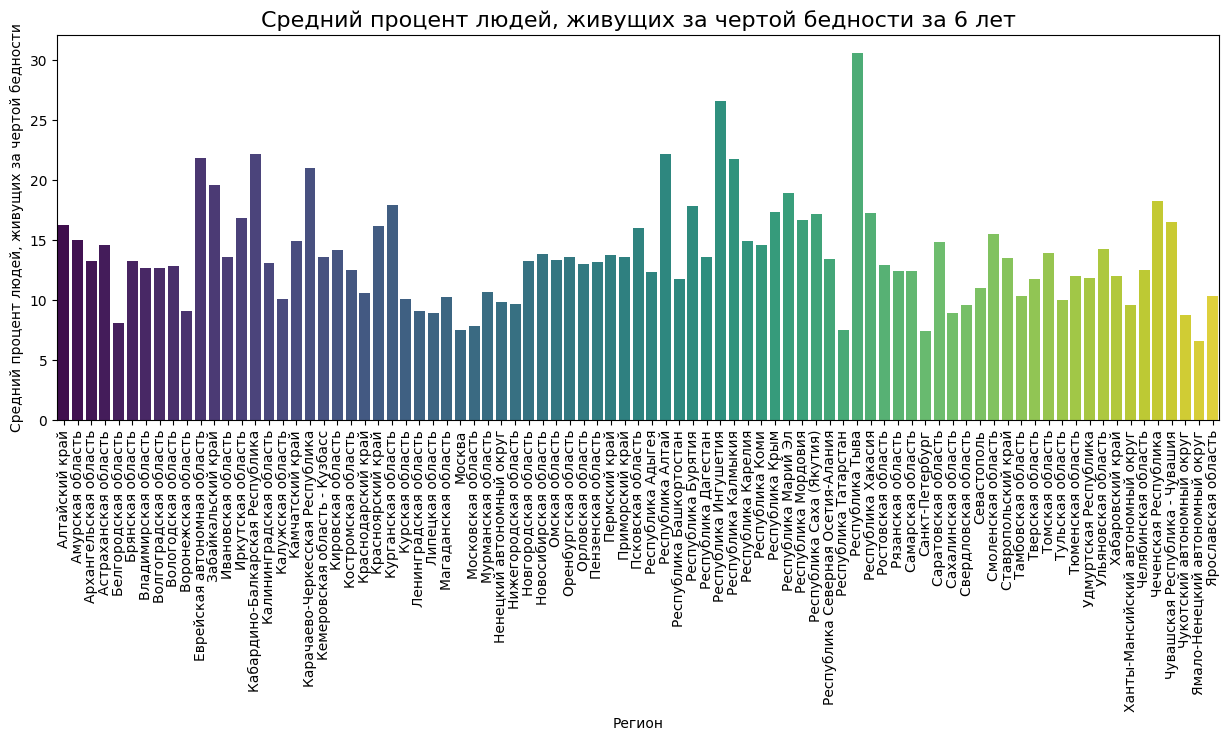

In [16575]:
# Анализ по регионам на примере детской смертности(среднее значение за 6 лет)
# Строим график
plt.figure(figsize=(15, 5))
sns.barplot(data=df_avg, x='Регион', y='Бедные_left', palette="viridis")
plt.xticks(rotation=90)
plt.title('Средний процент людей, живущих за чертой бедности за 6 лет', fontsize=16)
plt.xlabel('Регион')
plt.ylabel('Средний процент людей, живущих за чертой бедности')
plt.show()

На графике видим, что самой большой процент людей, живущих за чертой бедности, принадлежит Республика Тыва (Сибирского федеральный округ) и далее Республика Ингушетия (Северо-Кавказский федеральный округ). Очевидно регионы этих округов должны попасть в дальнейшем в один кластер, т к их отличительной чертой является: верхние позиции в антирейтинге демографической статистики.

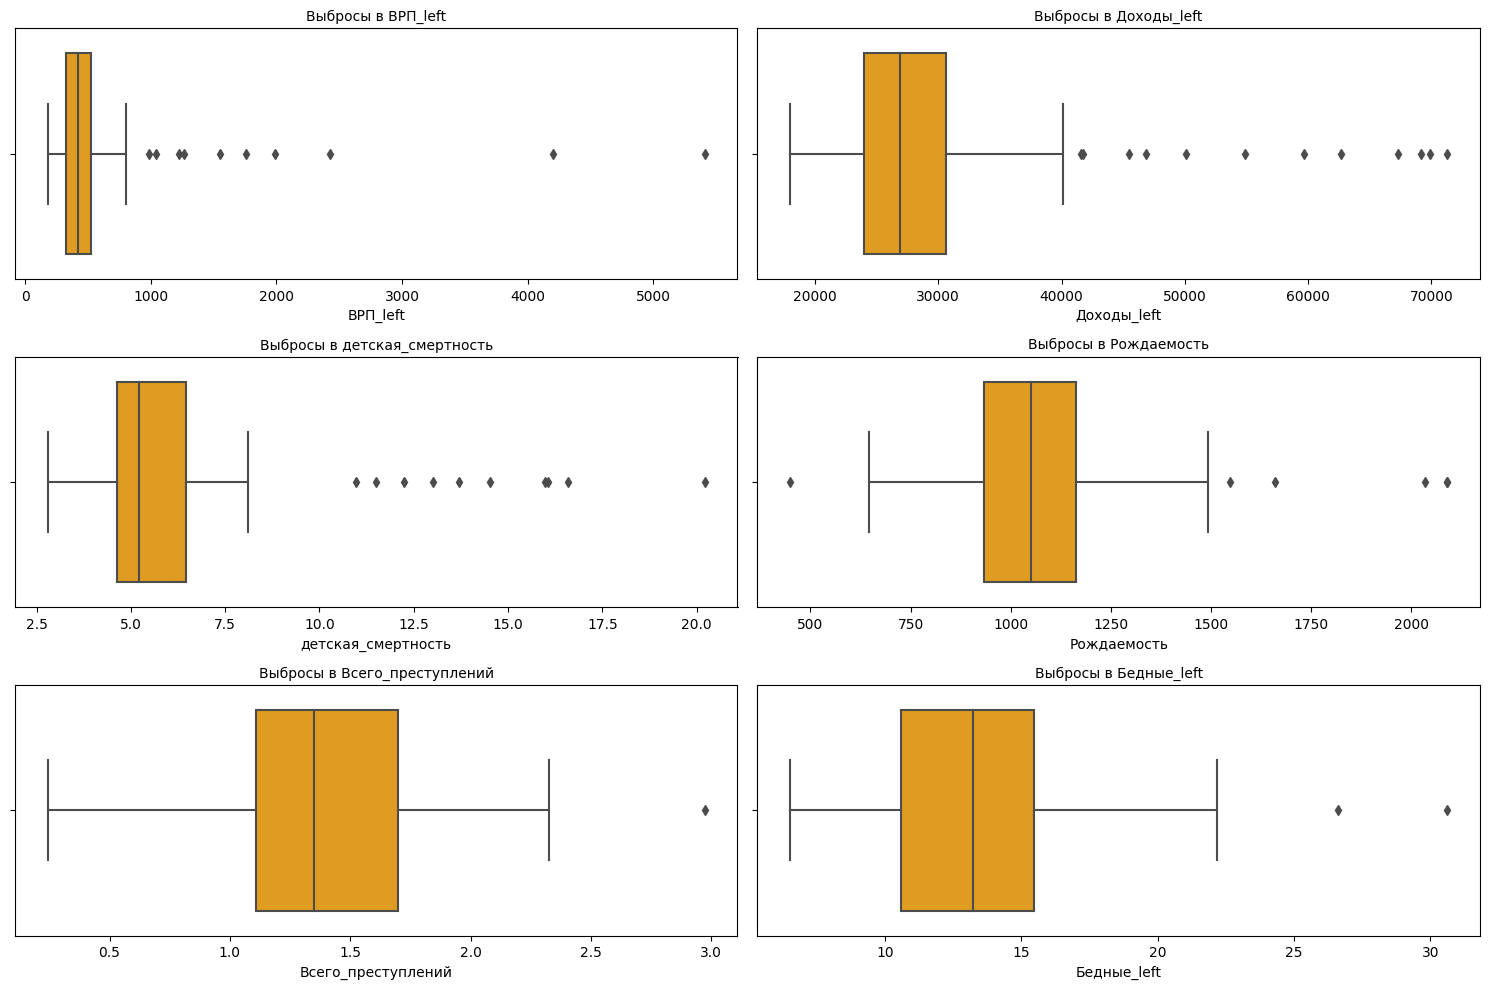

In [16576]:
# Выявление выбросов для ключевых признаков
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df_avg[col], color='orange')
    plt.title(f'Выбросы в {col}', fontsize=10)
plt.tight_layout()
plt.show()


__Анализ выбросов:__

ВРП_left (валовой региональный продукт): имеются значительные выбросы в правой части, что говорит о том, что небольшое количество регионов имеет очень высокий ВРП, что значительно превышает медиану остальных. Присутствует сильная неоднородность распределения ВРП по регионам: существует экономически развитая группа регионов, выделяющаяся на фоне остальных.

Доходы_left: наблюдаются множественные выбросы в правой части. В некоторых регионах доходы населения значительно выше среднего уровня.
Как и в случае с ВРП, это указывает на экономическое неравенство между регионами.

Детская_смертность: выбросы справа, что говорит о высокой смертности в отдельных регионах. Большинство регионов имеет низкие показатели детской смертности, однако несколько регионов существенно отклоняются от нормы. Эти регионы требуют дополнительного внимания и анализа причин высоких показателей смертности.

Рождаемость: также выбросы в правой части, что означает высокую рождаемость в отдельных регионах. Большинство регионов имеет умеренные показатели рождаемости, но несколько регионов заметно выделяются.

Всего_преступлений: большинство регионов имеют низкий или умеренный уровень преступности, но присутствие выбросов справа, указывает на регионы с высоким уровнем преступности.

Бедные_left (доля бедного населения): выбросы справа, что свидетельствует о регионах с аномально высокой долей бедного населения.
Большинство регионов имеет умеренные показатели бедности, но отдельные регионы значительно отстают.

__Общие выводы:__

- Неоднородность распределения: для большинства показателей можно заметить, что большая часть данных сосредоточена ближе к медиане, но есть регионы с аномально высокими значениями.
- Регионы с выбросами требуют приоритетного внимания: высокая детская смертность, бедность и преступность требуют социальной поддержки и экономических реформ.
- Высокие ВРП и доходы указывают на регионы-лидеры, которые можно рассматривать как примеры успешного экономического развития.

Таким образом, график наглядно показывает наличие выбросов и значительное различие между регионами по ключевым социально-экономическим показателям. Особое выделяются регионам с аномально высокими показателями бедности, смертности и преступности.

In [16723]:
df_avg.columns

Index(['Регион', 'Численность_населения_left',
       'Смертность_детей_сельская_местность_left',
       'Смертность_детей_город_left', 'Соцрасходы_left', 'Доходы_left',
       'ВРП_left', 'Полезные_ископаемые_left',
       'Обрабатывающее_производство_left', 'Электроэнергия_left',
       'Водоснабжение_left', 'Промышленность_left', 'Розничная_торговля_left',
       'Наркомания_left', 'Алкоголизм_left', 'Новорожденные_left',
       'Общая_преступность_left', 'Тяжелые_преступления_left',
       'Экономические_преступления_left', 'Нарко_преступления_left',
       'Общее_число_инвалидов_left', 'Число_инвалидов_18_30_left',
       'Число_инвалидов_31_40_left', 'Число_инвалидов_41_50_left',
       'Число_инвалидов_51_60_left', 'Число_инвалидов_60_left', 'Бедные_left',
       'Малообеспеченные дети_left', 'Малообеспеченные трудящиеся_left',
       'Малообеспеченные пенсионеры_left', 'детская_смертность',
       'Инвалидность_18_30', 'Инвалидность_31_40', 'Инвалидность_41_50',
       'Инвалид

In [16724]:
cleaned_df = df_avg.copy()

In [16725]:
# Список признаков для удаления
columns_to_drop = [
    'Численность_населения_left',
    'Смертность_детей_сельская_местность_left',
    'Смертность_детей_город_left',
    'Розничная_торговля_left',
    'Общее_число_инвалидов_left',
    'Число_инвалидов_18_30_left', 
    'Число_инвалидов_31_40_left',
    'Число_инвалидов_41_50_left',
    'Число_инвалидов_51_60_left', 
    'Число_инвалидов_60_left',
    'Бедные_left',
    'Полезные_ископаемые_left',
    'Обрабатывающее_производство_left',
    'Водоснабжение_left',
    'Промышленность_left',
    'Новорожденные_left',
    'Общая_преступность_left',
    'Тяжелые_преступления_left',
    'Электроэнергия_left',
    'Наркомания_left', 
    'Алкоголизм_left',
    'Экономические_преступления_left',
    'Нарко_преступления_left',
    'Инвалидность_18_30', 'Инвалидность_31_40',
    'Инвалидность_41_50',
    'Инвалидность_51_60',
    'Инвалидность_60_',
    'Водоснабжение_доля',
    'Индекс_алкоголизма',
    'Индекс_благосостояния',
    'Обрабатывающее_производство_доля',
    'ВРП_vs_mean',
    'Доходы_vs_mean',
    'Розничная_торговля'
    ]

# Удаление колонок
cleaned_df = cleaned_df.drop(columns=columns_to_drop, axis=1)


In [16726]:
cleaned_df.columns

Index(['Регион', 'Соцрасходы_left', 'Доходы_left', 'ВРП_left',
       'Малообеспеченные дети_left', 'Малообеспеченные трудящиеся_left',
       'Малообеспеченные пенсионеры_left', 'детская_смертность',
       'Общая_инвалидность', 'Рождаемость', 'Нарко_преступления',
       'Экономические_преступления', 'Тяжелые_преступления',
       'Всего_преступлений', 'Полезные_ископаемые_доля', 'Электроэнергия_доля',
       'Промышленность_доля', 'Индекс_наркомании'],
      dtype='object')

<AxesSubplot: >

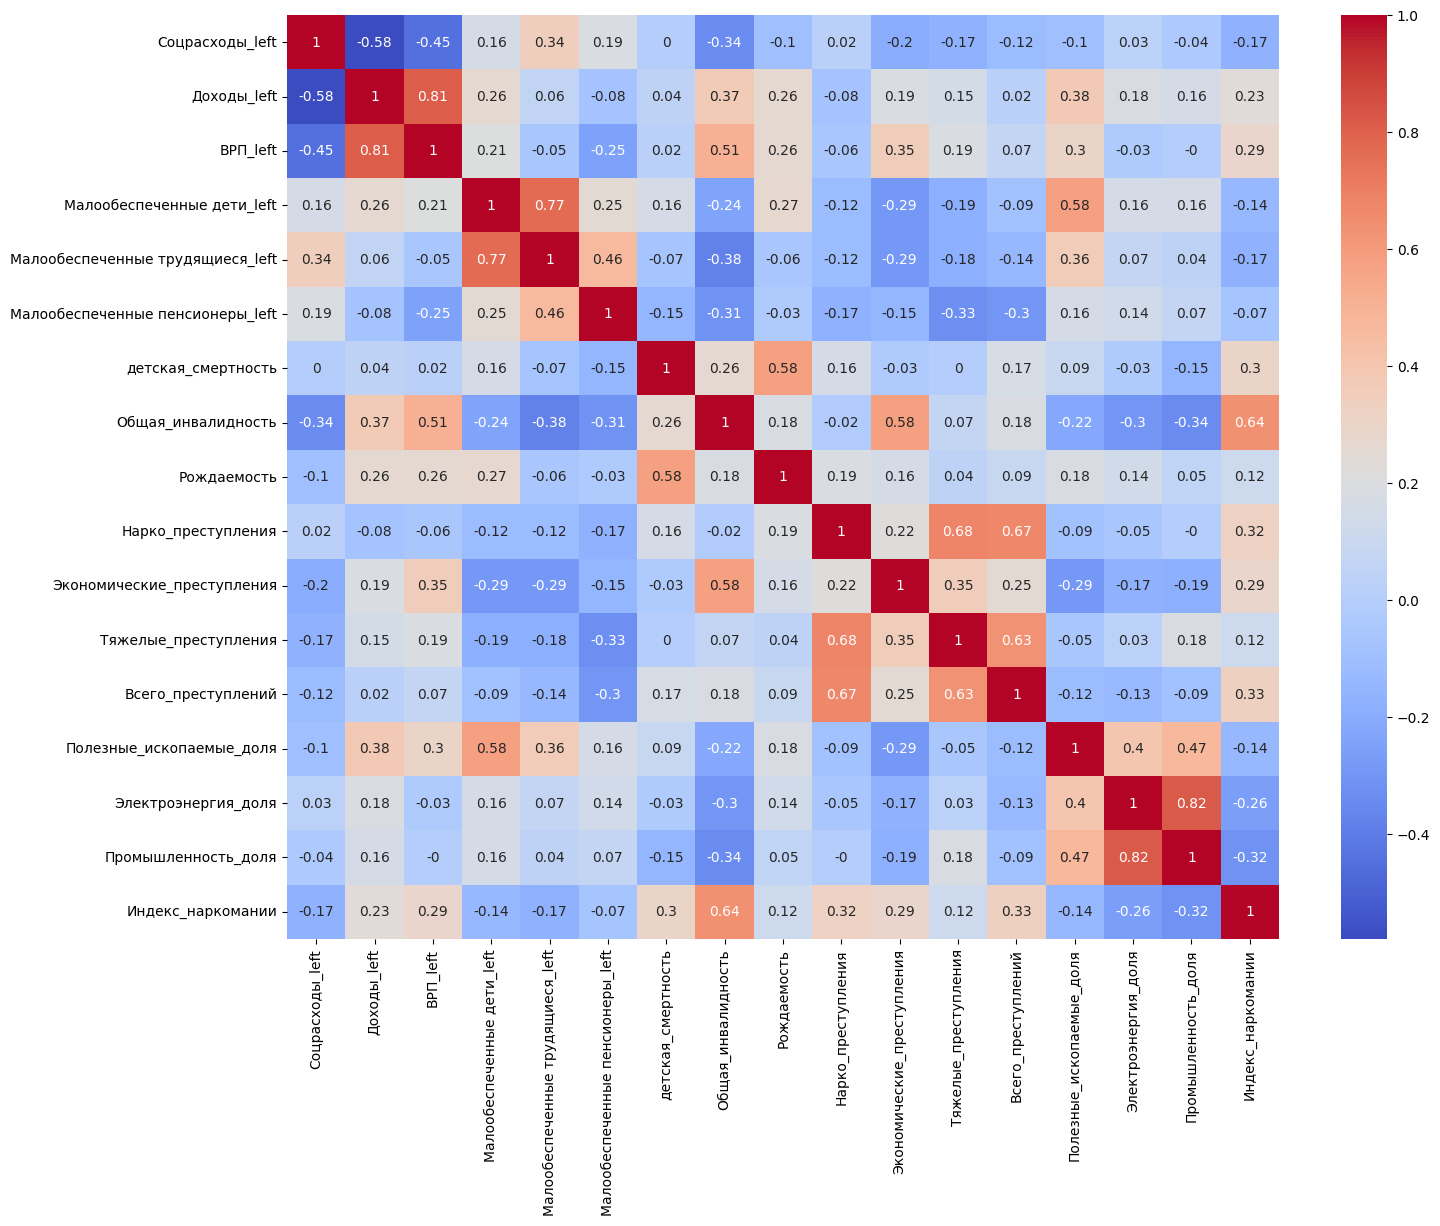

In [16727]:
numeric_df = cleaned_df.select_dtypes(include=[np.number])
plt.figure(figsize=(16, 12))
sns.heatmap(numeric_df.corr().round(decimals=2), annot=True, cmap="coolwarm", cbar=True)

## 3. Кластеризация 

### 3.1 Подготовка к кластеризации - стандартизация

Необходимо провести стандартизацию или нормализацию признаков, чтобы можно было равнозначно их оценивать.

In [16728]:
# Исключаем категориальные и строковые данные
numeric_df = cleaned_df.select_dtypes(include=['float64', 'int64'])  # Только числовые данные
# Инициализируем StandardScaler
scaler = preprocessing.StandardScaler()
# Применение стандартизации
scaled_data = scaler.fit_transform(numeric_df)
# Преобразование обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)
# Добавляем категориальные переменные обратно
categorical_columns = ['Регион']  # Явно указываем, какие колонки добавить обратно
scaled_df = pd.concat([cleaned_df[categorical_columns].reset_index(drop=True), scaled_df], axis=1)
# Результат
scaled_df.head()



Регион  Соцрасходы_left  Доходы_left  ВРП_left   
0         Алтайский край         1.492470    -0.603846 -0.444791  \
1       Амурская область         0.792516    -0.009245 -0.227041   
2  Архангельская область         0.128922     2.407766  0.564026   
3   Астраханская область         1.160674    -0.527068 -0.175714   
4   Белгородская область        -1.480065    -0.020568 -0.086934   

   Малообеспеченные дети_left  Малообеспеченные трудящиеся_left   
0                   -0.077494                          0.291603  \
1                   -0.007074                          0.280558   
2                    3.351409                          5.597899   
3                    0.206894                          0.167893   
4                   -1.756735                         -2.759185   

   Малообеспеченные пенсионеры_left  детская_смертность  Общая_инвалидность   
0                          0.028472           -0.042202           -0.361322  \
1                         -0.205736           -0.216352           -0.031093   
2                          3.742348           -0.445578           -0.682768   
3                         -0.529167            0.124250           -0.467121   
4                          0.039625           -0.621981            0.238803   

   Рождаемость  Нарко_преступления  Экономические_преступления   
0    -0.407299            0.327694                   -1.098380  \
1    -0.013712            2.165757                   -0.533843   
2    -0.508103           -1.624655                   -1.200067   
3     0.304310            0.537826                    0.856748   
4    -0.667046           -1.073094                   -0.937980   

   Тяжелые_преступления  Всего_преступлений  Полезные_ископаемые_доля   
0             -0.135111            0.639247                 -0.429741  \
1              0.185149            1.982448                 -0.191683   
2             -1.248083           -1.199968                  0.515967   
3              0.234162           -0.110534                  0.367639   
4             -1.308591           -1.096680                 -0.067710   

   Электроэнергия_доля  Промышленность_доля  Индекс_наркомании  
0             0.165799             0.173629          -0.293610  
1            -0.366964            -0.776729           0.143531  
2            -0.168038            -0.396519          -0.370040  
3            -0.527196            -0.450907          -0.317778  
4            -0.596004             0.136995          -0.361036

In [16729]:
#Проверим, все ли данные в нормальном виде после стандартизации (среднее должно быть равно 0, стандартное отклонение - 1). 
scaled_df.describe()


Соцрасходы_left   Доходы_left      ВРП_left   
count     8.500000e+01  8.500000e+01  8.500000e+01  \
mean     -4.055579e-16 -1.312675e-16 -5.714383e-17   
std       1.005935e+00  1.005935e+00  1.005935e+00   
min      -3.357216e+00 -1.059136e+00 -5.752244e-01   
25%      -2.983230e-01 -5.588182e-01 -3.881422e-01   
50%       1.652834e-01 -3.173416e-01 -2.537251e-01   
75%       6.743415e-01 -9.245483e-03 -1.196229e-01   
max       1.642461e+00  3.370512e+00  6.320626e+00   

       Малообеспеченные дети_left  Малообеспеченные трудящиеся_left   
count                8.500000e+01                      8.500000e+01  \
mean                -6.227045e-16                     -2.288366e-15   
std                  1.005935e+00                      1.005935e+00   
min                 -2.777822e+00                     -2.759185e+00   
25%                 -3.591728e-01                     -2.032386e-01   
50%                  9.043049e-02                      1.303378e-01   
75%                  2.962730e-01                      2.584665e-01   
max                  5.715889e+00                      5.597899e+00   

       Малообеспеченные пенсионеры_left  детская_смертность   
count                      8.500000e+01        8.500000e+01  \
mean                       3.859658e-16       -1.462882e-16   
std                        1.005935e+00        1.005935e+00   
min                       -2.413986e+00       -1.075556e+00   
25%                       -5.068610e-01       -5.171567e-01   
50%                       -2.057360e-01       -3.367698e-01   
75%                        5.191947e-01        4.303410e-02   
max                        3.742348e+00        4.239548e+00   

       Общая_инвалидность   Рождаемость  Нарко_преступления   
count        8.500000e+01  8.500000e+01        8.500000e+01  \
mean        -3.004133e-17 -5.054780e-16       -2.050647e-16   
std          1.005935e+00  1.005935e+00        1.005935e+00   
min         -9.412703e-01 -2.393308e+00       -1.624655e+00   
25%         -4.098183e-01 -5.848875e-01       -7.333065e-01   
50%         -1.628501e-01 -1.443251e-01       -6.406116e-02   
75%          3.906489e-02  2.747552e-01        3.478438e-01   
max          6.466631e+00  3.750040e+00        3.072565e+00   

       Экономические_преступления  Тяжелые_преступления  Всего_преступлений   
count                8.500000e+01          8.500000e+01        8.500000e+01  \
mean                -7.314411e-17         -1.286553e-16        7.120121e-16   
std                  1.005935e+00          1.005935e+00        1.005935e+00   
min                 -2.229016e+00         -2.161855e+00       -2.470947e+00   
25%                 -5.119282e-01         -6.842490e-01       -6.225480e-01   
50%                 -1.661854e-01         -1.351105e-01       -1.010221e-01   
75%                  3.416226e-01          6.715999e-01        6.420444e-01   
max                  5.118389e+00          3.029664e+00        3.370488e+00   

       Полезные_ископаемые_доля  Электроэнергия_доля  Промышленность_доля   
count              8.500000e+01         8.500000e+01         8.500000e+01  \
mean              -9.861393e-17         1.071039e-16         3.526591e-17   
std                1.005935e+00         1.005935e+00         1.005935e+00   
min               -4.714508e-01        -8.612838e-01        -1.031293e+00   
25%               -4.619613e-01        -5.945448e-01        -6.733283e-01   
50%               -4.099192e-01        -3.093897e-01        -4.091839e-01   
75%               -1.375983e-01         3.444480e-01         3.355117e-01   
max                6.213629e+00         5.574948e+00         3.788529e+00   

       Индекс_наркомании  
count       8.500000e+01  
mean        5.877651e-18  
std         1.005935e+00  
min        -4.580347e-01  
25%        -3.506903e-01  
50%        -2.618574e-01  
75%        -6.159197e-02  
max         7.541853e+00

## 3.2 baseline

Будем использовать самый популярный метод кластеризации: K-means в сочетании с коэффициентом силуэта.

In [16730]:
# Выбираем только числовые столбцы из scaled_df
numeric_scaled_df = scaled_df.select_dtypes(include=[np.number])
kmeans_sil = []

for i in range(3, 11):# Определим диапазон количества кластеров
    kmeans = KMeans(n_clusters=i, n_init=50, max_iter = 300, random_state=42)
    kmeans.fit(numeric_scaled_df)# Подставляем стандартизированные данные
    # подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    sil_score = silhouette_score(numeric_scaled_df, kmeans.labels_)
    kmeans_sil.append((i,sil_score))
# Преобразуем результаты в DataFrame     
kmeans_sil = pd.DataFrame(kmeans_sil, columns=['number_of_cluster', 'sil_score'])
# Сортировка по метрике силуэта
result = kmeans_sil.sort_values(by='sil_score', ascending=False)
result

number_of_cluster  sil_score
0                  3   0.419592
1                  4   0.207719
2                  5   0.201076
4                  7   0.195852
3                  6   0.195064
6                  9   0.183159
5                  8   0.162461
7                 10   0.151942

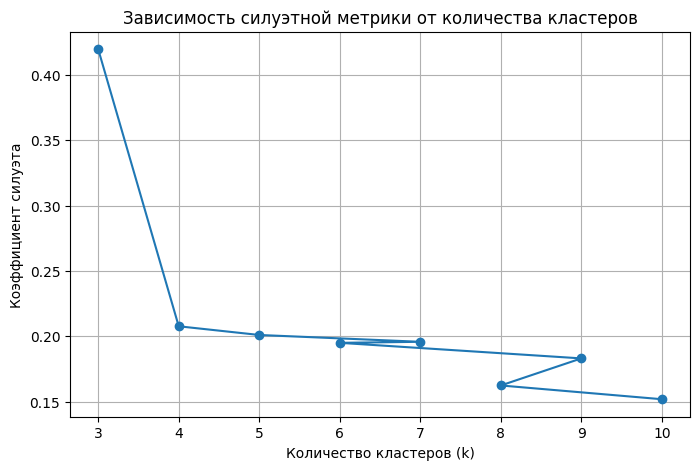

In [16731]:
# Построим график метрики силуэта
plt.figure(figsize=(8, 5))
plt.plot(result['number_of_cluster'], result['sil_score'], marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Коэффициент силуэта')
plt.title('Зависимость силуэтной метрики от количества кластеров')
plt.grid()
plt.show()

Максимальный коэффицинт силуэта достигает при трех кластерах. 

In [16732]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=50, random_state=42)
# Запишем в наш датасет значения кластеризации
scaled_df['KMeans'] = kmeans.fit_predict(numeric_scaled_df)
scaled_df['KMeans'].value_counts()

KMeans
0    74
1     9
2     2
Name: count, dtype: int64

Посмотрим же как распределились регионы по кластерам.

In [16587]:
# Фильтруем данные, выбирая строки с KMeans == 0 и убираем дубликаты(unique())
scaled_df_0 = scaled_df[scaled_df['KMeans'] == 0]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 0
print("Регионы в кластере 0:")
print("\n".join(scaled_df_0))


Регионы в кластере 0:
Алтайский край
Амурская область
Астраханская область
Белгородская область
Брянская область
Владимирская область
Волгоградская область
Вологодская область
Воронежская область
Забайкальский край
Ивановская область
Иркутская область
Кабардино-Балкарская Республика
Калининградская область
Калужская область
Карачаево-Черкесская Республика
Кемеровская область - Кузбасс
Кировская область
Костромская область
Краснодарский край
Красноярский край
Курганская область
Курская область
Ленинградская область
Липецкая область
Москва
Московская область
Мурманская область
Нижегородская область
Новгородская область
Новосибирская область
Омская область
Оренбургская область
Орловская область
Пензенская область
Пермский край
Приморский край
Псковская область
Республика Адыгея
Республика Башкортостан
Республика Бурятия
Республика Дагестан
Республика Ингушетия
Республика Калмыкия
Республика Карелия
Республика Коми
Республика Крым
Республика Марий Эл
Республика Мордовия
Республика Саха (Як

In [16588]:
# Фильтруем данные, выбирая строки с KMeans == 1 и убираем дубликаты(unique())
scaled_df_1 = scaled_df[scaled_df['KMeans'] == 1]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 1
print("Регионы в кластере 1:")
print("\n".join(scaled_df_1))


Регионы в кластере 1:
Еврейская автономная область
Камчатский край
Магаданская область
Ненецкий автономный округ
Республика Алтай
Республика Тыва
Сахалинская область
Чукотский автономный округ
Ямало-Ненецкий автономный округ


In [16589]:
# Фильтруем данные, выбирая строки с KMeans == 2 и убираем дубликаты(unique())
scaled_df_2 = scaled_df[scaled_df['KMeans'] == 2]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 2
print("Регионы в кластере 2:")
print("\n".join(scaled_df_2))


Регионы в кластере 2:
Архангельская область
Тюменская область


Видим, что большинство регионов отнесено к кластеру 0. Также не стал сюрпризов кластер 1, большинство регионов которого относятся к Дальневосточному федеральну округу. Эти регионы еще на этапе разведывательного анализа явно выделялись низкими показателями экономической и демографической статистики. Интересно выделение в отдельный кластер двух субъектов РФ: Тюменской и Архангельской областей, которые являются сложноустроенными субъектами Российской Федерации, в состав которых входят автономные округа, обладающие особым статусом и полномочиями.


Попробуем также воспользоваться методом локтя для определения оптимального количества кластеров.

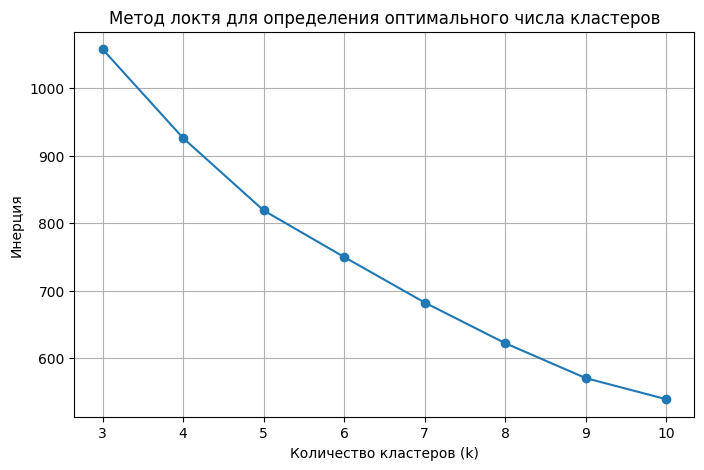

In [16733]:
# Выбираем только числовые столбцы из scaled_df
numeric_scaled_df = scaled_df.select_dtypes(include=[np.number])

# Определим диапазон количества кластеров
k_values = range(3,11)
inertia = []#создаем пустого списка, который будет использоваться для хранения значений инерции для каждой итерации K-means при разном числе кластеров.

# Вычислим "инерцию" для каждого количества кластеров
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    kmeans.fit(numeric_scaled_df)  # Подставляем стандартизированные данные
    inertia.append(kmeans.inertia_)

# Построим график
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.grid()
plt.show()

На основе "метода локтя", оптимальное количество кластеров выглядит равным 4, так как значительное снижение инерции происходит именно до этого значения.

В любом случае, очевидно, что простейшего метода (baseline) для решения поставленной задачи недостаточно, поэтому переходим к более продвинутым методов ML.

## 3.3 Снижение размерности

Для более качественного результата  для начала понизим размерность данных. Для этих целей будем использовать PCA - Линейное преобразование, уменьшающее размерность данных и t-SNE - для не линейного снижения размерности.

In [16734]:
# Берем толькочисловые данные данные числовые и удаляем колонку с кластерами
numeric_df = scaled_df.drop(columns=['Регион', 'KMeans'])

#### Снижаем размерности с помощью T-SNE

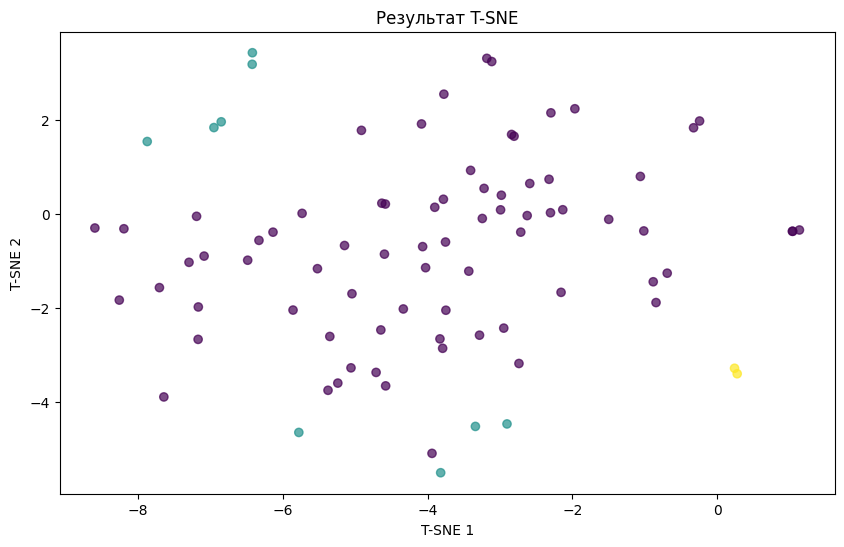

In [16735]:
# Для визуализации мы уменьшим размерность до 2D
tsne = TSNE(n_components=2, random_state=42)

# Применяем t-SNE
tsne_result = tsne.fit_transform(numeric_df)

# Визуализация результатов t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=scaled_df['KMeans'], cmap='viridis', alpha=0.7)#берем цвета по кластерам,
#прозрачностью точек (alpha=0.7)
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Результат T-SNE')
plt.show()


Вырисовывается 3 кластера в новом пространстве, видны достаточно компактные группы на графике, однако также присутствуют точки одного цвета, перемешенные с  точками другого цветами, это может означать, что T-SNE плохо разделил данные на кластеры.

#### Теперь снизим размерности с помощью PCA

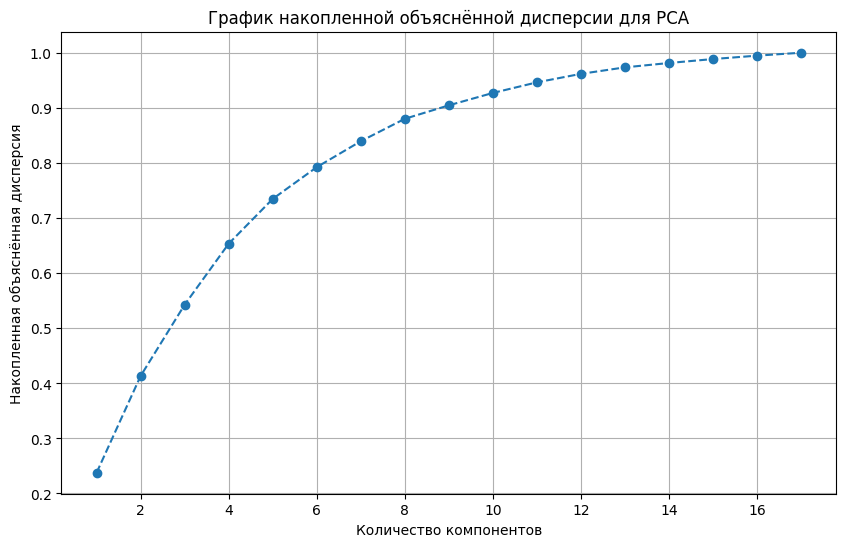

In [16736]:
# Вычислим объяснённую дисперсию
pca = PCA()  # Создаём объект PCA без ограничения количества компонент
pca_result = pca.fit_transform(numeric_df)  # Применяем PCA к данным

# Посчитаем долю объяснённой дисперсии для каждой компоненты
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Визуализируем объяснённую дисперсию
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Количество компонентов')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('График накопленной объяснённой дисперсии для PCA')
plt.grid()
plt.show()


In [16737]:
#Хотим сохранить 90% информации
n_components = np.argmax(explained_variance_ratio >= 0.9) + 1  # Количество компонент для 90% дисперсии
print(f"Оптимальное количество компонентов для 90% дисперсии: {n_components}")

# Создаём PCA с оптимальным количеством компонентов
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(numeric_df)

Оптимальное количество компонентов для 90% дисперсии: 9


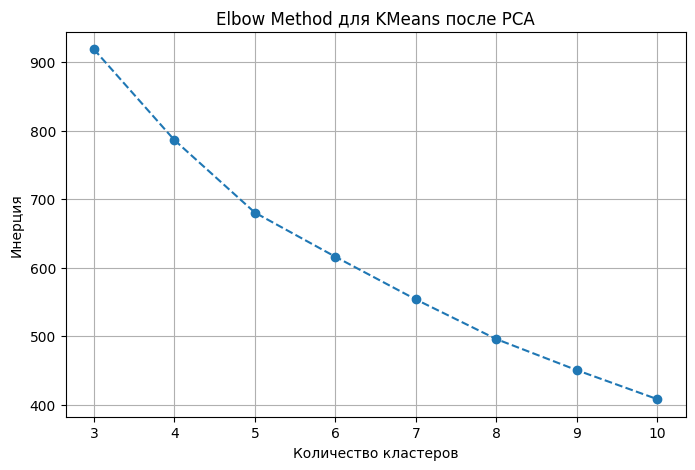

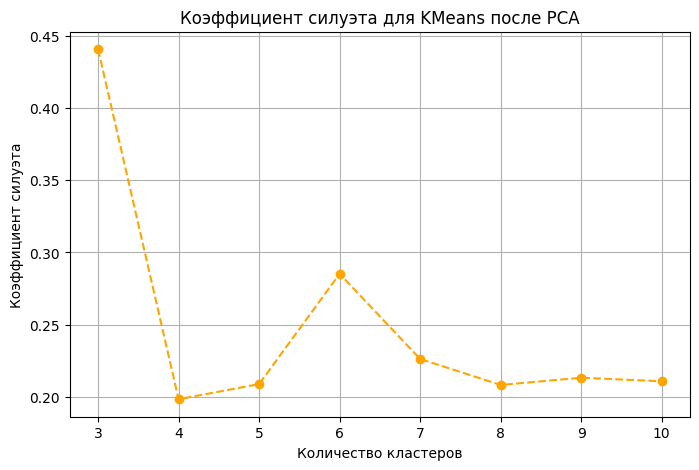

In [16738]:
# Найдём оптимальное количество кластеров с помощью метода локтя и коэффициента силуэта
inertia = []  # Список для значений инерции
silhouette_scores = []  # Список для значений силуэтного коэффициента
k_values = range(3, 11)  # Диапазон возможных кластеров

for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, n_init = 100, max_iter=300, random_state=42)
    kmeans_pca.fit(pca_result)
    inertia.append(kmeans_pca.inertia_)  # Сохраняем инерцию
    silhouette_scores.append(silhouette_score(pca_result, kmeans_pca.labels_))  # Считаем силуэтный коэффициент

# Визуализируем Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Elbow Method для KMeans после PCA')
plt.grid()
plt.show()

# Визуализация силуэтного коэффициента
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для KMeans после PCA')
plt.grid()
plt.show()


In [16739]:
silhouette_scores

[0.4405640167289321,
 0.19843519854066297,
 0.2089185530227622,
 0.2851844284356046,
 0.22626074945785102,
 0.20829093291145698,
 0.21330261421811506,
 0.21084461373544175]

In [16597]:
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальное количество кластеров: {optimal_k}, Коэффициент силуэта: {max(silhouette_scores)}")

Оптимальное количество кластеров: 3, Коэффициент силуэта: 0.4405640167289321


Согласно "методу логтя" оптимальное количество кластеров - 5, но коэффициент силуэта дает максимальное значение (0.46) для трех кластеров.Поэтому буду ориетироваться по прежнему на 3 кластера.

In [16598]:
# Оптимальное количество кластеров
optimal_k = 3

# Применяем KMeans
kmeans_pca = KMeans(n_clusters=optimal_k, n_init = 100, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result)  # Обучаем модель и предсказываем кластеры

# Добавим метки кластеров в данные
scaled_df['KMeans_PCA'] =kmeans_pca_labels

# Посмотрим на распределение кластеров
print(scaled_df['KMeans_PCA'].value_counts())


KMeans_PCA
0    72
2     9
1     4
Name: count, dtype: int64


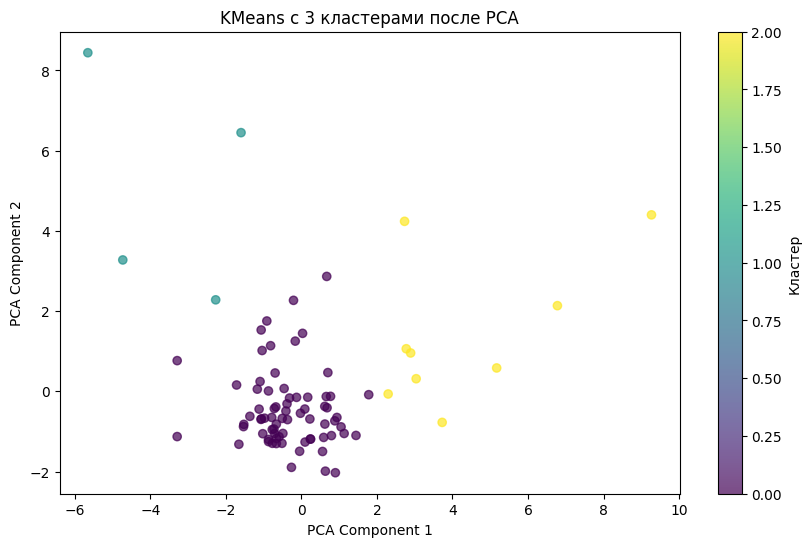

In [16599]:
# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_pca_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'KMeans с {optimal_k} кластерами после PCA')
plt.colorbar(label='Кластер')
plt.show()


Видим, что максимального значения коэффициент силуэта (0.45, против базовой модели 0.42) достигает при количестве кластеров, равное трем. Запомним эти значения для дальнейшего выбора оптимальной модели кластеризации. А теперь перейдем к следующей модели: ЕМ - алгориту

## 3.4

###  Модель Гауссовой смеси (Gaussian Mixture Model)

#### Сначала строим модель с помощью алгорит PCA

3 0.41207324017069297
4 0.338092671828744
5 0.22995598535428516
6 0.18597619603206206
7 0.20141765529230035
8 0.20859636471632803
9 0.19189752201754343
10 0.1906447076787477


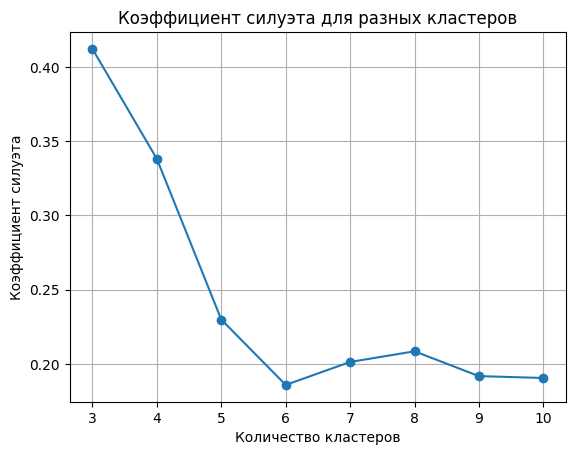

In [16600]:
# Возможные числа кластеров
k_values = range(3, 11)
silhouette_scores = []

for k in k_values:
    # Обучаем модель GMM с текущим количеством кластеров
    gm = GaussianMixture(n_components=k, random_state=42).fit(pca_result)
    # Предсказываем метки кластеров
    y_pred_Gaussian = gm.predict(pca_result)
    # Вычисляем коэффициент силуэта
    silhouette_score_value = silhouette_score(pca_result, y_pred_Gaussian)
    silhouette_scores.append(silhouette_score_value)
    print(k, silhouette_score_value)

# График силуэта
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для разных кластеров')
plt.grid(True)
plt.show()


Гауссова смесь дала оптимальный результат при разделинии также на три класса, значение коэффициента силуэта, при этом составила 0.41, что даже хуже, чем при базовой модели Kmeans.

#### Теперь, чтобы лучше понять структуры данных, попробуем воспользоваться нелинейным преобразованием с помощью алгоритма t-SNE.

In [16601]:
gauss_sil = []

for i in range(3, 11):
    gm = GaussianMixture(n_components= i, random_state = 42)
    gm.fit(tsne_result)
    gm_sil_score = silhouette_score(tsne_result, gm.predict(tsne_result))
    gauss_sil.append((i,gm_sil_score))
      
gauss_sil = pd.DataFrame(gauss_sil, columns=['number_of_cluster', 'gauss_score'])
gauss_sil

number_of_cluster  gauss_score
0                  3     0.353779
1                  4     0.336884
2                  5     0.405011
3                  6     0.391606
4                  7     0.341456
5                  8     0.342922
6                  9     0.320129
7                 10     0.374520

## 3.5

### Агломеративная кластеризация

#### Сначала строим модель с помощью алгорит PCA

3 0.562373102259765
4 0.16108187778817243
5 0.18462790545794314
6 0.19828447175976374
7 0.21661703340169722
8 0.20650404935948893
9 0.21650334925640208
10 0.22141902504932737


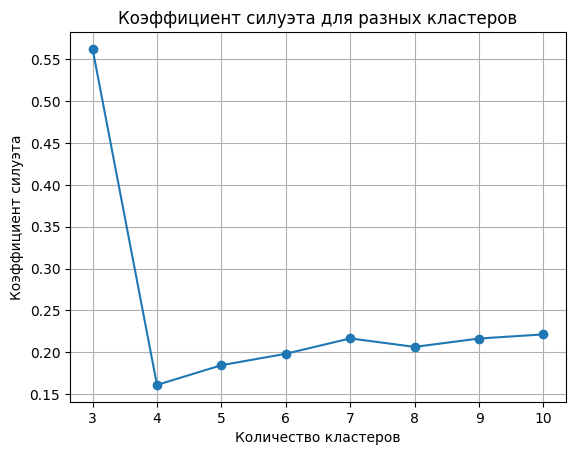

In [16602]:
# Возможные числа кластеров
k_values = range(3, 11)
silhouette_scores = []

# Для иерархической кластеризации
for k in k_values:
    # Обучаем модель иерархической кластеризации с текущим количеством кластеров
    agg = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')# в качестве metric используется эвклидово расстояние 
    #для вычисления расстояния между точками, а в качестве linkage минимизируем сумму квадратов отклонений для объединения кластеров.
    y_pred_agg = agg.fit_predict(pca_result)

    # Вычисляем коэффициент силуэта
    silhouette_score_value = silhouette_score(pca_result, y_pred_agg)
    silhouette_scores.append(silhouette_score_value)

    # Выводим результат
    print(k, silhouette_score_value)

# График силуэта
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для разных кластеров')
plt.grid(True)
plt.show()


In [16603]:
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальное количество кластеров: {optimal_k}, Коэффициент силуэта: {max(silhouette_scores)}")

Оптимальное количество кластеров: 3, Коэффициент силуэта: 0.562373102259765


Давайте визуализируем наши кластеры и построем 3D модель. Для этого используем n_components=3 для оптимальной 3D визуализации, несмотря на объясненную дисперсию с 9 компонентами.

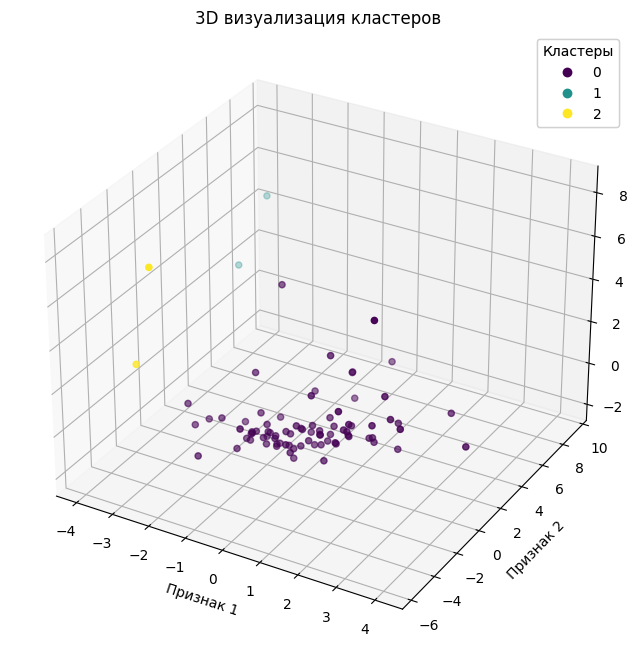

In [16604]:
from mpl_toolkits.mplot3d import Axes3D

# Снижаем размерность до 3
pca_3d = PCA(n_components=3)
pca_result_3d = pca.fit_transform(pca_result)

# Кластеризация на основе иерархического метода
ac = AgglomerativeClustering(n_clusters=3)
clusters = ac.fit_predict(pca_result_3d)

# Визуализация 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=clusters, cmap='viridis')

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('3D визуализация кластеров')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)



#### Теперь для сравнения используем  алгоритм t-SNE.

In [16605]:
agg_sil = []

for i in range(3, 11):
    agg = AgglomerativeClustering(n_clusters=i)
    agg.fit(tsne_result)
    agg_sil_score = silhouette_score(tsne_result, agg.labels_)
    agg_sil.append((i, agg_sil_score))
    
agg_sil = pd.DataFrame(agg_sil, columns=['number_of_cluster', 'agg_score'])
agg_sil

number_of_cluster  agg_score
0                  3   0.364116
1                  4   0.384866
2                  5   0.390441
3                  6   0.377449
4                  7   0.359091
5                  8   0.366168
6                  9   0.348034
7                 10   0.357681

Ожидаемо, использование алгоритма t-SNE дает результат хуже, т к он сохраняет локальную структуру (соседние точки остаются соседними).
При том, что он лучше подходит для визуализации данных, все же меньше подходит для построения кластеров, так как искажает метрики расстояний, поэтому не вижу целесообразности проводить сравнение различных алгоритмов кластеризиции при помощи алгоритма t-SNE.

## 3.6 

### DBSCAN

3 0.562373102259765
4 0.562373102259765
5 0.562373102259765
6 0.562373102259765
7 0.562373102259765
8 0.562373102259765
9 0.562373102259765
10 0.562373102259765


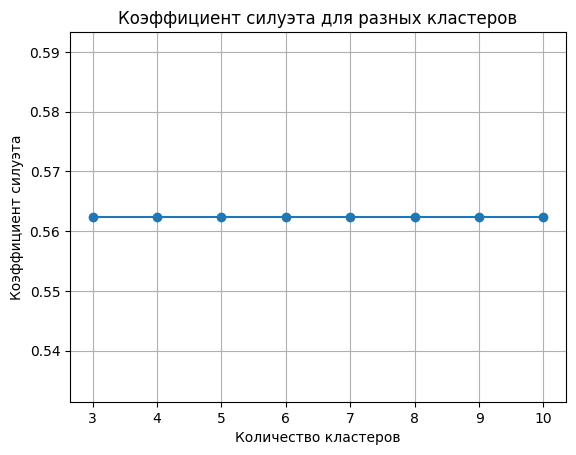

In [16606]:
# Возможные числа кластеров
k_values = range(3, 11)
silhouette_scores = []

# Применение DBSCAN
for k in k_values:
    dbscan = DBSCAN(eps=0.5, min_samples=k)  # Параметры eps и min_samples можно подбирать экспериментально
    y_pred_dbscan = dbscan.fit_predict(pca_result)
    
    # Вычисляем коэффициент силуэта
    silhouette = silhouette_score(pca_result, clusters)
    silhouette_scores.append(silhouette)

    # Выводим результат
    print(k, silhouette)

# График силуэта
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для разных кластеров')
plt.grid(True)
plt.show()


Видим, что при DBSCAN значение коэф.силуэта для всех кластеров одинаковое, на уровне 0.216, такле может произойти по нескольким причинам: возможно, данные слишком плотные и мало различаются между точками, что делает сложным создание четких кластеров. К тому же DBSCAN чувствителен к параметрам eps (порог расстояния) и min_samples (минимальное количество точек в группе), eps и min_samples могут быть недостаточно оптимальными, что приводит к недостаточной или чрезмерной сегментации данных, т е все регионы кластеризируются, как 1 кластер или как 85. 

Попробуем выбрать оптимальное значения eps с использованием 90-го процентиля расстояний от ближайших соседей. Это позволяет лучше определить подходящее расстояние для DBSCAN.

In [16607]:
# Найдем оптимальное значение eps с использованием Nearest Neighbors
knn = NearestNeighbors(n_neighbors=2)
knn.fit(pca_result)
distances, _ = knn.kneighbors()
eps_value = np.percentile(distances[:, 1], 90)  # Пример: 90-й процентиль

# Задаем значения eps и min_samples
eps = eps_value 

# Возможные числа кластеров
k_values = range(3, 11)
silhouette_scores = []

# Применение DBSCAN
for k in k_values:
    dbscan = DBSCAN(eps=eps, min_samples=3)  # Параметры eps и min_samples можно подбирать экспериментально
    y_pred_dbscan = dbscan.fit_predict(pca_result)
    # Вычисляем коэффициент силуэта
    silhouette = silhouette_score(pca_result, clusters)
    silhouette_scores.append(silhouette)

    # Выводим результат
    print(k, silhouette)

3 0.562373102259765
4 0.562373102259765
5 0.562373102259765
6 0.562373102259765
7 0.562373102259765
8 0.562373102259765
9 0.562373102259765
10 0.562373102259765


Как видим результат тот же, все данные определены в один кластер, из чего делаем вывод, что данный метод нам не подходит.

## 3.7

### Спектральная кластеризация

3 0.562373102259765
4 0.562373102259765
5 0.562373102259765
6 0.562373102259765
7 0.562373102259765
8 0.562373102259765
9 0.562373102259765
10 0.562373102259765


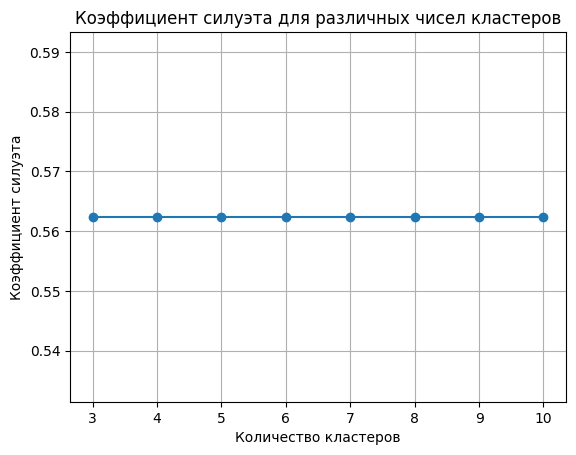

In [16608]:
# Возможные числа кластеров
k_values = range(3, 11)
silhouette_scores = []

# Применение Spectral Clustering
for k in k_values:
    # Обучение модели Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=10)
    y_pred_clusters = spectral.fit_predict(pca_result)

    # Вычисление коэффициента силуэта
    silhouette = silhouette_score(pca_result, clusters)
    silhouette_scores.append(silhouette)

    # Выводим результат
    print(k, silhouette)

# График силуэта
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для различных чисел кластеров')
plt.grid(True)
plt.show()


Спектральная кластеризация (как и DBSCAN) не может найти четких границ между кластерами, поэтому не будем задерживаться на этой модели. 

## 3.8

### Лучшая модель

В лидеры вышли две модели: K-means и агломеративная кластеризация при использовании алгоритма снижения размерности PCA. Однако, AgglomerativeClustering даёт лучше результат метрики (коэффециента силуэта), чем K-means (0.56 против 0.45), но само распределение регионов по кластерам при K-means выглядит более логично. Такая ситуация могла сложиться по нескольким причинам: во-первых, иерархическая кластеризация склонна объединять кластеры на основе глобального сходства между точками (в нашем случае — регионов), что может приводить к "перегруппировке" данных. В результате получается крупный кластер (Кластер 0) и несколько малых (Кластеры 1 и 2), которые плохо распределены с точки зрения реального смысла. В то время, как KMeans работает на основе разделения данных по "средним" точкам (центроидам), что чаще даёт более интерпретируемые кластеры. Однако, при наличии данных с неравномерным распределением, качество по силуэту может ухудшиться.

Давайте же сравним эти два подхода и примем решение какая модель лучше. Начнем с K-means.

In [16698]:
# Добавляем метки кластеров модели kmeans в наши данные (cleaned_df)
cleaned_df['Кластер'] = kmeans_pca_labels

# Группируем регионы по кластерам
regions_by_cluster = cleaned_df.groupby('Кластер')['Регион'].apply(list)

# Выводим регионы в каждом кластере
for cluster, regions in regions_by_cluster.items():
    print(f"Кластер {cluster}:")
    print(", ".join(regions))

Кластер 0:
Алтайский край, Амурская область, Астраханская область, Белгородская область, Брянская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область, Забайкальский край, Ивановская область, Иркутская область, Кабардино-Балкарская Республика, Калининградская область, Калужская область, Карачаево-Черкесская Республика, Кемеровская область - Кузбасс, Кировская область, Костромская область, Краснодарский край, Красноярский край, Курганская область, Курская область, Ленинградская область, Липецкая область, Мурманская область, Нижегородская область, Новгородская область, Новосибирская область, Омская область, Оренбургская область, Орловская область, Пензенская область, Пермский край, Приморский край, Псковская область, Республика Адыгея, Республика Башкортостан, Республика Бурятия, Республика Дагестан, Республика Ингушетия, Республика Калмыкия, Республика Карелия, Республика Коми, Республика Крым, Республика Марий Эл, Республика Мордовия, Республик

Для лучшего представления рассмотрим две проекции кластеризации в 2D и 3D пространстве.

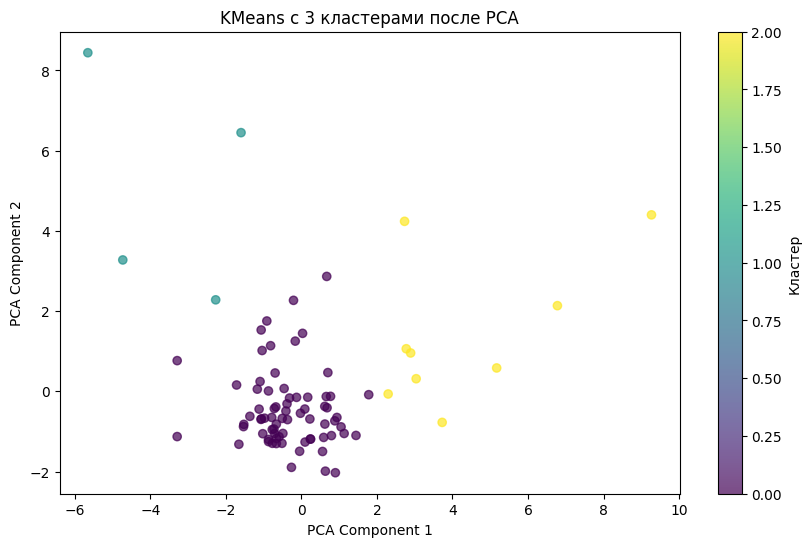

In [16699]:
# Двухмерная визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_pca_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'KMeans с {optimal_k} кластерами после PCA')
plt.colorbar(label='Кластер')
plt.show()


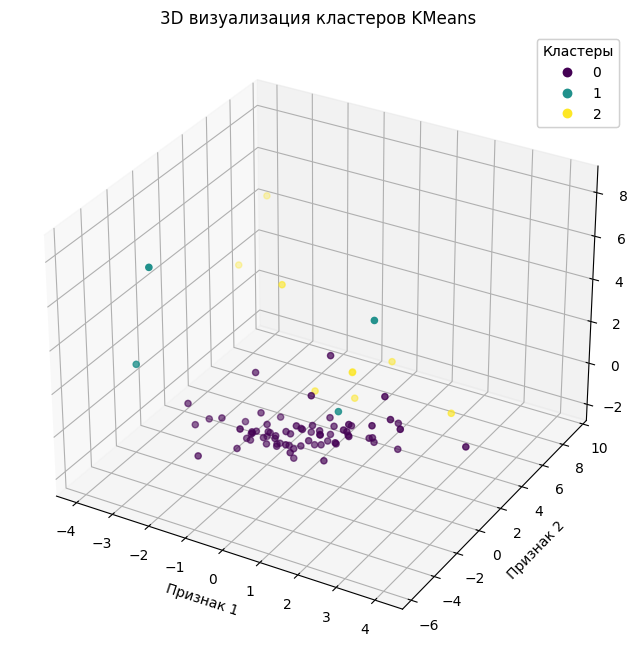

In [16700]:
# Снижаем размерность до 3
pca_3d = PCA(n_components=3)
pca_result_3d = pca.fit_transform(pca_result)

# Визуализация 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=kmeans_pca_labels, cmap='viridis')

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('3D визуализация кластеров KMeans')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

Теперь перейдем к агламеративной кластеризации и проделаем точно такие же шаги. 

In [16701]:
# Применяем иерархическую кластеризацию с оптимальным количеством кластеров
optimal_k = 3

# Обучаем модель иерархической кластеризации
agg = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
y_pred_agg = agg.fit_predict(pca_result)

# Добавляем метки кластеров в наши данные
cleaned_df_agg = cleaned_df.copy()
cleaned_df['Кластер'] = y_pred_agg

# Группируем регионы по кластерам
regions_by_cluster = cleaned_df.groupby('Кластер')['Регион'].apply(list)

# Выводим регионы в каждом кластере
for cluster, regions in regions_by_cluster.items():
    print(f"Кластер {cluster}:")
    print(", ".join(regions))

Кластер 0:
Алтайский край, Амурская область, Астраханская область, Белгородская область, Брянская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область, Еврейская автономная область, Забайкальский край, Ивановская область, Иркутская область, Кабардино-Балкарская Республика, Калининградская область, Калужская область, Камчатский край, Карачаево-Черкесская Республика, Кемеровская область - Кузбасс, Кировская область, Костромская область, Краснодарский край, Красноярский край, Курганская область, Курская область, Ленинградская область, Липецкая область, Магаданская область, Москва, Московская область, Мурманская область, Нижегородская область, Новгородская область, Новосибирская область, Омская область, Оренбургская область, Орловская область, Пензенская область, Пермский край, Приморский край, Псковская область, Республика Адыгея, Республика Алтай, Республика Башкортостан, Республика Бурятия, Республика Дагестан, Республика Ингушетия, Республика К

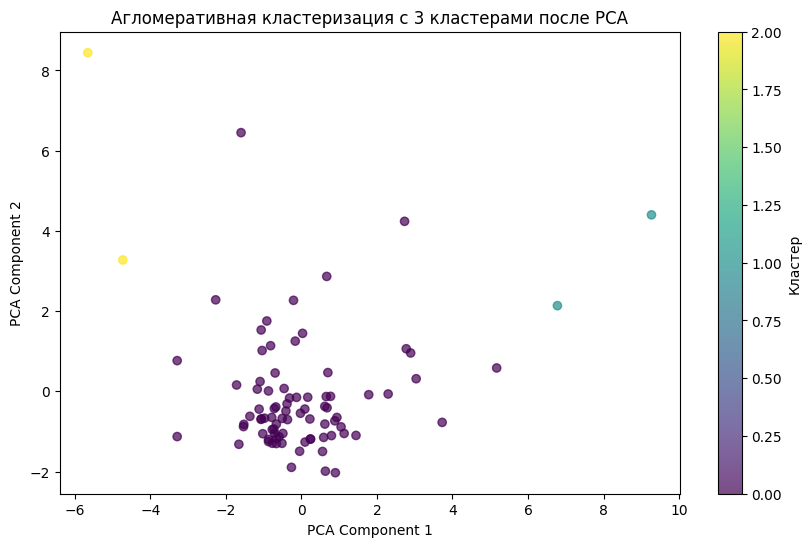

In [16702]:
# Визуализация иерархической кластеризации в 2D
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_pred_agg, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'Агломеративная кластеризация с {optimal_k} кластерами после PCA')
plt.colorbar(label='Кластер')
plt.show()


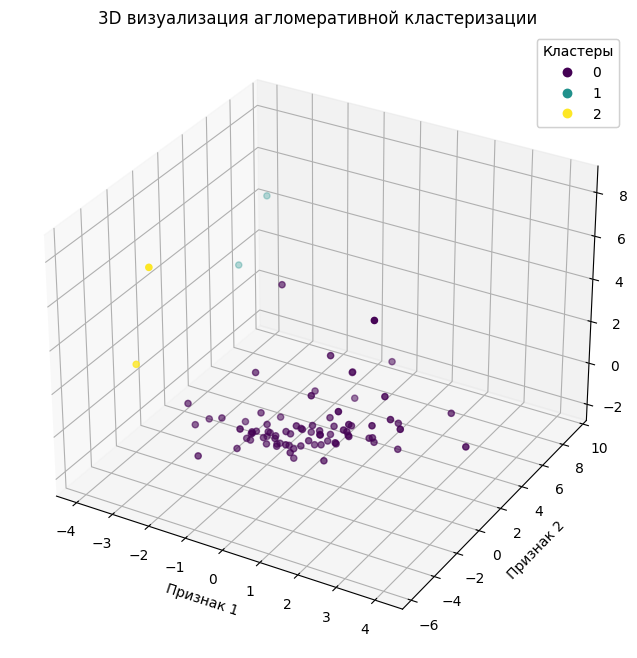

In [16703]:
# Визуализация 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=y_pred_agg, cmap='viridis')

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('3D визуализация агломеративной кластеризации')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

Наше решение основывалось на макимальной метрики коэффициента силуэта, попробуем теперь воспользоваться индексом Дэвиса-Болдина  и Калински-Харабаша. Они могут лучше отразить качество кластеров в задаче.

In [16704]:
# Для KMeans
calinski_harabasz_kmeans = calinski_harabasz_score(pca_result, kmeans_pca_labels)

# Для Иерархической кластеризации
calinski_harabasz_hierarchical = calinski_harabasz_score(pca_result, y_pred_agg)

print(f"Индекс Калински-Харабаша (KMeans): {calinski_harabasz_kmeans}")
print(f"ИндексКалински-Харабаша (AgglomerativeClustering): {calinski_harabasz_hierarchical}")


Индекс Калински-Харабаша (KMeans): 17.303536230643548
ИндексКалински-Харабаша (AgglomerativeClustering): 15.81703406535057


KMeans показывает лучшее качество кластеризации с точки зрения разницы между кластерами и их компактности. Это подтверждает "логичность" кластеров при использовании KMeans.

In [16705]:
#Для KMeans
davies_bouldin_kmeans = davies_bouldin_score(pca_result, kmeans_pca_labels)

# Для Иерархической кластеризации
davies_bouldin_hierarchical = davies_bouldin_score(pca_result, y_pred_agg)

print(f"Индекс Дэвиса-Болдина (KMeans): {davies_bouldin_kmeans}")
print(f"Индекс Дэвиса-Болдина (AgglomerativeClustering): {davies_bouldin_hierarchical}")

Индекс Дэвиса-Болдина (KMeans): 1.385320098180386
Индекс Дэвиса-Болдина (AgglomerativeClustering): 0.6903702203386847


Меньший индекс означает, что кластеры более различимы друг от друга. Большее значение индекса указывает на то, что кластеры менее различимы и более перекрываются. Таким образом, чем меньше значение индекса Дэвиса-Болдина, тем лучше качество кластеризации. Однако, лучший результат для агломеративной кластеризации неудивителен, когда регионы разделены в соотношении 81:2:2. 

На основе проделанного сравнения и логиги в качестве лучшей модели выбираю __KMeans__, однако и про агломеративную кластеризацию не забываем, в дальнейшем будем использовать разные методы в зависимости от згачений метрики. 

Теперь, когда мы знаем, какие регионы входят в каждый кластер, логично перейти к выявлению характеристик и уязвимых групп населения в каждом из этих кластеров. 

In [16697]:
# Добавляем метки лучшей модели kmeans в данные 
cleaned_df['Кластер'] = kmeans_pca_labels
# Исключаем текстовые столбцы перед группировкой
numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
cluster_characteristics = cleaned_df.groupby('Кластер')[numeric_columns].mean()

# Выводим результат
cluster_characteristics


Соцрасходы_left   Доходы_left     ВРП_left   
Кластер                                               
0              22.303009  27172.993056   433.974235  \
1              20.087500  57815.000000  1330.465813   
2              16.905556  47217.722222  1753.397085   

         Малообеспеченные дети_left  Малообеспеченные трудящиеся_left   
Кластер                                                                 
0                         36.431019                         55.276389  \
1                         52.470833                         72.533333   
2                         36.188889                         50.348148   

         Малообеспеченные пенсионеры_left  детская_смертность   
Кластер                                                         
0                                5.514352            5.866736  \
1                                8.333333            5.000575   
2                                4.196296           10.535165   

         Общая_инвалидность  Рождаемость  Нарко_преступления   
Кластер                                                        
0                107.255673  1040.957340            0.120478  \
1                 54.970665  1370.939736            0.078203   
2                317.251053  1343.276802            0.167386   

         Экономические_преступления  Тяжелые_преступления  Всего_преступлений   
Кластер                                                                         
0                          0.066450              0.068257            1.350512  \
1                          0.051943              0.048543            0.892891   
2                          0.091524              0.089112            1.998433   

         Полезные_ископаемые_доля  Электроэнергия_доля  Промышленность_доля   
Кластер                                                                       
0                    1.920450e+05        138758.432324         1.319764e+06  \
1                    1.390714e+06        526184.119449         3.322453e+06   
2                    1.082579e+05         31614.114287         3.502374e+05   

         Индекс_наркомании  Кластер  
Кластер                              
0                 0.771686      0.0  
1                 0.187950      1.0  
2                 7.144019      2.0

Попробуем на основе полученной статистики сделать выводы о характерных чертах каждого кластера и определить наиболее уязвимые группы населения.

__Кластер 0:__
Этот кластер имеет наименьшие значения социального обеспечения и других важных показателей, таких как уровень инвалидности и рождаемость. Это может свидетельствовать о более уязвимых группах населения с ограниченными ресурсами.

__Кластер 1:__
Показывает более высокие значения по большинству показателей, включая доходы, ВРП, социальные расходы. Возможно, это более устойчивые регионы с лучшими социальными и экономическими условиями.

__Кластер 2:__
Кластер 2 показывает средние значения, но с достаточно высоким уровнем общего количества преступлений и инвалидности. Это может указывать на значительное напряжение в социальной инфраструктуре и необходимость дополнительных ресурсов.

Таким образом, наиболее уязвимые группы населения, вероятно, сосредоточены в Кластере 0 и Кластере 2, где наблюдаются наименьшие социальные расходы, доходы и более высокие значения детской смертности, инвалидности и общего количества преступлений.

## 4. Статистические тесты

### 4.1 Критерий Крускала-Уоллиса

В контексте кластеризации с помощью данного теста можно оценить, как различаются характеристики групп населения в разных кластерах.


In [16676]:
cleaned_df.head()

Регион  Соцрасходы_left   Доходы_left     ВРП_left   
0         Алтайский край        27.100000  23475.500000   278.626717  \
1       Амурская область        24.533333  30626.166667   443.724183   
2  Архангельская область        22.100000  59693.166667  1043.507633   
3   Астраханская область        25.883333  24398.833333   482.640333   
4   Белгородская область        16.200000  30490.000000   549.952583   

   Малообеспеченные дети_left  Малообеспеченные трудящиеся_left   
0                   36.683333                         57.766667  \
1                   37.116667                         57.683333   
2                   57.783333                         97.800000   
3                   38.433333                         56.833333   
4                   26.350000                         34.750000   

   Малообеспеченные пенсионеры_left  детская_смертность  Общая_инвалидность   
0                          5.550000            6.181998           87.624500  \
1                          5.200000            5.611371          123.638994   
2                         11.100000            4.860283           52.567914   
3                          4.716667            6.727403           76.086171   
4                          5.566667            4.282272          153.073695   

   Рождаемость  Нарко_преступления  Экономические_преступления   
0   979.743399            0.140323                    0.044695  \
1  1084.834962            0.234935                    0.056890   
2   952.827793            0.039828                    0.042499   
3  1169.749931            0.151139                    0.086930   
4   910.388451            0.068219                    0.048160   

   Тяжелые_преступления  Всего_преступлений  Полезные_ископаемые_доля   
0              0.065955            1.696249              21899.014900  \
1              0.074448            2.323819             142485.658282   
2              0.036441            0.836932             500941.119535   
3              0.075747            1.345937             425806.346799   
4              0.034837            0.885190             205283.174097   

   Электроэнергия_доля  Промышленность_доля  Индекс_наркомании  Кластер  
0        169928.421007         1.496283e+06           0.555878        0  
1         91899.871927         4.840663e+05           1.840836        0  
2        121034.687059         8.890236e+05           0.331217        1  
3         68432.290768         8.310961e+05           0.484837        0  
4         58354.643289         1.457264e+06           0.357683        0

In [16670]:
# Для начала выделим нескольких признаков, которые имеют большую социальную и экономическую значимость
features = ['Соцрасходы_left', 'Доходы_left', 'Всего_преступлений', 'детская_смертность', 'Рождаемость']

results = {}

for feature in features:
    clusters_data = [cleaned_df[cleaned_df['Кластер'] == cluster][feature].dropna().values for cluster in cleaned_df['Кластер'].unique()]
    kruskal_stat, p_value = kruskal(*clusters_data)#kruskal_stat показывает, насколько различны группы, 
    #p_value помогает определить, значимо ли различие между группами (при p-value меньше 0.05 различия значимы).
    results[feature] = {'statistic': kruskal_stat, 'p_value': p_value}

results


{'Соцрасходы_left': {'statistic': 14.022545302335894,
  'p_value': 0.0009016603587945063},
 'Доходы_left': {'statistic': 14.11979024167806,
  'p_value': 0.0008588681666235815},
 'Всего_преступлений': {'statistic': 18.543228454172322,
  'p_value': 9.40565625800273e-05},
 'детская_смертность': {'statistic': 6.655015959872287,
  'p_value': 0.035882413436536885},
 'Рождаемость': {'statistic': 13.599954400364766,
  'p_value': 0.001113800542004531}}

Все признаки, кроме детской смертности, имеют низкие p-value, что свидетельствует о статистически значимых различиях между кластерами для этих характеристик. Значение p-value для детской смертности близко к 0.05, но не превышает его, что также говорит о наличии различий. Количество преступлений имеет очень низкое p-value,что указывает на значимую разницу в количестве преступлений между кластерами.

Для наглядности построим графики распределения признаков по кластерам с помощью коробчатой диаграммы.

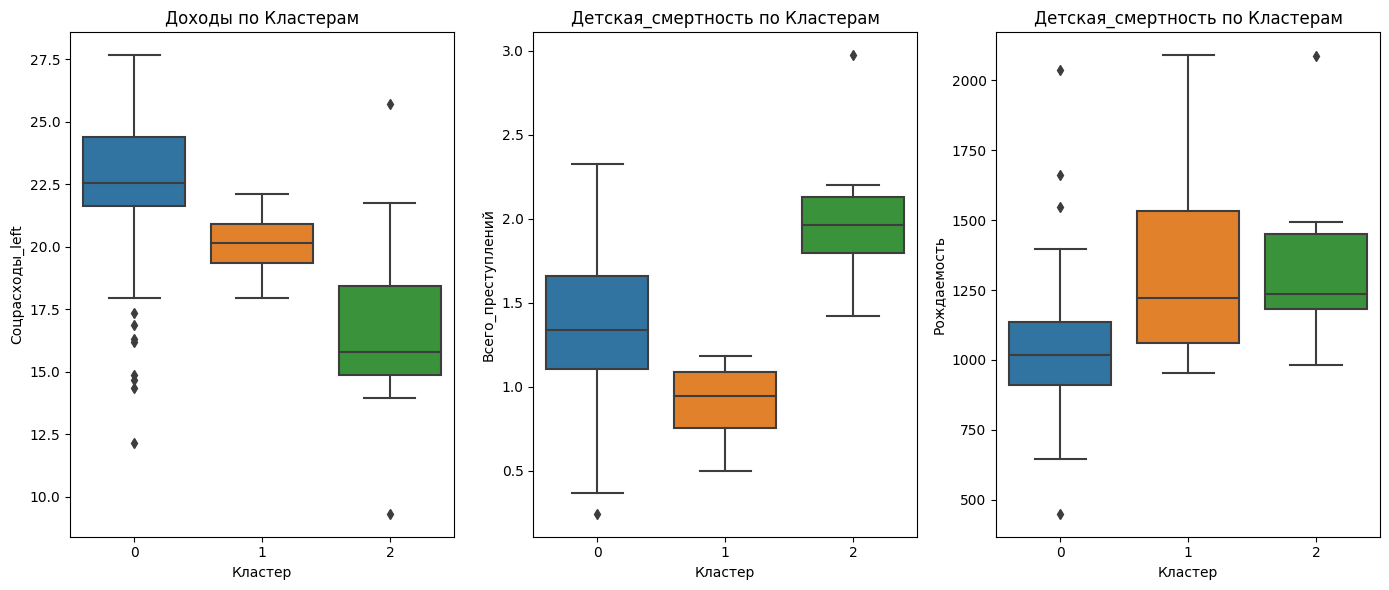

In [16696]:
# Устанавливаем размер фигуры
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Кластер', y='Соцрасходы_left', data=cleaned_df)
plt.title('Соцрасходы по Кластерам')

plt.subplot(1, 3, 2)
sns.boxplot(x='Кластер', y='Всего_преступлений', data=cleaned_df)
plt.title('Преступность по Кластерам')

plt.subplot(1, 3, 3)
sns.boxplot(x='Кластер', y='Рождаемость', data=cleaned_df)
plt.title('Рождаемость по Кластерам')

plt.tight_layout()
plt.show()

### 4.2 Т-тест

Используем его для сравнений двух кластеров по числовым признакам. T-Stat показывает разницу между средними значениями, а p-value проверяет, является ли эта разница статистически значимой.

In [16686]:
# Выбираем два признака, отражающие экономическую и социальную значимость
features = ['Доходы_left', 'детская_смертность']
clusters = [0, 1, 2]#rkfcnths

results = {}

for feature in features:
    for cluster in clusters:
        # Создаем список других кластеров, исключая текущий кластер
        other_clusters = [c for c in clusters if c != cluster]

        # Сравниваем текущий кластер со всеми остальными кластерами
        for other_cluster in other_clusters:
            cluster_data = cleaned_df[cleaned_df['Кластер'] == cluster][feature]
            other_cluster_data = cleaned_df[cleaned_df['Кластер'] == other_cluster][feature]

            # Применяем Т-тест
            t_stat, p_value = ttest_ind(cluster_data, other_cluster_data)

            results[f'{feature}_cluster_{cluster}_vs_{other_cluster}'] = {
                't_stat': t_stat,
                'p_value': p_value
            }

results


{'Доходы_left_cluster_0_vs_1': {'t_stat': -10.620014314524802,
  'p_value': 1.561974444675228e-16},
 'Доходы_left_cluster_0_vs_2': {'t_stat': -6.722109864622503,
  'p_value': 2.527282788318127e-09},
 'Доходы_left_cluster_1_vs_0': {'t_stat': 10.620014314524802,
  'p_value': 1.561974444675228e-16},
 'Доходы_left_cluster_1_vs_2': {'t_stat': 0.9192605800706735,
  'p_value': 0.37767677303967095},
 'Доходы_left_cluster_2_vs_0': {'t_stat': 6.722109864622503,
  'p_value': 2.527282788318127e-09},
 'Доходы_left_cluster_2_vs_1': {'t_stat': -0.9192605800706735,
  'p_value': 0.37767677303967095},
 'детская_смертность_cluster_0_vs_1': {'t_stat': 0.6324251498235592,
  'p_value': 0.5290584003824095},
 'детская_смертность_cluster_0_vs_2': {'t_stat': -4.343498907442338,
  'p_value': 4.1247202421917166e-05},
 'детская_смертность_cluster_1_vs_0': {'t_stat': -0.6324251498235592,
  'p_value': 0.5290584003824095},
 'детская_смертность_cluster_1_vs_2': {'t_stat': -2.1295495956268176,
  'p_value': 0.0566238355

Для признака _"Доходы_left"_ между большинством пар кластеров наблюдаются значительные различия, самые низкие значения p_value, при этом для  Кластера 1 и Кластера 2 характерна минимальная разница с t_stat 0.92 и p_value 0.38.

Для признака _"детская_смертность"_ также есть значительные различия между Кластер 0 и Кластер 2, а вот различия между Кластер 1 и Кластером 0, 2 менее значительны, например, 1 и 2: различие с t_stat -2.13 и p_value 0.056, что близко к уровню значимости.

Таким образом, данные тесты подтверждают значительные различия в распределении признаков между кластерами, что важно для анализа уязвимых групп населения.

Визуализацируем распределение признаков в кластерах.

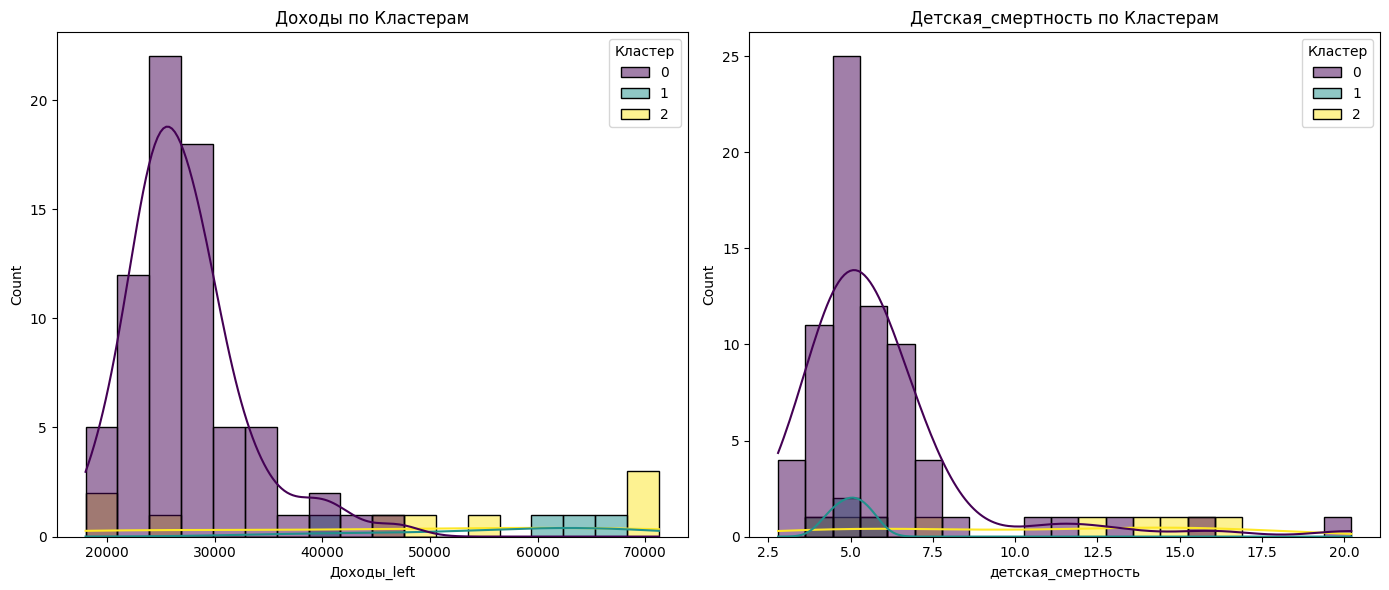

In [16692]:
# Гистограмма распределения Соцрасходов в каждом кластере
# Устанавливаем размер фигуры
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(cleaned_df, x='Доходы_left', hue='Кластер', kde=True, palette='viridis')
plt.title('Доходы по Кластерам')

plt.subplot(1, 2, 2)
sns.histplot(cleaned_df, x='детская_смертность', hue='Кластер', kde=True, palette='viridis')
plt.title('Детская_смертность по Кластерам')

plt.tight_layout()
plt.show()

## 5. Кластеризация по годам.

Теперь, когда у нас есть лучшая модель мы можем приступить к кластеризации по кадому году отдельно. В качестве лучших моделей будем использовать Kmeans и агломеративную кластеризацию

In [ ]:
new_df = df.copy()

In [ ]:
new_df.head()

Численность_населения_left                  Регион_Год   
0                   2376774.0         Алтайский край_2016  \
1                    805689.0       Амурская область_2016   
2                   2304318.0  Архангельская область_2016   
3                   1018626.0   Астраханская область_2016   
4                   1550137.0   Белгородская область_2016   

   Смертность_детей_сельская_местность_left  Смертность_детей_город_left   
0                                      87.0                        124.0  \
1                                      23.0                         30.0   
2                                      35.0                        125.0   
3                                      21.0                         61.0   
4                                      36.0                         72.0   

   Соцрасходы_left  Доходы_left   ВРП_left  Полезные_ископаемые_left   
0             20.4      21256.0   224.5258                 4852175.4  \
1             28.9      27976.0   370.1924                64379100.3   
2             16.3      61231.0  1010.2486               564681118.4   
3             20.5      22841.0   361.7048               137479662.7   
4             11.8      29799.0   501.4678                88929906.1   

   Обрабатывающее_производство_left  Электроэнергия_left  ...   
0                      2.658828e+08         4.504698e+07  ...  \
1                      2.789874e+07         3.365899e+07  ...   
2                      6.273662e+08         1.389098e+08  ...   
3                      6.191667e+07         2.840190e+07  ...   
4                      6.038814e+08         2.822501e+07  ...   

   Обрабатывающее_производство_доля  Электроэнергия_доля  Промышленность_доля   
0                      1.184197e+06        200631.630173         1.638957e+06  \
1                      7.536280e+04         90922.956009         3.631141e+05   
2                      6.210018e+05        137500.645524         9.924414e+05   
3                      1.711801e+05         78522.320135         8.661341e+05   
4                      1.204228e+06         56284.795853         1.562066e+06   

   Водоснабжение_доля  Розничная_торговля  ВРП_vs_mean  Доходы_vs_mean   
0        35936.277256            0.858306     0.364569        0.691536  \
1         7781.224574            3.586992     0.601093        0.910163   
2        10943.157061            0.707368     1.640372        1.992071   
3        13226.902684            2.012515     0.587311        0.743102   
4        21166.072478            0.761223     0.814249        0.969472   

   Индекс_наркомании  Индекс_алкоголизма  Индекс_благосостояния  
0           0.732085            4.211591               0.007351  
1           2.345818           11.456033               0.028820  
2           0.173587            3.367591               0.022533  
3           0.225794            6.066996               0.018813  
4           0.103217            2.973931               0.017666  

[5 rows x 53 columns]

In [ ]:
# Список признаков для удаления
columns_to_drop = [
    'Численность_населения_left',
    'Смертность_детей_сельская_местность_left',
    'Смертность_детей_город_left',
    'Розничная_торговля_left',
    'ВРП_left',
    'Общее_число_инвалидов_left',
    'Число_инвалидов_18_30_left', 
    'Число_инвалидов_31_40_left',
    'Число_инвалидов_41_50_left',
    'Число_инвалидов_51_60_left', 
    'Число_инвалидов_60_left',
    'Доходы_left',
    'Бедные_left',
    'Полезные_ископаемые_left',
    'Обрабатывающее_производство_left',
    'Водоснабжение_left',
    'Промышленность_left',
    'Новорожденные_left',
    'Общая_преступность_left',
    'Тяжелые_преступления_left',
    'Электроэнергия_left',
    'Наркомания_left', 
    'Алкоголизм_left',
    'Экономические_преступления_left',
    'Нарко_преступления_left',
    'Инвалидность_18_30', 'Инвалидность_31_40',
    'Инвалидность_41_50',
    'Инвалидность_51_60',
    'Инвалидность_60_',
    'Водоснабжение_доля',
    'Индекс_алкоголизма',
    'Индекс_благосостояния',
    'Обрабатывающее_производство_доля',
    'Розничная_торговля'
    ]

# Удаление колонок
new_df = new_df.drop(columns=columns_to_drop, axis=1)


In [ ]:
new_df.head()

Регион_Год  Соцрасходы_left  Малообеспеченные дети_left   
0         Алтайский край_2016             20.4                        38.0  \
1       Амурская область_2016             28.9                        38.0   
2  Архангельская область_2016             16.3                        38.0   
3   Астраханская область_2016             20.5                        38.0   
4   Белгородская область_2016             11.8                        38.0   

   Малообеспеченные трудящиеся_left  Малообеспеченные пенсионеры_left   
0                              55.6                               6.4  \
1                              55.6                               6.4   
2                              55.6                               6.4   
3                              55.6                               6.4   
4                              55.6                               6.4   

   детская_смертность  Общая_инвалидность  Рождаемость  Нарко_преступления   
0            8.877579           84.825861  1204.321488            0.144313  \
1            6.578221          250.235389  1287.965952            0.219564   
2            6.943486           87.493089  1190.547485            0.038970   
3            8.050060          197.925343  1400.906712            0.197717   
4            6.967126          130.060698  1113.514483            0.058575   

   Экономические_преступления  Тяжелые_преступления  Всего_преступлений   
0                    0.044262              0.068875            1.875483  \
1                    0.061562              0.059825            2.315534   
2                    0.041401              0.033893            0.867675   
3                    0.080501              0.085802            1.363896   
4                    0.057285              0.031868            0.884761   

   Полезные_ископаемые_доля  Электроэнергия_доля  Промышленность_доля   
0              21610.769898        200631.630173         1.638957e+06  \
1             173907.136667         90922.956009         3.631141e+05   
2             558952.636410        137500.645524         9.924414e+05   
3             380088.023991         78522.320135         8.661341e+05   
4             177339.215200         56284.795853         1.562066e+06   

   ВРП_vs_mean  Доходы_vs_mean  Индекс_наркомании  
0     0.364569        0.691536           0.732085  
1     0.601093        0.910163           2.345818  
2     1.640372        1.992071           0.173587  
3     0.587311        0.743102           0.225794  
4     0.814249        0.969472           0.103217

In [ ]:
# Функция для обработки и кластеризации данных по каждому году
def process_yearly_clusters(data, year, optimal_k):
    # Фильтруем данные по году
    yearly_data = data[data['Регион_Год'].str.contains(str(year))].copy()
    
    # Выбираем числовые признаки и стандартизируем их
    numeric_features = yearly_data.drop(columns=['Регион_Год'])
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(numeric_features)
    
    # Применяем PCA для уменьшения размерности
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    # Список моделей и их результаты
    methods = ['KMeans', 'Agglomerative']
    results = {}

    for method in methods:
        if method == 'KMeans':
            cluster_model = KMeans(n_clusters=optimal_k, n_init=50, random_state=42)
        elif method == 'Agglomerative':
            cluster_model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
        
        y_pred = cluster_model.fit_predict(pca_result)
        silhouette = silhouette_score(pca_result, y_pred)
        
        results[method] = {'labels': y_pred, 'silhouette_score': silhouette}
    
    # Определяем метод с наилучшим коэффициентом силуэта
    best_method = max(results, key=lambda x: results[x]['silhouette_score'])
    best_result = results[best_method]

    # Добавляем кластеры и метод в данные
    yearly_data['Кластер'] = best_result['labels']
    yearly_data['Метод'] = best_method
    yearly_data['Silhouette'] = best_result['silhouette_score']
    
    return yearly_data, best_method, optimal_k, best_result['silhouette_score']

# Объединенный DataFrame для всех годов
clustered_data_by_year = pd.DataFrame()

# Словарь для данных по годам
yearly_cluster_tables = {}

# Пример обработки данных по каждому году
years = range(2016, 2022)
all_results = {}

for year in years:
    print(f"Год: {year}")
    clustered_year_data, best_method, optimal_k, best_silhouette = process_yearly_clusters(new_df, year, optimal_k=3)
    
    # Сохраняем результаты
    yearly_cluster_tables[year] = clustered_year_data
    all_results[year] = {'method': best_method, 'k_clusters': optimal_k, 'silhouette_score': best_silhouette}
    
    # Добавляем данные в общий DataFrame
    clustered_data_by_year = pd.concat([clustered_data_by_year, clustered_year_data], axis=0)

# Сбрасываем индексы для удобства
clustered_data_by_year.reset_index(drop=True, inplace=True)

# Вывод информации о лучшей модели для каждого года
for year, result in all_results.items():
    print(f"\nYear {year}: Best Method: {result['method']}, Optimal Clusters: {result['k_clusters']}, Silhouette Score: {result['silhouette_score']:.3f}")


Год: 2016
Год: 2017
Год: 2018
Год: 2019
Год: 2020
Год: 2021

Year 2016: Best Method: KMeans, Optimal Clusters: 3, Silhouette Score: 0.482

Year 2017: Best Method: Agglomerative, Optimal Clusters: 3, Silhouette Score: 0.538

Year 2018: Best Method: KMeans, Optimal Clusters: 3, Silhouette Score: 0.438

Year 2019: Best Method: KMeans, Optimal Clusters: 3, Silhouette Score: 0.603

Year 2020: Best Method: KMeans, Optimal Clusters: 3, Silhouette Score: 0.561

Year 2021: Best Method: KMeans, Optimal Clusters: 3, Silhouette Score: 0.432


Любопытно, что только для 2017 года кластеризация была проведена с помощью алгоритма иерархической кластеризации, при котором метрика достикла максимального значения. Для всех остальных годов наилучший результат дал KMeans. При этом оптимальное количество кластеров для каждого года - 3.

In [ ]:
#Общая таблица с метками кластеров, используемого алгоритма и метрикой
clustered_data_by_year.head()

Регион_Год  Соцрасходы_left  Малообеспеченные дети_left   
0         Алтайский край_2016             20.4                        38.0  \
1       Амурская область_2016             28.9                        38.0   
2  Архангельская область_2016             16.3                        38.0   
3   Астраханская область_2016             20.5                        38.0   
4   Белгородская область_2016             11.8                        38.0   

   Малообеспеченные трудящиеся_left  Малообеспеченные пенсионеры_left   
0                              55.6                               6.4  \
1                              55.6                               6.4   
2                              55.6                               6.4   
3                              55.6                               6.4   
4                              55.6                               6.4   

   детская_смертность  Общая_инвалидность  Рождаемость  Нарко_преступления   
0            8.877579           84.825861  1204.321488            0.144313  \
1            6.578221          250.235389  1287.965952            0.219564   
2            6.943486           87.493089  1190.547485            0.038970   
3            8.050060          197.925343  1400.906712            0.197717   
4            6.967126          130.060698  1113.514483            0.058575   

   Экономические_преступления  ...  Всего_преступлений   
0                    0.044262  ...            1.875483  \
1                    0.061562  ...            2.315534   
2                    0.041401  ...            0.867675   
3                    0.080501  ...            1.363896   
4                    0.057285  ...            0.884761   

   Полезные_ископаемые_доля  Электроэнергия_доля  Промышленность_доля   
0              21610.769898        200631.630173         1.638957e+06  \
1             173907.136667         90922.956009         3.631141e+05   
2             558952.636410        137500.645524         9.924414e+05   
3             380088.023991         78522.320135         8.661341e+05   
4             177339.215200         56284.795853         1.562066e+06   

   ВРП_vs_mean  Доходы_vs_mean  Индекс_наркомании  Кластер   Метод Silhouette  
0     0.364569        0.691536           0.732085        0  KMeans   0.482019  
1     0.601093        0.910163           2.345818        0  KMeans   0.482019  
2     1.640372        1.992071           0.173587        2  KMeans   0.482019  
3     0.587311        0.743102           0.225794        0  KMeans   0.482019  
4     0.814249        0.969472           0.103217        0  KMeans   0.482019  

[5 rows x 21 columns]

In [ ]:
#таблица за 2017 год
yearly_cluster_tables[2017].head()

Регион_Год  Соцрасходы_left  Малообеспеченные дети_left   
85         Алтайский край_2017             30.9                        38.0  \
86       Амурская область_2017             26.3                        39.9   
87  Архангельская область_2017             24.8                        75.5   
88   Астраханская область_2017             27.7                        40.2   
89   Белгородская область_2017             16.4                        43.4   

    Малообеспеченные трудящиеся_left  Малообеспеченные пенсионеры_left   
85                              55.6                               6.4  \
86                              54.1                               6.0   
87                             110.6                              13.9   
88                              55.5                               4.2   
89                              44.8                              11.8   

    детская_смертность  Общая_инвалидность  Рождаемость  Нарко_преступления   
85            7.820162           85.223657  1080.196814            0.143003  \
86            5.986889          101.816397  1176.174179            0.247832   
87            6.469767           46.201482  1055.883488            0.038644   
88            7.262977           52.354873  1209.285618            0.160178   
89            4.958577          169.091003   973.233346            0.060018   

    Экономические_преступления  ...  Всего_преступлений   
85                    0.041130  ...            1.693171  \
86                    0.062239  ...            2.308070   
87                    0.043365  ...            0.839015   
88                    0.090591  ...            1.318328   
89                    0.050423  ...            0.820677   

    Полезные_ископаемые_доля  Электроэнергия_доля  Промышленность_доля   
85              26562.337959        198066.902785         1.591174e+06  \
86             172112.812357         96506.418092         3.594797e+05   
87             587719.701650        126826.184639         9.146001e+05   
88             522107.635699         63722.283452         7.206896e+05   
89             216016.092589         50082.803785         1.451354e+06   

    ВРП_vs_mean  Доходы_vs_mean  Индекс_наркомании  Кластер          Метод   
85     0.375518        0.720264           0.735518        0  Agglomerative  \
86     0.607170        0.950407           2.332392        0  Agglomerative   
87     1.779983        2.050177           0.236059        2  Agglomerative   
88     0.705838        0.744501           0.068704        0  Agglomerative   
89     0.876361        0.987138           0.148113        0  Agglomerative   

   Silhouette  
85   0.537821  
86   0.537821  
87   0.537821  
88   0.537821  
89   0.537821  

[5 rows x 21 columns]

In [ ]:
# Разделим данные на года
years = range(2016, 2022)  #года с 2016 по 2021

# Создадим пустой DataFrame для хранения результатов
region_clusters_by_year = {}

# Для каждого года найдем регионы по каждому кластеру
for year in years:
    year_data = clustered_data_by_year[clustered_data_by_year['Регион_Год'].str.contains(f'_{year}$')]
    clusters = year_data['Кластер'].unique()
    regions_by_cluster = {}
    for cluster in clusters:
        regions = year_data[year_data['Кластер'] == cluster]['Регион_Год'].tolist()
        regions_by_cluster[cluster] = regions
    region_clusters_by_year[year] = regions_by_cluster

#Кластеры с региона в 2016 году
region_clusters_by_year[2016]

{0: ['Алтайский край_2016',
  'Амурская область_2016',
  'Астраханская область_2016',
  'Белгородская область_2016',
  'Брянская область_2016',
  'Владимирская область_2016',
  'Волгоградская область_2016',
  'Вологодская область_2016',
  'Воронежская область_2016',
  'Забайкальский край_2016',
  'Ивановская область_2016',
  'Кабардино-Балкарская Республика_2016',
  'Калининградская область_2016',
  'Калужская область_2016',
  'Карачаево-Черкесская Республика_2016',
  'Кировская область_2016',
  'Костромская область_2016',
  'Краснодарский край_2016',
  'Курганская область_2016',
  'Курская область_2016',
  'Ленинградская область_2016',
  'Липецкая область_2016',
  'Нижегородская область_2016',
  'Новгородская область_2016',
  'Новосибирская область_2016',
  'Омская область_2016',
  'Оренбургская область_2016',
  'Орловская область_2016',
  'Пензенская область_2016',
  'Приморский край_2016',
  'Псковская область_2016',
  'Республика Адыгея_2016',
  'Республика Бурятия_2016',
  'Респуб

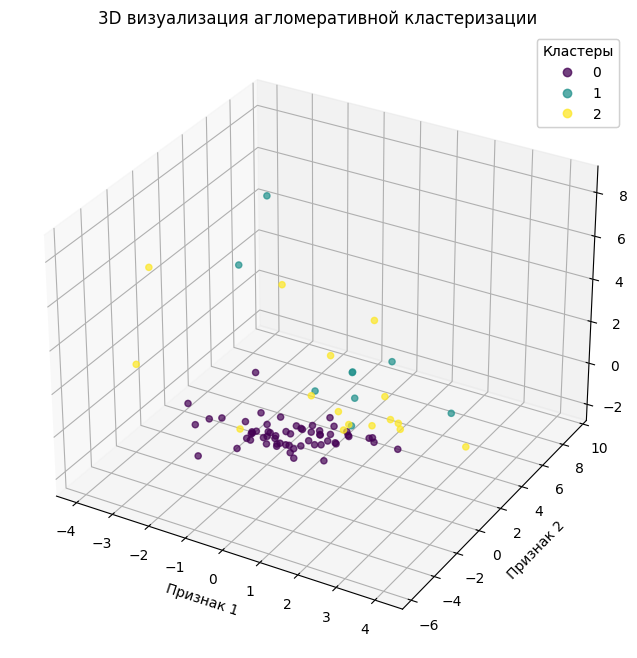

In [16627]:
# Визуализация кластеров за 2016 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2016]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2016 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
#Кластеры с региона в 2017 году
region_clusters_by_year[2017]

{0: ['Алтайский край_2017',
  'Амурская область_2017',
  'Астраханская область_2017',
  'Белгородская область_2017',
  'Брянская область_2017',
  'Владимирская область_2017',
  'Волгоградская область_2017',
  'Вологодская область_2017',
  'Воронежская область_2017',
  'Забайкальский край_2017',
  'Ивановская область_2017',
  'Иркутская область_2017',
  'Кабардино-Балкарская Республика_2017',
  'Калининградская область_2017',
  'Калужская область_2017',
  'Карачаево-Черкесская Республика_2017',
  'Кемеровская область - Кузбасс_2017',
  'Кировская область_2017',
  'Костромская область_2017',
  'Краснодарский край_2017',
  'Курганская область_2017',
  'Курская область_2017',
  'Ленинградская область_2017',
  'Липецкая область_2017',
  'Московская область_2017',
  'Мурманская область_2017',
  'Нижегородская область_2017',
  'Новгородская область_2017',
  'Новосибирская область_2017',
  'Омская область_2017',
  'Оренбургская область_2017',
  'Орловская область_2017',
  'Пензенская область_2

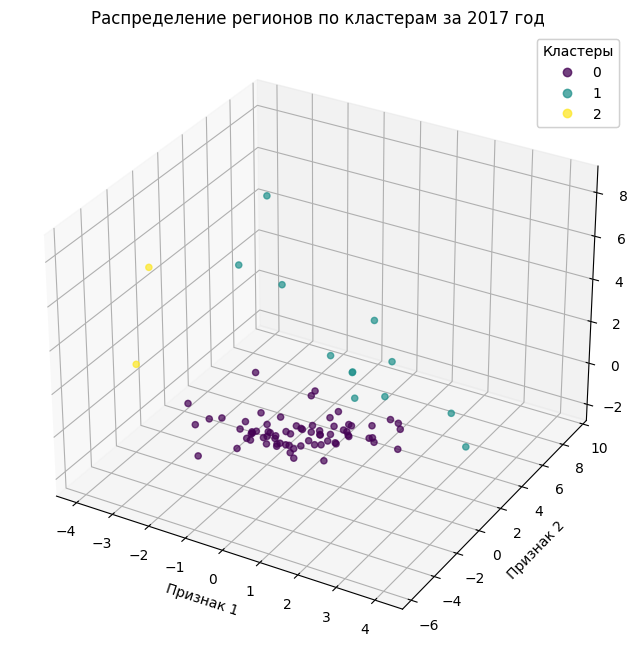

In [16628]:
# Визуализация кластеров за 2017 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2017]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2017 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
#Кластеры с региона в 2018 году
region_clusters_by_year[2018]

{1: ['Алтайский край_2018',
  'Белгородская область_2018',
  'Брянская область_2018',
  'Владимирская область_2018',
  'Волгоградская область_2018',
  'Вологодская область_2018',
  'Воронежская область_2018',
  'Забайкальский край_2018',
  'Ивановская область_2018',
  'Иркутская область_2018',
  'Кабардино-Балкарская Республика_2018',
  'Калининградская область_2018',
  'Карачаево-Черкесская Республика_2018',
  'Кировская область_2018',
  'Костромская область_2018',
  'Краснодарский край_2018',
  'Курская область_2018',
  'Ленинградская область_2018',
  'Липецкая область_2018',
  'Московская область_2018',
  'Нижегородская область_2018',
  'Новгородская область_2018',
  'Новосибирская область_2018',
  'Орловская область_2018',
  'Пензенская область_2018',
  'Псковская область_2018',
  'Республика Адыгея_2018',
  'Республика Башкортостан_2018',
  'Республика Дагестан_2018',
  'Республика Ингушетия_2018',
  'Республика Калмыкия_2018',
  'Республика Крым_2018',
  'Республика Марий Эл_2018

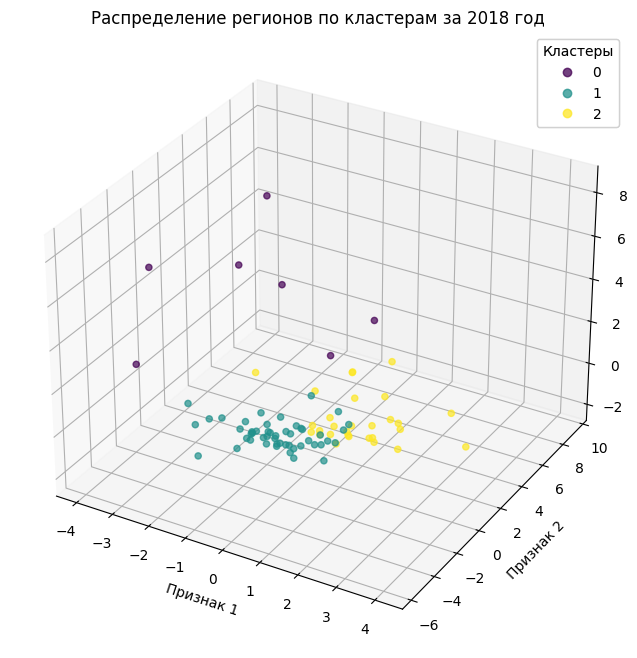

In [16629]:
# Визуализация кластеров за 2018 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2018]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2018 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
#Кластеры с региона в 2019 году
region_clusters_by_year[2019]

{2: ['Алтайский край_2019',
  'Амурская область_2019',
  'Астраханская область_2019',
  'Белгородская область_2019',
  'Брянская область_2019',
  'Владимирская область_2019',
  'Волгоградская область_2019',
  'Вологодская область_2019',
  'Воронежская область_2019',
  'Еврейская автономная область_2019',
  'Забайкальский край_2019',
  'Ивановская область_2019',
  'Кабардино-Балкарская Республика_2019',
  'Калининградская область_2019',
  'Калужская область_2019',
  'Карачаево-Черкесская Республика_2019',
  'Кемеровская область - Кузбасс_2019',
  'Кировская область_2019',
  'Костромская область_2019',
  'Краснодарский край_2019',
  'Курганская область_2019',
  'Курская область_2019',
  'Ленинградская область_2019',
  'Липецкая область_2019',
  'Мурманская область_2019',
  'Нижегородская область_2019',
  'Новгородская область_2019',
  'Новосибирская область_2019',
  'Омская область_2019',
  'Оренбургская область_2019',
  'Орловская область_2019',
  'Пензенская область_2019',
  'Пермский 

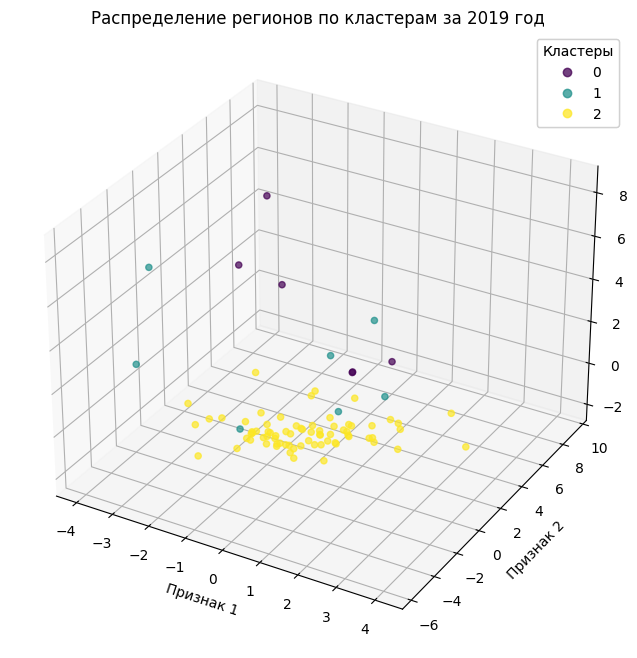

In [16630]:
# Визуализация кластеров за 2019 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2019]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2019 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
#Кластеры с региона в 2020 году
region_clusters_by_year[2020]

{2: ['Алтайский край_2020',
  'Амурская область_2020',
  'Астраханская область_2020',
  'Белгородская область_2020',
  'Брянская область_2020',
  'Владимирская область_2020',
  'Волгоградская область_2020',
  'Вологодская область_2020',
  'Воронежская область_2020',
  'Еврейская автономная область_2020',
  'Ивановская область_2020',
  'Кабардино-Балкарская Республика_2020',
  'Калининградская область_2020',
  'Калужская область_2020',
  'Камчатский край_2020',
  'Карачаево-Черкесская Республика_2020',
  'Кемеровская область - Кузбасс_2020',
  'Кировская область_2020',
  'Костромская область_2020',
  'Краснодарский край_2020',
  'Курганская область_2020',
  'Курская область_2020',
  'Ленинградская область_2020',
  'Липецкая область_2020',
  'Мурманская область_2020',
  'Нижегородская область_2020',
  'Новгородская область_2020',
  'Новосибирская область_2020',
  'Омская область_2020',
  'Оренбургская область_2020',
  'Орловская область_2020',
  'Пензенская область_2020',
  'Пермский кра

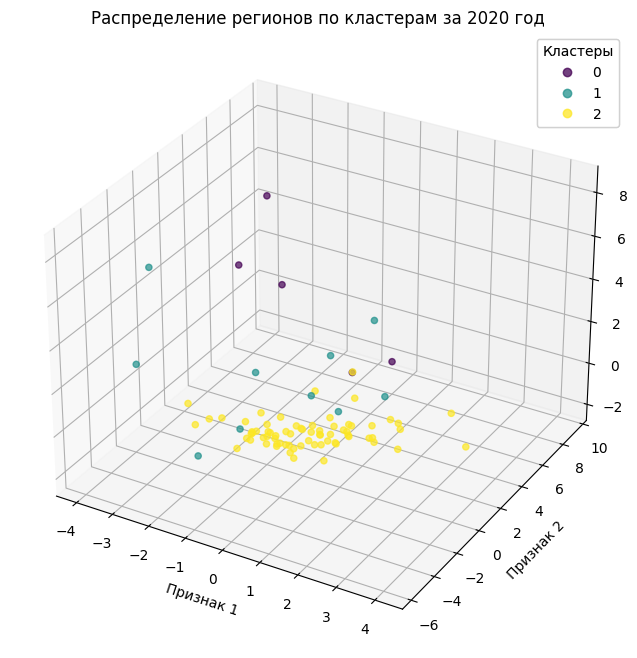

In [16631]:
# Визуализация кластеров за 2020 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2020]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2020 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
#Кластеры с региона в 2021 году
region_clusters_by_year[2021]

{0: ['Алтайский край_2021',
  'Амурская область_2021',
  'Астраханская область_2021',
  'Еврейская автономная область_2021',
  'Калужская область_2021',
  'Камчатский край_2021',
  'Кемеровская область - Кузбасс_2021',
  'Красноярский край_2021',
  'Курганская область_2021',
  'Магаданская область_2021',
  'Мурманская область_2021',
  'Новгородская область_2021',
  'Пермский край_2021',
  'Приморский край_2021',
  'Псковская область_2021',
  'Республика Алтай_2021',
  'Республика Бурятия_2021',
  'Республика Карелия_2021',
  'Республика Коми_2021',
  'Республика Северная Осетия-Алания_2021',
  'Республика Тыва_2021',
  'Республика Хакасия_2021',
  'Самарская область_2021',
  'Сахалинская область_2021',
  'Свердловская область_2021',
  'Смоленская область_2021',
  'Удмуртская Республика_2021',
  'Хабаровский край_2021',
  'Ханты-Мансийский автономный округ_2021',
  'Челябинская область_2021'],
 1: ['Архангельская область_2021',
  'Белгородская область_2021',
  'Брянская область_2021',
 

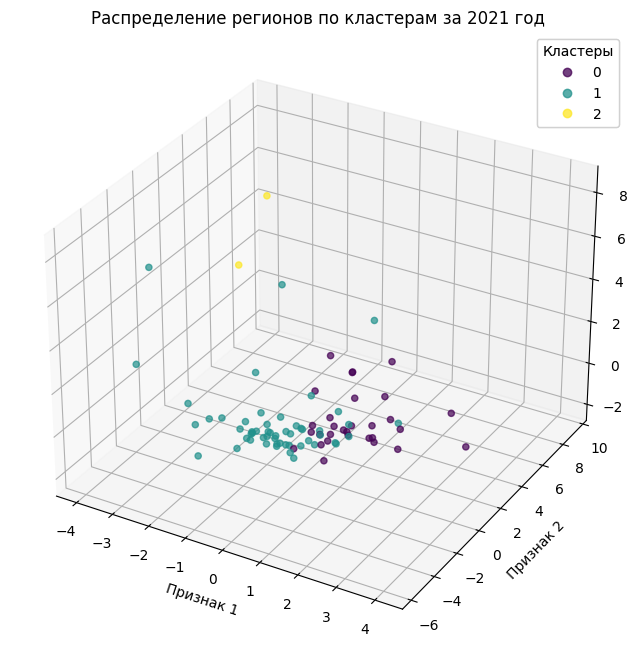

In [16632]:
# Визуализация кластеров за 2021 год в пространстве PCA(3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 2], pca_result_3d[:, 0], pca_result_3d[:, 1], c=yearly_cluster_tables[2021]['Кластер'], cmap='viridis', alpha=0.7)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак  3')
ax.set_title('Распределение регионов по кластерам за 2021 год')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

In [ ]:
# Подсчитаем количество регионов в каждом кластере для каждого года
cluster_sizes_by_year = {}
for year, clusters in region_clusters_by_year.items():
    cluster_sizes_by_year[year] = {cluster: len(clusters[cluster]) for cluster in clusters}

print(cluster_sizes_by_year)

{2016: {0: 60, 2: 16, 1: 9}, 2017: {0: 71, 2: 2, 1: 12}, 2018: {1: 49, 2: 29, 0: 7}, 2019: {2: 72, 1: 7, 0: 6}, 2020: {2: 70, 1: 10, 0: 5}, 2021: {0: 30, 1: 53, 2: 2}}


Как мы видим состав и количество регионов в каждом кластере менялся в зависимости от экономической и демографической статистики.

## 6. Кластеризация сводной таблицы.

Поскольку мы уже знаем наилучшие модели кластеризации, которые мы использовали для выявления уязвимых групп населения, как на средних значениях за период с 2016 по 2021 гг., так и за каждый год, чтобы посмотреть на различия регионов, то нам ничего не мешает провести кластеризацию общей сводной таблицы. 

In [16638]:
total_df = df.copy()

In [16639]:
total_df.head(2)

Численность_населения_left             Регион_Год   
0                   2376774.0    Алтайский край_2016  \
1                    805689.0  Амурская область_2016   

   Смертность_детей_сельская_местность_left  Смертность_детей_город_left   
0                                      87.0                        124.0  \
1                                      23.0                         30.0   

   Соцрасходы_left  Доходы_left  ВРП_left  Полезные_ископаемые_left   
0             20.4      21256.0  224.5258                 4852175.4  \
1             28.9      27976.0  370.1924                64379100.3   

   Обрабатывающее_производство_left  Электроэнергия_left  ...   
0                      2.658828e+08          45046977.27  ...  \
1                      2.789874e+07          33658987.30  ...   

   Обрабатывающее_производство_доля  Электроэнергия_доля  Промышленность_доля   
0                      1.184197e+06        200631.630173         1.638957e+06  \
1                      7.536280e+04         90922.956009         3.631141e+05   

   Водоснабжение_доля  Розничная_торговля  ВРП_vs_mean  Доходы_vs_mean   
0        35936.277256            0.858306     0.364569        0.691536  \
1         7781.224574            3.586992     0.601093        0.910163   

   Индекс_наркомании  Индекс_алкоголизма  Индекс_благосостояния  
0           0.732085            4.211591               0.007351  
1           2.345818           11.456033               0.028820  

[2 rows x 53 columns]

In [ ]:
# Список признаков для удаления
columns_to_drop = [
    'Численность_населения_left',
    'Смертность_детей_сельская_местность_left',
    'Смертность_детей_город_left',
    'Розничная_торговля_left',
    'ВРП_left',
    'Общее_число_инвалидов_left',
    'Число_инвалидов_18_30_left', 
    'Число_инвалидов_31_40_left',
    'Число_инвалидов_41_50_left',
    'Число_инвалидов_51_60_left', 
    'Число_инвалидов_60_left',
    'Доходы_left',
    'Бедные_left',
    'Полезные_ископаемые_left',
    'Обрабатывающее_производство_left',
    'Водоснабжение_left',
    'Промышленность_left',
    'Новорожденные_left',
    'Общая_преступность_left',
    'Тяжелые_преступления_left',
    'Электроэнергия_left',
    'Наркомания_left', 
    'Алкоголизм_left',
    'Экономические_преступления_left',
    'Нарко_преступления_left',
    'Инвалидность_18_30', 'Инвалидность_31_40',
    'Инвалидность_41_50',
    'Инвалидность_51_60',
    'Инвалидность_60_',
    'Водоснабжение_доля',
    'Индекс_алкоголизма',
    'Индекс_благосостояния',
    'Обрабатывающее_производство_доля',
    'Розничная_торговля'
    ]

# Удаление колонок
total_df = total_df.drop(columns=columns_to_drop, axis=1)


Произведем предобработку исходных данных. Для удобства обернем этот шаг в pipeline. Подберем оптимальное количество кластеров для выбранных методов (Kmeans и агламеративная кластеризация) с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно. Выберем алгоритм с наибольшим коэффициентом силуэта, сделайте предсказание меток кластеров.

In [16640]:
# Выбираем только числовые столбцы из scaled_df
numeric_scaled_df = scaled_df.select_dtypes(include=[np.number])

In [ ]:
pipeline = Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', PCA(n_components=3))])
pipeline.fit(total_df.select_dtypes(include=[np.number]))
total_df_norm = pipeline.transform(total_df.select_dtypes(include=[np.number]))
total_df_norm = pd.DataFrame(total_df_norm, columns=[f'Признак_{i+1}' for i in range(3)])
print('Уменьшаем размерность исходных признаков до', len(pipeline['pca'].components_),
      'компонентов, которые объясняют {:.2%} долю дисперсии исходных данных'.format(sum(pipeline['pca'].explained_variance_ratio_)))


Уменьшаем размерность исходных признаков до 3 компонентов, которые объясняют 45.33% долю дисперсии исходных данных


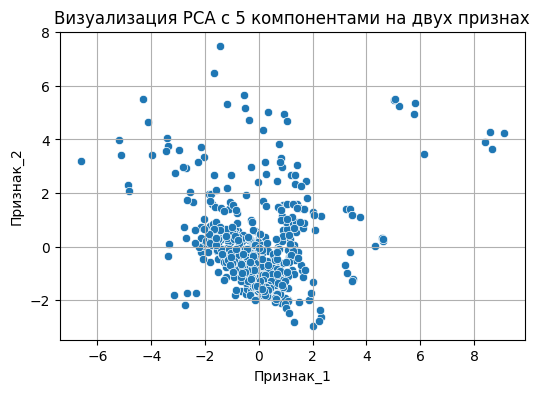

In [ ]:
#Визуализируем пространство после декомпозиции с помощью PCA
fig = plt.figure(figsize=(6,4))
scatt = sns.scatterplot(x=total_df_norm['Признак_1'],
                y=total_df_norm['Признак_2'])
scatt.set_title('Визуализация PCA с 5 компонентами на двух признах')
scatt.grid()

Сначала применим метод k-means, а для определения оптимального количества кластеров воспользуемся коэффициентом силуэта

In [ ]:
kmeans_sil_total = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters=i, n_init=50, random_state = 42)
    kmeans.fit(total_df_norm )
    sil_score = silhouette_score(total_df_norm , kmeans.labels_)
    kmeans_sil_total.append((i,sil_score))
      
kmeans_sil = pd.DataFrame(kmeans_sil, columns=['number_of_cluster', 'sil_score'])
kmeans_sil

number_of_cluster  sil_score
0                  3   0.419592
1                  4   0.207719
2                  5   0.201076
3                  6   0.195064
4                  7   0.195852
5                  8   0.162461
6                  9   0.183159
7                 10   0.151942

Теперь агаламеративная кластеризация, также в качестве метрики используем значение коэффициента силуэта.

In [ ]:
agg_sil_total = []

for i in range(3, 11):
    agg = AgglomerativeClustering(n_clusters=i)
    agg.fit(total_df_norm)
    agg_sil_score = silhouette_score(total_df_norm, agg.labels_)
    agg_sil_total.append((i, agg_sil_score))
    
agg_sil = pd.DataFrame(agg_sil, columns=['number_of_cluster', 'agg_score'])
agg_sil

number_of_cluster  agg_score
0                  3   0.364116
1                  4   0.384866
2                  5   0.390441
3                  6   0.377449
4                  7   0.359091
5                  8   0.366168
6                  9   0.348034
7                 10   0.357681

Видим, что оптимальное количество кластеров состовляет три, но агломеративная кластеризация все равно дает меньшее значение коэф-та силуэта (0.36), чем Kmeans алгоритм(0.42), поэтому именно его возьмем в качестве модели для кластеризации групп населения. 

Кластер
0    402
1     69
2     39
Name: count, dtype: int64


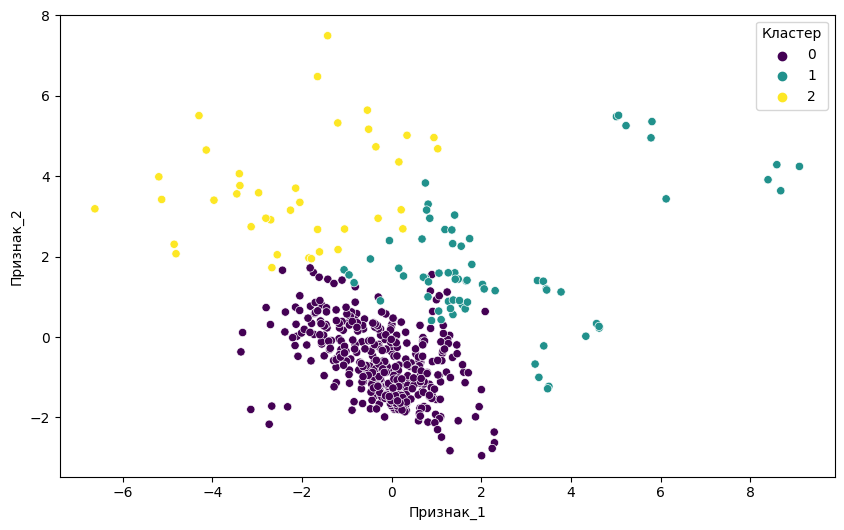

In [ ]:
#Обучаем модель на трех кластерах, делаем визуализацию
kmeans_total = KMeans(n_clusters=3, n_init= 50, random_state=42)
kmeans_total.fit(total_df_norm)
total_df_norm['Кластер'] = kmeans_total.labels_
print(total_df_norm['Кластер'].value_counts())
plt.figure(figsize=(10,6))
sns.scatterplot(data=total_df_norm, x='Признак_1', y='Признак_2', hue='Кластер', palette='viridis')
plt.show()

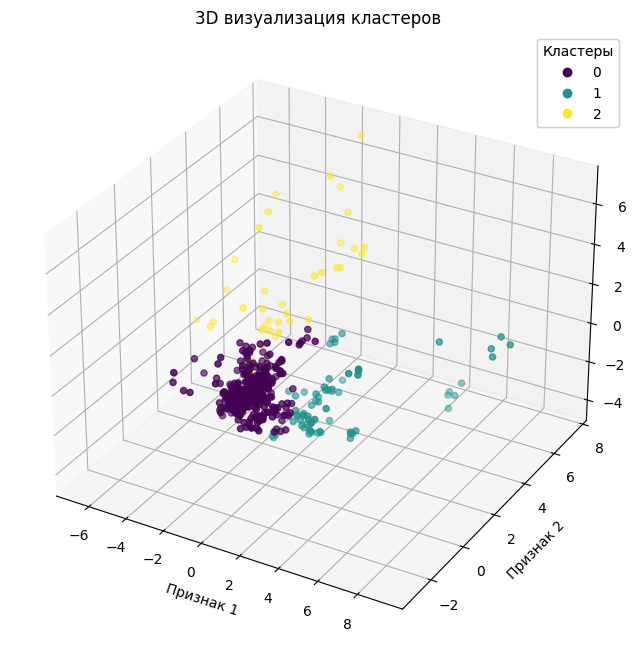

In [ ]:
# Создаем 3D визуализацию
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Используем данные из DataFrame
scatter = ax.scatter(
    total_df_norm['Признак_1'], 
    total_df_norm['Признак_2'], 
    total_df_norm['Признак_3'], 
    c=total_df_norm['Кластер'], 
    cmap='viridis'
)

# Подписи осей и название графика
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.set_zlabel('Признак 3')
ax.set_title('3D визуализация кластеров')

# Добавляем легенду
legend = ax.legend(*scatter.legend_elements(), title="Кластеры")
ax.add_artist(legend)

plt.show()

На трехмерном графике видим точки пересечения между нулевым и первым кластерами, такое нечеткое разделение может быть обусловлено тем, что во-первых, максимум мы можем построить только 3D визуализацию, т е использовать только три компонента из пяти, полученных с помощью PCA алгоритма снижения размерности, а во-вторых, не забываем, что в данной кластеризации мы используем сводную таблицы, где собрана информация по 85 регионам за 6 лет. Таким образом, в разные кластеры могут входить одни и те же регионы, но в разный момент измерения (год).

In [ ]:
#Задаем метки кластеров
total_df['Кластер'] = total_df_norm['Кластер']
# Добавляем столбец с названиями регионов без года
total_df['Регион'] = total_df['Регион_Год'].str.split('_').str[0]
# Фильтруем данные, выбирая строки с KMeans == 0 и убираем дубликаты(unique())
total_df_0 = total_df[total_df['Кластер'] == 0]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 0
print("Регионы в кластере 0:")
print("\n".join(total_df_0))


Регионы в кластере 0:
Алтайский край
Амурская область
Архангельская область
Астраханская область
Белгородская область
Брянская область
Владимирская область
Волгоградская область
Вологодская область
Воронежская область
Забайкальский край
Ивановская область
Кабардино-Балкарская Республика
Калининградская область
Калужская область
Карачаево-Черкесская Республика
Кировская область
Костромская область
Краснодарский край
Курганская область
Курская область
Ленинградская область
Липецкая область
Мурманская область
Нижегородская область
Новгородская область
Новосибирская область
Омская область
Оренбургская область
Орловская область
Пензенская область
Приморский край
Псковская область
Республика Адыгея
Республика Бурятия
Республика Дагестан
Республика Ингушетия
Республика Калмыкия
Республика Карелия
Республика Коми
Республика Крым
Республика Марий Эл
Республика Мордовия
Республика Саха (Якутия)
Республика Северная Осетия-Алания
Республика Хакасия
Ростовская область
Рязанская область
Саратовская 

In [ ]:
# Фильтруем данные, выбирая строки с KMeans == 1 и убираем дубликаты(unique())
total_df_1 = total_df[total_df['Кластер'] == 1]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 1
print("Регионы в кластере 1:")
print("\n".join(total_df_1))

Регионы в кластере 1:
Иркутская область
Кемеровская область - Кузбасс
Красноярский край
Москва
Московская область
Пермский край
Республика Башкортостан
Республика Татарстан
Самарская область
Санкт-Петербург
Свердловская область
Тюменская область
Ханты-Мансийский автономный округ
Челябинская область
Архангельская область


In [ ]:
# Фильтруем данные, выбирая строки с KMeans == 2 и убираем дубликаты(unique())
total_df_2 = total_df[total_df['Кластер'] == 2]['Регион'].unique()#Выбираем только уникальные регионы
# Выводим регионы, относящиеся к кластеру 2
print("Регионы в кластере 2:")
print("\n".join(total_df_2))

Регионы в кластере 2:
Еврейская автономная область
Камчатский край
Магаданская область
Ненецкий автономный округ
Республика Алтай
Республика Тыва
Сахалинская область
Чукотский автономный округ
Ямало-Ненецкий автономный округ


Видим, что состав кластеров немного отличается от состава кластеров со средними значениями, посмотрим на их статистику. 

In [ ]:
# Группируем данные по кластерам и вычисляем средние значения для числовых колонок
cluster_means = total_df.groupby('Кластер').mean(numeric_only=True)

# Выводим результаты
print("Средние значения экономических показателей по кластерам:")
cluster_means


Средние значения экономических показателей по кластерам:


Соцрасходы_left  Малообеспеченные дети_left   
Кластер                                                
0              22.603483                   35.936318  \
1              19.901449                   44.921739   
2              14.617949                   36.043590   

         Малообеспеченные трудящиеся_left  Малообеспеченные пенсионеры_left   
Кластер                                                                       
0                               55.673632                          5.404478  \
1                               59.897101                          6.775362   
2                               46.802564                          4.325641   

         детская_смертность  Общая_инвалидность  Рождаемость   
Кластер                                                        
0                  5.722566          109.851865  1042.036706  \
1                  7.364122           68.601957  1206.578063   
2                 10.634533          407.469711  1358.472554   

         Нарко_преступления  Экономические_преступления  Тяжелые_преступления   
Кластер                                                                         
0                  0.117742                    0.067750              0.065341  \
1                  0.131439                    0.056617              0.080400   
2                  0.168219                    0.096238              0.093580   

         Всего_преступлений  Полезные_ископаемые_доля  Электроэнергия_доля   
Кластер                                                                      
0                  1.355427              8.754929e+04        113307.782776  \
1                  1.315368              1.179024e+06        406168.797327   
2                  1.977540              1.445912e+05         18047.387456   

         Промышленность_доля  ВРП_vs_mean  Доходы_vs_mean  Индекс_наркомании  
Кластер                                                                       
0               1.047095e+06     0.641633        0.864032           0.960855  
1               3.460639e+06     1.549152        1.328800           0.319073  
2               2.326554e+05     3.722360        1.819795           8.086578

#### Сравнение кластеров по ключевым показателям
1. Социальные расходы (Соцрасходы_left)

Кластер 0: Средние соцрасходы составляют 22.60, что выше, чем в кластере 2, но ниже, чем в кластере 1.
Кластер 1: Самые низкие соцрасходы — 19.90.
Кластер 2: Самые высокие соцрасходы — 14.61.
Социальные расходы в кластере 2 ниже остальных, что может свидетельствовать о недостаточной поддержке уязвимых групп.

2. Малообеспеченные группы (дети, трудящиеся, пенсионеры)

Дети (Малообеспеченные дети_left): Самый высокий показатель в кластере 1 (44.92), а самый низкий — в кластере 0 (35.94).
Трудящиеся: Похожая ситуация: кластер 1 — 59.89, кластер 0 — 55.67.
Пенсионеры: Наиболее уязвимые пенсионеры в кластере 1 (6.77).
Кластер 1 выделяется наибольшим числом малообеспеченных групп населения.

3. Младенческая смертность (детская_смертность)

Кластер 0: Самый низкий показатель — 5.72.
Кластер 1: Средний уровень — 7.36.
Кластер 2: Самый высокий показатель — 10.63.
Кластер 2 является самым неблагополучным по младенческой смертности, что говорит о проблемах в доступе к медицинским услугам.

4. Инвалидность (Общая_инвалидность)

Кластер 0: 109.85 — умеренный уровень.
Кластер 1: 68.60 — самый низкий показатель.
Кластер 2: 407.47 — критический уровень.
Кластер 2 выделяется резким ростом инвалидности, что может быть связано с тяжелыми условиями жизни или неблагоприятной средой.

5. Преступность (Нарко, экономические, тяжелые)

Кластер 0 и 1: Сходные показатели нарко- и экономических преступлений.
Кластер 2: Наиболее высокий уровень преступности (наркотики — 0.17, экономические — 0.09).
Кластер 2 демонстрирует наиболее неблагоприятную криминогенную обстановку.

6. Экономические показатели (Промышленность, ВРП_vs_mean, Доходы_vs_mean)

Промышленность:
Кластер 0 — 1.047 млн.
Кластер 1 — 3.46 млн (в 3 раза выше).
Кластер 2 — 0.232 млн (очень низкий уровень).
Доходы: Самые низкие доходы в кластере 0 (0.86), а самые высокие — в кластере 2 (1.81).
Кластер 2 демонстрирует высокий дисбаланс между доходами и промышленным потенциалом.

#### Анализ состава кластеров по регионам
 
- Кластер 0

__Регионы:__

_Дотационные регионы:_ 
Много регионов с экономическими трудностями (например, Забайкальский край, Республика Дагестан, Республика Тыва).
_Социальная значимость:_ 
Много малонаселенных регионов с низкой социальной поддержкой (Архангельская область, Вологодская область, Костромская область).
_Экономическое положение:_
Основной упор на промышленность и малый бизнес с ограниченными ресурсами.
_Географическое положение:_
Преимущественно северные, восточные и центральные регионы России.
_Основные уязвимые группы:_
Высокий уровень инвалидности, младенческой смертности, преступности и низкие социальные расходы.

- Кластер 1

__Регионы:__

_Развитые регионы:_
Иркутская область, Москва, Московская область, Санкт-Петербург — более развитые экономически и социально.
_Социальная значимость:_
Высокий уровень социального обеспечения и поддержки малообеспеченных групп населения (пенсионеры, трудящиеся).
_Экономическое положение:_
Высокий уровень доходов, развитая промышленность и инновации.
_Географическое положение:_
Центральные и крупные регионы, значимые с экономической точки зрения.
_Основные уязвимые группы:_
Проблемы с преступностью и социальной поддержкой трудящихся и пенсионеров.

- Кластер 2

__Регионы:__

_Отдаленные регионы:_
Еврейская автономная область, Камчатский край, Магаданская область — удаленные, труднодоступные регионы с низкими экономическими и социальными показателями.
_Социальная значимость:_
Высокий уровень инвалидности, младенческой смертности и ограниченная доступность медицинских и социальных услуг.
_Экономическое положение:_
Проблемы с инфраструктурой и низкий уровень промышленности и доходов.
_Географическое положение:_ 
Восточные и сибирские регионы, с трудными климатическими условиями и удаленностью от центра.
_Основные уязвимые группы:_
Высокий риск бедности и социального исключения, отсутствие полноценной инфраструктуры.

#### Основные выводы по кластерам 

__Кластер 0__ — характеризуется высокой уязвимостью за счет социальной и экономической нестабильности, преобладания дотационных регионов, географической удаленности.

__Кластер 1__ — развитые регионы с большей социальной и экономической поддержкой, но также с признаками преступности и социальной напряженности.

__Кластер 2__ — отдаленные и слаборазвитые регионы, требующие особого внимания к улучшению инфраструктуры и социальной поддержки.
Эти данные могут помочь направить меры поддержки на наиболее уязвимые группы населения с учетом их регионального контекста.

## 7. Дополнительные шаги

Теперь у нас есть метки предсказаний трех кластеров, следовательно мы можем перевести задачу кластеризацию в задачу классификации. Для этого, как обычно, выделим матрицу наблюдений и вектор предсказаний классов. 

In [16642]:
X = cleaned_df.drop(['Регион','Кластер'], axis=1)
y = cleaned_df['Кластер'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Отлично, теперь для решении задачи классификации применим три алгоритма машинного обучения: RandomForestClassifie, GradientBoostingClassifier, аdaBoostClassifier, с помощью GridSearchCV найдем лучшие параметры для алгоритмов, а метрику будем оценивать с помощью accuracy_score. Посмотрим какой из алгоритмов лучше справиться с задачей. 

In [16654]:
#RandomForestClassifie
params = {'max_features': [4, 5, 6, 7], 'min_samples_leaf': [3, 5, 7, 9, 11], 'max_depth': [5, 10, 15]}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_estimators=100),
    param_grid=params,
    cv=StratifiedKFold(n_splits=10)#будем использовать кросс-валидацию Stratified K-Fold, 
    #которая сохраняет баланс классов в каждом разбиении.
)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)
print(accuracy_score(y_test, y_pred_best_rf))


{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 3}
0.8823529411764706


In [16655]:
#GradientBoostingClassifier
params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}
grad = GridSearchCV(
    estimator=GradientBoostingClassifier(), 
    param_grid= params, 
    cv=3)
grad.fit(X_train, y_train)
best_boost = grad.best_params_
print(best_boost)
y_pred_grid = grad.predict(X_test)
print(accuracy_score(y_test, y_pred_grid))

{'learning_rate': 1.0, 'n_estimators': 4}
0.8823529411764706


In [16656]:
#Проверим сможем ли улучшить результат с помощью AdaBoostClassifier
ada =AdaBoostClassifier(estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=32),  
                        random_state=42)
ada.fit(X_train, y_train)
y_ada = ada.predict(X_test)
print(accuracy_score(y_test, y_ada))

0.9411764705882353


Мы добились высокой точности предсказаний с помощью алгоритмов RandomForestClassifier и AdaBoostClassifier. 

Как результат, у нас есть модель, которая на основе данных автоматически определяет принадлежность региона РФ к одному из трех кластеров. В дальнейшем эту модель можно применять на новых данных.

In [16663]:
# В качестве обученной  модели вибираем RandomForestClassifier и сохраняем её в файл pickle
with open("social_russia_data\ada.pkl", "wb") as f:
    pickle.dump(grid_search, f)

In [16664]:
# Загрузка сохраненной модели из файла pickle
with open("social_russia_data\ada.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [16661]:
# создадим тестовый набор 
data = [
       ('10.64', '56754.78' ,'1150.83', '32.87', '67.87', '51.68', '4.20', '302.86', 
     '703.49', '0.87', '0.15', '0.13', '2.11', '47324.15', '29196.64', '300798.99', '7.1'),
       ('17.8', '39854.16',	'486.85', '41.5', '38.75', '15.55', '3.35', '49.62', '995.47',
       '0.18', '0.06', '0.08', '1.23', '31447.99', '716759.89', '4.280283e+06', '0.90'),
       ('9.31', '69881.83', '1551.22',	'27.96', '36.80', '1.9', '16.05',	'702.29', '1182.64',
        '0.04', '0.08', '0.05', '1.54', '27117.16', '23648.84', '2.387774e+05', '9.39') 
       ]



columns = ['Соцрасходы_left', 'Доходы_left', 'ВРП_left',
       'Малообеспеченные дети_left', 'Малообеспеченные трудящиеся_left',
       'Малообеспеченные пенсионеры_left', 'детская_смертность',
       'Общая_инвалидность', 'Рождаемость', 'Нарко_преступления',
       'Экономические_преступления', 'Тяжелые_преступления',
       'Всего_преступлений', 'Полезные_ископаемые_доля', 'Электроэнергия_доля',
       'Промышленность_доля', 'Индекс_наркомании']
test_data = pd.DataFrame(data, columns=columns)

test_data.head()

Соцрасходы_left Доходы_left ВРП_left Малообеспеченные дети_left   
0           10.64    56754.78  1150.83                      32.87  \
1            17.8    39854.16   486.85                       41.5   
2            9.31    69881.83  1551.22                      27.96   

  Малообеспеченные трудящиеся_left Малообеспеченные пенсионеры_left   
0                            67.87                            51.68  \
1                            38.75                            15.55   
2                            36.80                              1.9   

  детская_смертность Общая_инвалидность Рождаемость Нарко_преступления   
0               4.20             302.86      703.49               0.87  \
1               3.35              49.62      995.47               0.18   
2              16.05             702.29     1182.64               0.04   

  Экономические_преступления Тяжелые_преступления Всего_преступлений   
0                       0.15                 0.13               2.11  \
1                       0.06                 0.08               1.23   
2                       0.08                 0.05               1.54   

  Полезные_ископаемые_доля Электроэнергия_доля Промышленность_доля   
0                 47324.15            29196.64           300798.99  \
1                 31447.99           716759.89        4.280283e+06   
2                 27117.16            23648.84        2.387774e+05   

  Индекс_наркомании  
0               7.1  
1              0.90  
2              9.39

In [16662]:
#Проверяем
y_pred = loaded_model.predict(test_data)
print(y_pred)

[2 0 2]


Модель работает.

## 8. Общие выводы

1. Кластеризация регионов:

Кластеризация регионов позволила выделить три группы, каждая из которых характеризуется уникальными особенностями в уровнях доходов, социального благополучия, и других социально-демографических характеристиках. Важно отметить, что в каждой группе наблюдаются различия по уровням бедности и социальных расходов, что указывает на необходимость дифференцированного подхода в поддержке различных регионов.

2. Определение наиболее уязвимых групп населения:

Анализ показал, что наиболее уязвимыми группами в регионах являются: малообеспеченные дети, пенсионеры и трудящиеся, которые страдают от низкого уровня доходов и высокого уровня детской смертности. Группы населения с низким доступом к ресурсам (например, электроэнергия, промышленность), что также коррелирует с высоким уровнем бедности.

3. Влияние численности социальных групп на уровень бедности: 

Высокие показатели детей, пенсионеров и малообеспеченных трудящихся напрямую связаны с увеличением уровня бедности. В регионах с высокой концентрацией уязвимых групп социальные расходы значительно выше, что подтверждается значительными различиями в уровне социального неблагополучия.

4. Связь уровня бедности с производством и потреблением. 

В регионах с низкой долей полезных ископаемых, электроэнергии и промышленности наблюдается снижение уровня социального благополучия и рост социального неблагополучия. Это свидетельствует о зависимости между экономическим развитием и возможностью поддерживать социальные группы.


Кластеры показывают различия в степени зависимости от социальных мероприятий и экономической активности, что требует целенаправленных мер поддержки уязвимых групп населения. В целом, результат анализа подчеркивает необходимость создания комплексных стратегий поддержки для различных регионов, ориентированных на специфические потребности уязвимых групп населения.